In [5]:
# General utilities
import numpy as np
import pandas as pd
import re

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Pretty output (optional, for displaying SHAP importance nicely)
from prettytable import PrettyTable

In [6]:
# Show all columns
pd.set_option('display.max_columns', None)

# Show all rows
pd.set_option('display.max_rows', None)

**File upload**

Upload both initial CSVs:
- ufc_fights_scraped.csv
- fighters_master_scraped.csv

In [7]:
df_fights = pd.read_csv('ufc_fights_scraped.csv')
df_fighters = pd.read_csv('fighters_master_scraped.csv')

print(df_fights.shape)
print(df_fighters.shape)

(8114, 228)
(4319, 6)


**Check structure and missing values of df_fighters**

In [8]:
df_fighters.head()

,fighter,height,weight,reach,stance,DOB
0,Tom Aaron,--,155 lbs.,--,NaN,"Jul 13, 1978"
1,Danny Abbadi,"5' 11""",155 lbs.,--,Orthodox,"Jul 03, 1983"
2,Nariman Abbasov,"5' 8""",155 lbs.,"66""",Orthodox,"Feb 01, 1994"
3,David Abbott,"6' 0""",265 lbs.,--,Switch,"Apr 26, 1965"
4,Hamdy Abdelwahab,"6' 2""",264 lbs.,"72""",Southpaw,"Jan 22, 1993"


In [9]:
# Replace '--' and 'Unknown' with NaN
df_fighters.replace(to_replace=["--", "Unknown"], value=np.nan, inplace=True)

# Create missing_info DataFrame
missing_info_fighters = pd.DataFrame({
    'Column Name': df_fighters.columns,
    'Non-Null Count': df_fighters.notnull().sum().values,
    'Null Count': df_fighters.isnull().sum().values,
    'Dtype': df_fighters.dtypes.values
})

print(missing_info_fighters)

  Column Name  Non-Null Count  Null Count   Dtype
0     fighter            4319           0  object
1      height            3969         350  object
2      weight            4233          86  object
3       reach            2346        1973  object
4      stance            3447         872  object
5         DOB            3554         765  object


--> figher has no null value, thus it can be safely merged with df_fights

**Check structure of df_fights**

In [10]:
df_fights.head()

,event_name,event_date,fighter1_name,fighter2_name,fighter1_result,fighter2_result,weight_class,method,round,time,time_format,fighter1_total_KD,fighter2_total_KD,fighter1_total_SIG_STR,fighter2_total_SIG_STR,fighter1_total_SIG_STR_pct,fighter2_total_SIG_STR_pct,fighter1_total_TOTAL_STR,fighter2_total_TOTAL_STR,fighter1_total_TD,fighter2_total_TD,fighter1_total_TD_pct,fighter2_total_TD_pct,fighter1_total_SUB_ATT,fighter2_total_SUB_ATT,fighter1_total_REV,fighter2_total_REV,fighter1_total_CTRL,fighter2_total_CTRL,fighter1_round1_KD,fighter2_round1_KD,fighter1_round1_SIG_STR,fighter2_round1_SIG_STR,fighter1_round1_SIG_STR_pct,fighter2_round1_SIG_STR_pct,fighter1_round1_TOTAL_STR,fighter2_round1_TOTAL_STR,fighter1_round1_TD,fighter2_round1_TD,fighter1_round1_TD_pct,fighter2_round1_TD_pct,fighter1_round1_SUB_ATT,fighter2_round1_SUB_ATT,fighter1_round1_REV,fighter2_round1_REV,fighter1_round1_CTRL,fighter2_round1_CTRL,fighter1_round2_KD,fighter2_round2_KD,fighter1_round2_SIG_STR,fighter2_round2_SIG_STR,fighter1_round2_SIG_STR_pct,fighter2_round2_SIG_STR_pct,fighter1_round2_TOTAL_STR,fighter2_round2_TOTAL_STR,fighter1_round2_TD,fighter2_round2_TD,fighter1_round2_TD_pct,fighter2_round2_TD_pct,fighter1_round2_SUB_ATT,fighter2_round2_SUB_ATT,fighter1_round2_REV,fighter2_round2_REV,fighter1_round2_CTRL,fighter2_round2_CTRL,fighter1_total_SIG_SIG_STR,fighter2_total_SIG_SIG_STR,fighter1_total_SIG_SIG_STR_pct,fighter2_total_SIG_SIG_STR_pct,fighter1_total_SIG_HEAD,fighter2_total_SIG_HEAD,fighter1_total_SIG_BODY,fighter2_total_SIG_BODY,fighter1_total_SIG_LEG,fighter2_total_SIG_LEG,fighter1_total_SIG_DISTANCE,fighter2_total_SIG_DISTANCE,fighter1_total_SIG_CLINCH,fighter2_total_SIG_CLINCH,fighter1_total_SIG_GROUND,fighter2_total_SIG_GROUND,fighter1_SIG_round1_SIG_STR,fighter2_SIG_round1_SIG_STR,fighter1_SIG_round1_SIG_STR_pct,fighter2_SIG_round1_SIG_STR_pct,fighter1_SIG_round1_HEAD,fighter2_SIG_round1_HEAD,fighter1_SIG_round1_BODY,fighter2_SIG_round1_BODY,fighter1_SIG_round1_LEG,fighter2_SIG_round1_LEG,fighter1_SIG_round1_DISTANCE,fighter2_SIG_round1_DISTANCE,fighter1_SIG_round1_CLINCH,fighter2_SIG_round1_CLINCH,fighter1_SIG_round1_GROUND,fighter2_SIG_round1_GROUND,fighter1_SIG_round2_SIG_STR,fighter2_SIG_round2_SIG_STR,fighter1_SIG_round2_SIG_STR_pct,fighter2_SIG_round2_SIG_STR_pct,fighter1_SIG_round2_HEAD,fighter2_SIG_round2_HEAD,fighter1_SIG_round2_BODY,fighter2_SIG_round2_BODY,fighter1_SIG_round2_LEG,fighter2_SIG_round2_LEG,fighter1_SIG_round2_DISTANCE,fighter2_SIG_round2_DISTANCE,fighter1_SIG_round2_CLINCH,fighter2_SIG_round2_CLINCH,fighter1_SIG_round2_GROUND,fighter2_SIG_round2_GROUND,fighter1_sig_strike_head,fighter2_sig_strike_head,fighter1_sig_strike_body,fighter2_sig_strike_body,fighter1_sig_strike_leg,fighter2_sig_strike_leg,fighter1_sig_strike_distance,fighter2_sig_strike_distance,fighter1_sig_strike_clinch,fighter2_sig_strike_clinch,fighter1_sig_strike_ground,fighter2_sig_strike_ground,fight_link,fighter1_round3_KD,fighter2_round3_KD,fighter1_round3_SIG_STR,fighter2_round3_SIG_STR,fighter1_round3_SIG_STR_pct,fighter2_round3_SIG_STR_pct,fighter1_round3_TOTAL_STR,fighter2_round3_TOTAL_STR,fighter1_round3_TD,fighter2_round3_TD,fighter1_round3_TD_pct,fighter2_round3_TD_pct,fighter1_round3_SUB_ATT,fighter2_round3_SUB_ATT,fighter1_round3_REV,fighter2_round3_REV,fighter1_round3_CTRL,fighter2_round3_CTRL,fighter1_SIG_round3_SIG_STR,fighter2_SIG_round3_SIG_STR,fighter1_SIG_round3_SIG_STR_pct,fighter2_SIG_round3_SIG_STR_pct,fighter1_SIG_round3_HEAD,fighter2_SIG_round3_HEAD,fighter1_SIG_round3_BODY,fighter2_SIG_round3_BODY,fighter1_SIG_round3_LEG,fighter2_SIG_round3_LEG,fighter1_SIG_round3_DISTANCE,fighter2_SIG_round3_DISTANCE,fighter1_SIG_round3_CLINCH,fighter2_SIG_round3_CLINCH,fighter1_SIG_round3_GROUND,fighter2_SIG_round3_GROUND,fighter1_round4_KD,fighter2_round4_KD,fighter1_round4_SIG_STR,fighter2_round4_SIG_STR,fighter1_round4_SIG_STR_pct,fighter2_round4_SIG_STR_pct,fighter1_round4_TOTAL_STR,fighter2_round4_TOTAL_STR,fighter1_round4_TD,fi

**Merge figthers and fights datasets on fighter name**

In [11]:
# Clean fighter names in all relevant DataFrames
df_fighters['fighter'] = df_fighters['fighter'].str.strip()
df_fights['fighter1_name'] = df_fights['fighter1_name'].str.strip()
df_fights['fighter2_name'] = df_fights['fighter2_name'].str.strip()

# Identify and count duplicates in df_fighters
duplicates_dropped = df_fighters.duplicated(subset='fighter', keep='first').sum()
print(f"Dropped {duplicates_dropped} duplicate fighter entries from df_fighters.")

# Drop duplicate fighter entries
df_fighters_unique = df_fighters.drop_duplicates(subset='fighter', keep='first')

# Merge fighter1 info
df_merged = df_fights.merge(
    df_fighters_unique.add_prefix('fighter1_'),
    left_on='fighter1_name',
    right_on='fighter1_fighter',
    how='left'
)

# Merge fighter2 info
df_merged = df_merged.merge(
    df_fighters_unique.add_prefix('fighter2_'),
    left_on='fighter2_name',
    right_on='fighter2_fighter',
    how='left'
)

# Detect missing fighter1 or fighter2 stats
missing_fighter1 = df_merged[df_merged['fighter1_height'].isnull()]['fighter1_name'].unique()
missing_fighter2 = df_merged[df_merged['fighter2_height'].isnull()]['fighter2_name'].unique()

# Report missing data
print(f"\nMissing fighter1 info for {len(missing_fighter1)} fighters:")
print(missing_fighter1)

print(f"\nMissing fighter2 info for {len(missing_fighter2)} fighters:")
print(missing_fighter2)

# Drop redundant columns
df_merged = df_merged.drop(columns=['fighter1_fighter', 'fighter2_fighter'])

Dropped 6 duplicate fighter entries from df_fighters.

Missing fighter1 info for 5 fighters:
['Mike Davis' 'Tulio Palhares' 'Jack Nilson' 'Tom Blackledge'
 'Frank Hamaker']

Missing fighter2 info for 10 fighters:
['Frank Caracci' 'Mike Davis' 'Noe Hernandez' 'Edward Faaloloto'
 'Adriano Santos' 'Saeed Hosseini' 'John Dowdy' 'Sam Fulton' 'Ray Wizard'
 'Felix Lee Mitchell']


In [12]:
df_merged.head()

,event_name,event_date,fighter1_name,fighter2_name,fighter1_result,fighter2_result,weight_class,method,round,time,time_format,fighter1_total_KD,fighter2_total_KD,fighter1_total_SIG_STR,fighter2_total_SIG_STR,fighter1_total_SIG_STR_pct,fighter2_total_SIG_STR_pct,fighter1_total_TOTAL_STR,fighter2_total_TOTAL_STR,fighter1_total_TD,fighter2_total_TD,fighter1_total_TD_pct,fighter2_total_TD_pct,fighter1_total_SUB_ATT,fighter2_total_SUB_ATT,fighter1_total_REV,fighter2_total_REV,fighter1_total_CTRL,fighter2_total_CTRL,fighter1_round1_KD,fighter2_round1_KD,fighter1_round1_SIG_STR,fighter2_round1_SIG_STR,fighter1_round1_SIG_STR_pct,fighter2_round1_SIG_STR_pct,fighter1_round1_TOTAL_STR,fighter2_round1_TOTAL_STR,fighter1_round1_TD,fighter2_round1_TD,fighter1_round1_TD_pct,fighter2_round1_TD_pct,fighter1_round1_SUB_ATT,fighter2_round1_SUB_ATT,fighter1_round1_REV,fighter2_round1_REV,fighter1_round1_CTRL,fighter2_round1_CTRL,fighter1_round2_KD,fighter2_round2_KD,fighter1_round2_SIG_STR,fighter2_round2_SIG_STR,fighter1_round2_SIG_STR_pct,fighter2_round2_SIG_STR_pct,fighter1_round2_TOTAL_STR,fighter2_round2_TOTAL_STR,fighter1_round2_TD,fighter2_round2_TD,fighter1_round2_TD_pct,fighter2_round2_TD_pct,fighter1_round2_SUB_ATT,fighter2_round2_SUB_ATT,fighter1_round2_REV,fighter2_round2_REV,fighter1_round2_CTRL,fighter2_round2_CTRL,fighter1_total_SIG_SIG_STR,fighter2_total_SIG_SIG_STR,fighter1_total_SIG_SIG_STR_pct,fighter2_total_SIG_SIG_STR_pct,fighter1_total_SIG_HEAD,fighter2_total_SIG_HEAD,fighter1_total_SIG_BODY,fighter2_total_SIG_BODY,fighter1_total_SIG_LEG,fighter2_total_SIG_LEG,fighter1_total_SIG_DISTANCE,fighter2_total_SIG_DISTANCE,fighter1_total_SIG_CLINCH,fighter2_total_SIG_CLINCH,fighter1_total_SIG_GROUND,fighter2_total_SIG_GROUND,fighter1_SIG_round1_SIG_STR,fighter2_SIG_round1_SIG_STR,fighter1_SIG_round1_SIG_STR_pct,fighter2_SIG_round1_SIG_STR_pct,fighter1_SIG_round1_HEAD,fighter2_SIG_round1_HEAD,fighter1_SIG_round1_BODY,fighter2_SIG_round1_BODY,fighter1_SIG_round1_LEG,fighter2_SIG_round1_LEG,fighter1_SIG_round1_DISTANCE,fighter2_SIG_round1_DISTANCE,fighter1_SIG_round1_CLINCH,fighter2_SIG_round1_CLINCH,fighter1_SIG_round1_GROUND,fighter2_SIG_round1_GROUND,fighter1_SIG_round2_SIG_STR,fighter2_SIG_round2_SIG_STR,fighter1_SIG_round2_SIG_STR_pct,fighter2_SIG_round2_SIG_STR_pct,fighter1_SIG_round2_HEAD,fighter2_SIG_round2_HEAD,fighter1_SIG_round2_BODY,fighter2_SIG_round2_BODY,fighter1_SIG_round2_LEG,fighter2_SIG_round2_LEG,fighter1_SIG_round2_DISTANCE,fighter2_SIG_round2_DISTANCE,fighter1_SIG_round2_CLINCH,fighter2_SIG_round2_CLINCH,fighter1_SIG_round2_GROUND,fighter2_SIG_round2_GROUND,fighter1_sig_strike_head,fighter2_sig_strike_head,fighter1_sig_strike_body,fighter2_sig_strike_body,fighter1_sig_strike_leg,fighter2_sig_strike_leg,fighter1_sig_strike_distance,fighter2_sig_strike_distance,fighter1_sig_strike_clinch,fighter2_sig_strike_clinch,fighter1_sig_strike_ground,fighter2_sig_strike_ground,fight_link,fighter1_round3_KD,fighter2_round3_KD,fighter1_round3_SIG_STR,fighter2_round3_SIG_STR,fighter1_round3_SIG_STR_pct,fighter2_round3_SIG_STR_pct,fighter1_round3_TOTAL_STR,fighter2_round3_TOTAL_STR,fighter1_round3_TD,fighter2_round3_TD,fighter1_round3_TD_pct,fighter2_round3_TD_pct,fighter1_round3_SUB_ATT,fighter2_round3_SUB_ATT,fighter1_round3_REV,fighter2_round3_REV,fighter1_round3_CTRL,fighter2_round3_CTRL,fighter1_SIG_round3_SIG_STR,fighter2_SIG_round3_SIG_STR,fighter1_SIG_round3_SIG_STR_pct,fighter2_SIG_round3_SIG_STR_pct,fighter1_SIG_round3_HEAD,fighter2_SIG_round3_HEAD,fighter1_SIG_round3_BODY,fighter2_SIG_round3_BODY,fighter1_SIG_round3_LEG,fighter2_SIG_round3_LEG,fighter1_SIG_round3_DISTANCE,fighter2_SIG_round3_DISTANCE,fighter1_SIG_round3_CLINCH,fighter2_SIG_round3_CLINCH,fighter1_SIG_round3_GROUND,fighter2_SIG_round3_GROUND,fighter1_round4_KD,fighter2_round4_KD,fighter1_round4_SIG_STR,fighter2_round4_SIG_STR,fighter1_round4_SIG_STR_pct,fighter2_round4_SIG_STR_pct,fighter1_round4_TOTAL_STR,fighter2_round4_TOTAL_STR,fighter1_round4_TD,fi

In [13]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8114 entries, 0 to 8113
Columns: 238 entries, event_name to fighter2_DOB
dtypes: float64(24), int64(13), object(201)
memory usage: 14.7+ MB


**Check for columns with many null-values**

In [14]:
# Replace '--' and 'Unknown' with NaN
df_merged.replace(to_replace=["--", "Unknown"], value=np.nan, inplace=True)

# Create missing_info DataFrame
missing_info = pd.DataFrame({
    'Column Name': df_merged.columns,
    'Non-Null Count': df_merged.notnull().sum().values,
    'Null Count': df_merged.isnull().sum().values,
    'Dtype': df_merged.dtypes.values
})

print(missing_info)

                         Column Name  Non-Null Count  Null Count    Dtype
0                         event_name            8114           0   object
1                         event_date            8114           0   object
2                      fighter1_name            8114           0   object
3                      fighter2_name            8114           0   object
4                    fighter1_result            8114           0   object
5                    fighter2_result            8114           0   object
6                       weight_class            8114           0   object
7                             method            8114           0   object
8                              round            8114           0    int64
9                               time            8114           0   object
10                       time_format            8114           0   object
11                 fighter1_total_KD            8114           0    int64
12                 fighter2_total_KD  

--> most missing values in fight based stats columns

**Drop columns**

**Dropping irrelevant columns**

In [15]:
# List of columns to drop
cols_to_drop = ['event_name']

# Drop them
df_merged = df_merged.drop(columns=cols_to_drop)

In [16]:
df_merged.shape

(8114, 237)

**Dropping pct columns**

In [17]:
# Find columns that have 'pct' in the column name
pct_columns = [col for col in df_merged.columns if 'pct' in col.lower()]

print("Columns containing 'pct':")
for col in pct_columns:
    print(col)

Columns containing 'pct':
fighter1_total_SIG_STR_pct
fighter2_total_SIG_STR_pct
fighter1_total_TD_pct
fighter2_total_TD_pct
fighter1_round1_SIG_STR_pct
fighter2_round1_SIG_STR_pct
fighter1_round1_TD_pct
fighter2_round1_TD_pct
fighter1_round2_SIG_STR_pct
fighter2_round2_SIG_STR_pct
fighter1_round2_TD_pct
fighter2_round2_TD_pct
fighter1_total_SIG_SIG_STR_pct
fighter2_total_SIG_SIG_STR_pct
fighter1_SIG_round1_SIG_STR_pct
fighter2_SIG_round1_SIG_STR_pct
fighter1_SIG_round2_SIG_STR_pct
fighter2_SIG_round2_SIG_STR_pct
fighter1_round3_SIG_STR_pct
fighter2_round3_SIG_STR_pct
fighter1_round3_TD_pct
fighter2_round3_TD_pct
fighter1_SIG_round3_SIG_STR_pct
fighter2_SIG_round3_SIG_STR_pct
fighter1_round4_SIG_STR_pct
fighter2_round4_SIG_STR_pct
fighter1_round4_TD_pct
fighter2_round4_TD_pct
fighter1_SIG_round4_SIG_STR_pct
fighter2_SIG_round4_SIG_STR_pct
fighter1_round5_SIG_STR_pct
fighter2_round5_SIG_STR_pct
fighter1_round5_TD_pct
fighter2_round5_TD_pct
fighter1_SIG_round5_SIG_STR_pct
fighter2_SIG_rou

In [18]:
# Drop them
df_merged = df_merged.drop(columns=pct_columns)

In [19]:
df_merged.shape

(8114, 201)

**Dropping round based columns**

In [20]:
# Find round-based columns
round_cols = [col for col in df_merged.columns if any(r in col for r in ['_round1', '_round2', '_round3', '_round4', '_round5'])]
# Show them
print(f"Dropping {len(round_cols)} round-based columns")
# Drop them
df_merged = df_merged.drop(columns=round_cols)

Dropping 140 round-based columns


In [21]:
df_merged.shape

(8114, 61)

In [22]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8114 entries, 0 to 8113
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   event_date                    8114 non-null   object
 1   fighter1_name                 8114 non-null   object
 2   fighter2_name                 8114 non-null   object
 3   fighter1_result               8114 non-null   object
 4   fighter2_result               8114 non-null   object
 5   weight_class                  8114 non-null   object
 6   method                        8114 non-null   object
 7   round                         8114 non-null   int64 
 8   time                          8114 non-null   object
 9   time_format                   8114 non-null   object
 10  fighter1_total_KD             8114 non-null   int64 
 11  fighter2_total_KD             8114 non-null   int64 
 12  fighter1_total_SIG_STR        8114 non-null   object
 13  fighter2_total_SIG

**General Transformations and Cleaning**

**Transform % Values**

In [23]:
# Find all columns that contain percentages
percent_columns = []
for col in df_merged.columns:
    sample_values = df_merged[col].dropna().astype(str)
    if any(sample_values.str.contains('%')):
        percent_columns.append(col)

print(f"Columns with percentages: {percent_columns}")

# Clean and convert them properly
for col in percent_columns:
    df_merged[col] = (
        df_merged[col]
        .astype(str)
        .str.replace('%', '', regex=False)
        .str.strip()
        .replace(['', '---', 'nan', None], pd.NA)
    )
    df_merged[col] = pd.to_numeric(df_merged[col], errors='coerce') / 100

Columns with percentages: ['fighter1_sig_strike_head', 'fighter2_sig_strike_head', 'fighter1_sig_strike_body', 'fighter2_sig_strike_body', 'fighter1_sig_strike_leg', 'fighter2_sig_strike_leg', 'fighter1_sig_strike_distance', 'fighter2_sig_strike_distance', 'fighter1_sig_strike_clinch', 'fighter2_sig_strike_clinch', 'fighter1_sig_strike_ground', 'fighter2_sig_strike_ground']


**Find columns with pattern "x of y" and split them into two columns: landed (x) and attempted (y)**

In [24]:
def is_x_of_y(value):
    if isinstance(value, str):
        return bool(re.match(r'^\d+\s+of\s+\d+$', value.strip()))
    return False

def split_x_of_y(value):
    if isinstance(value, str) and 'of' in value:
        parts = value.strip().split('of')
        return int(parts[0].strip()), int(parts[1].strip())
    else:
        return None, None

# Find all columns to split
x_of_y_columns = []
for col in df_merged.columns:
    sample_values = df_merged[col].dropna().astype(str)
    if any(sample_values.map(is_x_of_y)):
        x_of_y_columns.append(col)

print(f" Columns to split: {x_of_y_columns}")

# Now rebuild the dataframe cleanly
new_cols = []

for col in df_merged.columns:
    if col in x_of_y_columns:
        # Split into two columns
        split_df = df_merged[col].apply(lambda val: pd.Series(split_x_of_y(val)))
        landed_col = col + '_landed'
        attempted_col = col + '_attempted'
        split_df.columns = [landed_col, attempted_col]

        new_cols.append(split_df[landed_col])
        new_cols.append(split_df[attempted_col])
    else:
        new_cols.append(df_merged[col])

# Concatenate everything back
df_merged = pd.concat(new_cols, axis=1)

 Columns to split: ['fighter1_total_SIG_STR', 'fighter2_total_SIG_STR', 'fighter1_total_TOTAL_STR', 'fighter2_total_TOTAL_STR', 'fighter1_total_TD', 'fighter2_total_TD', 'fighter1_total_SIG_SIG_STR', 'fighter2_total_SIG_SIG_STR', 'fighter1_total_SIG_HEAD', 'fighter2_total_SIG_HEAD', 'fighter1_total_SIG_BODY', 'fighter2_total_SIG_BODY', 'fighter1_total_SIG_LEG', 'fighter2_total_SIG_LEG', 'fighter1_total_SIG_DISTANCE', 'fighter2_total_SIG_DISTANCE', 'fighter1_total_SIG_CLINCH', 'fighter2_total_SIG_CLINCH', 'fighter1_total_SIG_GROUND', 'fighter2_total_SIG_GROUND']


In [25]:
df_merged.shape

(8114, 81)

In [26]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8114 entries, 0 to 8113
Data columns (total 81 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   event_date                             8114 non-null   object 
 1   fighter1_name                          8114 non-null   object 
 2   fighter2_name                          8114 non-null   object 
 3   fighter1_result                        8114 non-null   object 
 4   fighter2_result                        8114 non-null   object 
 5   weight_class                           8114 non-null   object 
 6   method                                 8114 non-null   object 
 7   round                                  8114 non-null   int64  
 8   time                                   8114 non-null   object 
 9   time_format                            8114 non-null   object 
 10  fighter1_total_KD                      8114 non-null   int64  
 11  figh

**Convert time durations to total seconds**

In [27]:
def convert_time_to_seconds(time_str):
    """Converts a 'MM:SS' string into total seconds. Returns NaN for invalid formats."""
    if pd.isna(time_str):
        return pd.NA
    time_str = str(time_str).strip()
    if ':' not in time_str:
        return pd.NA  # skip weird stuff
    try:
        minutes, seconds = map(int, time_str.split(':'))
        return minutes * 60 + seconds
    except:
        return pd.NA

# Find the columns with CTRL or time
duration_columns = [col for col in df_merged.columns if 'CTRL' in col or col == 'time']

print(f" Duration columns: {duration_columns}")

# Apply the conversion
for col in duration_columns:
    df_merged[col] = df_merged[col].apply(convert_time_to_seconds)

 Duration columns: ['time', 'fighter1_total_CTRL', 'fighter2_total_CTRL']


**Convert Height & Reach to cm**

In [28]:
# Assuming your DataFrame is named 'fighters_df'
# Example loading if needed:
# fighters_df = pd.read_csv('fighters_master_scraped.csv')

def height_to_cm(height_str):
    """Converts a height like "5' 11\"" to centimeters."""
    if pd.isna(height_str) or height_str.strip() == '--':
        return np.nan
    try:
        feet, inches = height_str.replace('"', '').split("'")
        feet = int(feet.strip())
        inches = int(inches.strip())
        total_inches = feet * 12 + inches
        cm = total_inches * 2.54
        return round(cm, 1)
    except Exception as e:
        print(f" Error converting height '{height_str}': {e}")
        return np.nan

# Apply the function
df_merged['fighter1_height_cm'] = df_merged['fighter1_height'].apply(height_to_cm)
df_merged['fighter2_height_cm'] = df_merged['fighter2_height'].apply(height_to_cm)

In [29]:
df_merged = df_merged.drop(columns=['fighter1_height'])
df_merged = df_merged.drop(columns=['fighter2_height'])

In [30]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8114 entries, 0 to 8113
Data columns (total 81 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   event_date                             8114 non-null   object 
 1   fighter1_name                          8114 non-null   object 
 2   fighter2_name                          8114 non-null   object 
 3   fighter1_result                        8114 non-null   object 
 4   fighter2_result                        8114 non-null   object 
 5   weight_class                           8114 non-null   object 
 6   method                                 8114 non-null   object 
 7   round                                  8114 non-null   int64  
 8   time                                   8114 non-null   int64  
 9   time_format                            8114 non-null   object 
 10  fighter1_total_KD                      8114 non-null   int64  
 11  figh

In [31]:
# Function for reach
def reach_to_cm(reach_str):
    """Converts reach like '66"' to centimeters."""
    if pd.isna(reach_str) or reach_str.strip() == '--':
        return np.nan
    try:
        inches = float(reach_str.replace('"', '').strip())
        cm = inches * 2.54
        return round(cm, 1)
    except Exception as e:
        print(f"Error converting reach '{reach_str}': {e}")
        return np.nan

df_merged['fighter1_reach_cm'] = df_merged['fighter1_reach'].apply(reach_to_cm)
df_merged['fighter2_reach_cm'] = df_merged['fighter2_reach'].apply(reach_to_cm)

In [32]:
df_merged = df_merged.drop(columns=['fighter1_reach'])
df_merged = df_merged.drop(columns=['fighter2_reach'])

**Convert Weight to pounds**

In [33]:
# Function to clean weight
def clean_weight(weight_str):
    """Removes 'lbs' and converts weight to float."""
    if pd.isna(weight_str) or weight_str.strip() == '--':
        return np.nan
    try:
        weight = weight_str.lower().replace('lbs.', '').replace('lbs', '').strip()
        return float(weight)
    except Exception as e:
        print(f"Error converting weight '{weight_str}': {e}")
        return np.nan

# Apply to your dataframe
df_merged['fighter1_weight_lbs'] = df_merged['fighter1_weight'].apply(clean_weight)
df_merged['fighter2_weight_lbs'] = df_merged['fighter2_weight'].apply(clean_weight)

# Drop the old weight columns
df_merged = df_merged.drop(columns=['fighter1_weight'])
df_merged = df_merged.drop(columns=['fighter2_weight'])

**Aggregate Stance and one hot encode it**

In [34]:
print(df_fighters['stance'].value_counts(dropna=False))

stance
Orthodox       2643
NaN             872
Southpaw        588
Switch          206
Open Stance       7
Sideways          3
Name: count, dtype: int64


In [ ]:
# Replace rare stances with 'Unknown'
rare_stances = {'Open Stance': 'Unknown', 'Sideways': 'Unknown'}

df_merged['fighter1_stance'] = df_merged['fighter1_stance'].replace(rare_stances)
df_merged['fighter2_stance'] = df_merged['fighter2_stance'].replace(rare_stances)

# Fill NaNs with 'Unknown'
df_merged['fighter1_stance'] = df_merged['fighter1_stance'].fillna('Unknown')
df_merged['fighter2_stance'] = df_merged['fighter2_stance'].fillna('Unknown')

# One-Hot Encode fighter1_stance and fighter2_stance separately
stance1_dummies = pd.get_dummies(df_merged['fighter1_stance'], prefix='fighter1_stance').astype(int)
stance2_dummies = pd.get_dummies(df_merged['fighter2_stance'], prefix='fighter2_stance').astype(int)

# Merge the new one-hot columns into df_merged
df_merged = pd.concat([df_merged, stance1_dummies, stance2_dummies], axis=1)

# Drop the original stance columns
df_merged = df_merged.drop(columns=['fighter1_stance', 'fighter2_stance'])

In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8114 entries, 0 to 8113
Data columns (total 87 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   event_date                             8114 non-null   object 
 1   fighter1_name                          8114 non-null   object 
 2   fighter2_name                          8114 non-null   object 
 3   fighter1_result                        8114 non-null   object 
 4   fighter2_result                        8114 non-null   object 
 5   weight_class                           8114 non-null   object 
 6   method                                 8114 non-null   object 
 7   round                                  8114 non-null   int64  
 8   time                                   8114 non-null   int64  
 9   time_format                            8114 non-null   object 
 10  fighter1_total_KD                      8114 non-null   int64  
 11  figh

In [ ]:
df_merged.head()

,event_date,fighter1_name,fighter2_name,fighter1_result,fighter2_result,weight_class,method,round,time,time_format,fighter1_total_KD,fighter2_total_KD,fighter1_total_SIG_STR_landed,fighter1_total_SIG_STR_attempted,fighter2_total_SIG_STR_landed,fighter2_total_SIG_STR_attempted,fighter1_total_TOTAL_STR_landed,fighter1_total_TOTAL_STR_attempted,fighter2_total_TOTAL_STR_landed,fighter2_total_TOTAL_STR_attempted,fighter1_total_TD_landed,fighter1_total_TD_attempted,fighter2_total_TD_landed,fighter2_total_TD_attempted,fighter1_total_SUB_ATT,fighter2_total_SUB_ATT,fighter1_total_REV,fighter2_total_REV,fighter1_total_CTRL,fighter2_total_CTRL,fighter1_total_SIG_SIG_STR_landed,fighter1_total_SIG_SIG_STR_attempted,fighter2_total_SIG_SIG_STR_landed,fighter2_total_SIG_SIG_STR_attempted,fighter1_total_SIG_HEAD_landed,fighter1_total_SIG_HEAD_attempted,fighter2_total_SIG_HEAD_landed,fighter2_total_SIG_HEAD_attempted,fighter1_total_SIG_BODY_landed,fighter1_total_SIG_BODY_attempted,fighter2_total_SIG_BODY_landed,fighter2_total_SIG_BODY_attempted,fighter1_total_SIG_LEG_landed,fighter1_total_SIG_LEG_attempted,fighter2_total_SIG_LEG_landed,fighter2_total_SIG_LEG_attempted,fighter1_total_SIG_DISTANCE_landed,fighter1_total_SIG_DISTANCE_attempted,fighter2_total_SIG_DISTANCE_landed,fighter2_total_SIG_DISTANCE_attempted,fighter1_total_SIG_CLINCH_landed,fighter1_total_SIG_CLINCH_attempted,fighter2_total_SIG_CLINCH_landed,fighter2_total_SIG_CLINCH_attempted,fighter1_total_SIG_GROUND_landed,fighter1_total_SIG_GROUND_attempted,fighter2_total_SIG_GROUND_landed,fighter2_total_SIG_GROUND_attempted,fighter1_sig_strike_head,fighter2_sig_strike_head,fighter1_sig_strike_body,fighter2_sig_strike_body,fighter1_sig_strike_leg,fighter2_sig_strike_leg,fighter1_sig_strike_distance,fighter2_sig_strike_distance,fighter1_sig_strike_clinch,fighter2_sig_strike_clinch,fighter1_sig_strike_ground,fighter2_sig_strike_ground,fight_link,fighter1_DOB,fighter2_DOB,fighter1_height_cm,fighter2_height_cm,fighter1_reach_cm,fighter2_reach_cm,fighter1_weight_lbs,fighter2_weight_lbs,fighter1_stance_Orthodox,fighter1_stance_Southpaw,fighter1_stance_Switch,fighter1_stance_Unknown,fighter2_stance_Orthodox,fighter2_stance_Southpaw,fighter2_stance_Switch,fighter2_stance_Unknown
0,"June 23, 2007",Roger Huerta,Doug Evans,W,L,Lightweight Bout,KO/TKO,2,210,3 Rnd (5-5-5),0,0,34,78,20,51,60,107,36,72,0,6,4,5,0,0,1,0,183,172,34,78,20,51,21,62,12,41,10,13,4,5,3,3,4,5,16,47,8,34,5,8,10,12,13,23,2,5,0.61,0.60,0.29,0.20,0.08,0.20,0.47,0.40,0.14,0.50,0.38,0.10,http://ufcstats.com/fight-details/518fec4812ed...,"May 20, 1983","Oct 10, 1980",175.3,175.3,177.8,NaN,155.0,155.0,1,0,0,0,1,0,0,0
1,"January 08, 1999",Laverne Clark,Frank Caracci,W,L,Lightweight Bout,KO/TKO,1,412,1 Rnd + OT (12-3),0,0,15,30,0,2,35,52,0,2,2,2,0,2,0,1,0,0,<NA>,<NA>,15,30,0,2,13,28,0,0,2,2,0,2,0,0,0,0,1,4,0,2,0,0,0,0,14,26,0,0,0.86,0.00,0.13,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.93,0.00,http://ufcstats.com/fight-details/0cf7636471fc...,"Dec 02, 1973",NaN,180.3,NaN,NaN,NaN,170.0,NaN,1,0,0,0,0,0,0,1
2,"August 07, 2010",Roy Nelson,Junior Dos Santos,L,W,Heavyweight Bout,Decision - Unanimous,3,300,3 Rnd (5-5-5),0,1,40,101,130,282,40,101,138,291,0,7,1,2,0,0,0,0,90,20,40,101,130,282,38,99,96,236,1,1,33,44,1,1,1,2,35,90,109,239,5,11,20,41,0,0,1,2,0.95,0.73,0.02,0.25,0.02,0.00,0.87,0.83,0.12,0.15,0.00,0.00,http://ufcstats.com/fight-details/241a307a9c3d...,"Jun 20, 1976","Jan 30, 1984",182.9,193.0,185.4,195.6,263.0,238.0,1,0,0,0,1,0,0,0
3,"February 07, 1997",Vitor Belfort,Scott Ferrozzo,W,L,Heavyweight Bout,KO/TKO,1,43,1 Rnd + 2OT (15-3-3),1,0,9,12,0,2,9,12,0,2,0,0,0,0,0,0,0,0,<NA>,<NA>,9,12,0,2,9,12,0,2,0,0,0,0,0,0,0,0,2,3,0,2,0,0,0,0,7,9,0,0,1.00,0.00,0.00,0.00,0.00,0.00,0.22,0.00,0.00,0.00,0.77,0.00,http://ufcstats.com/fight-details/fa347a9ac9d0...,"Apr 01, 1977","Apr 26, 1965",182.9,180.3,188.0,NaN,185.0,323.0,0,1,0,0,1,0,0,0
4,"January 25, 2020",Jamahal Hill,Darko Stosic,W,L,Light Heavyweight Bout,Decision - Unanimous,3,300,3 Rnd (5-5-5),0,0,

**Transform event_date to datetime**

In [ ]:
df_merged['event_date'] = pd.to_datetime(df_merged['event_date'], errors='coerce')

**Calculate Age of both fighters at event_date**

In [ ]:
# Define the correct date format used in your data
date_format = "%b %d, %Y"  # Example: "Jun 13, 1980"

# Replace '--' with NaN
df_merged['fighter1_DOB'] = df_merged['fighter1_DOB'].replace("--", pd.NA)
df_merged['fighter2_DOB'] = df_merged['fighter2_DOB'].replace("--", pd.NA)

# Try converting with strict format
def parse_dob(dob):
    try:
        return pd.to_datetime(dob, format=date_format)
    except:
        return pd.NaT  # Only invalid formats will become NaT

df_merged['fighter1_DOB'] = df_merged['fighter1_DOB'].apply(parse_dob)
df_merged['fighter2_DOB'] = df_merged['fighter2_DOB'].apply(parse_dob)

In [ ]:
df_merged.head()

,event_date,fighter1_name,fighter2_name,fighter1_result,fighter2_result,weight_class,method,round,time,time_format,fighter1_total_KD,fighter2_total_KD,fighter1_total_SIG_STR_landed,fighter1_total_SIG_STR_attempted,fighter2_total_SIG_STR_landed,fighter2_total_SIG_STR_attempted,fighter1_total_TOTAL_STR_landed,fighter1_total_TOTAL_STR_attempted,fighter2_total_TOTAL_STR_landed,fighter2_total_TOTAL_STR_attempted,fighter1_total_TD_landed,fighter1_total_TD_attempted,fighter2_total_TD_landed,fighter2_total_TD_attempted,fighter1_total_SUB_ATT,fighter2_total_SUB_ATT,fighter1_total_REV,fighter2_total_REV,fighter1_total_CTRL,fighter2_total_CTRL,fighter1_total_SIG_SIG_STR_landed,fighter1_total_SIG_SIG_STR_attempted,fighter2_total_SIG_SIG_STR_landed,fighter2_total_SIG_SIG_STR_attempted,fighter1_total_SIG_HEAD_landed,fighter1_total_SIG_HEAD_attempted,fighter2_total_SIG_HEAD_landed,fighter2_total_SIG_HEAD_attempted,fighter1_total_SIG_BODY_landed,fighter1_total_SIG_BODY_attempted,fighter2_total_SIG_BODY_landed,fighter2_total_SIG_BODY_attempted,fighter1_total_SIG_LEG_landed,fighter1_total_SIG_LEG_attempted,fighter2_total_SIG_LEG_landed,fighter2_total_SIG_LEG_attempted,fighter1_total_SIG_DISTANCE_landed,fighter1_total_SIG_DISTANCE_attempted,fighter2_total_SIG_DISTANCE_landed,fighter2_total_SIG_DISTANCE_attempted,fighter1_total_SIG_CLINCH_landed,fighter1_total_SIG_CLINCH_attempted,fighter2_total_SIG_CLINCH_landed,fighter2_total_SIG_CLINCH_attempted,fighter1_total_SIG_GROUND_landed,fighter1_total_SIG_GROUND_attempted,fighter2_total_SIG_GROUND_landed,fighter2_total_SIG_GROUND_attempted,fighter1_sig_strike_head,fighter2_sig_strike_head,fighter1_sig_strike_body,fighter2_sig_strike_body,fighter1_sig_strike_leg,fighter2_sig_strike_leg,fighter1_sig_strike_distance,fighter2_sig_strike_distance,fighter1_sig_strike_clinch,fighter2_sig_strike_clinch,fighter1_sig_strike_ground,fighter2_sig_strike_ground,fight_link,fighter1_DOB,fighter2_DOB,fighter1_height_cm,fighter2_height_cm,fighter1_reach_cm,fighter2_reach_cm,fighter1_weight_lbs,fighter2_weight_lbs,fighter1_stance_Orthodox,fighter1_stance_Southpaw,fighter1_stance_Switch,fighter1_stance_Unknown,fighter2_stance_Orthodox,fighter2_stance_Southpaw,fighter2_stance_Switch,fighter2_stance_Unknown
0,2007-06-23,Roger Huerta,Doug Evans,W,L,Lightweight Bout,KO/TKO,2,210,3 Rnd (5-5-5),0,0,34,78,20,51,60,107,36,72,0,6,4,5,0,0,1,0,183,172,34,78,20,51,21,62,12,41,10,13,4,5,3,3,4,5,16,47,8,34,5,8,10,12,13,23,2,5,0.61,0.60,0.29,0.20,0.08,0.20,0.47,0.40,0.14,0.50,0.38,0.10,http://ufcstats.com/fight-details/518fec4812ed...,1983-05-20,1980-10-10,175.3,175.3,177.8,NaN,155.0,155.0,1,0,0,0,1,0,0,0
1,1999-01-08,Laverne Clark,Frank Caracci,W,L,Lightweight Bout,KO/TKO,1,412,1 Rnd + OT (12-3),0,0,15,30,0,2,35,52,0,2,2,2,0,2,0,1,0,0,<NA>,<NA>,15,30,0,2,13,28,0,0,2,2,0,2,0,0,0,0,1,4,0,2,0,0,0,0,14,26,0,0,0.86,0.00,0.13,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.93,0.00,http://ufcstats.com/fight-details/0cf7636471fc...,1973-12-02,NaT,180.3,NaN,NaN,NaN,170.0,NaN,1,0,0,0,0,0,0,1
2,2010-08-07,Roy Nelson,Junior Dos Santos,L,W,Heavyweight Bout,Decision - Unanimous,3,300,3 Rnd (5-5-5),0,1,40,101,130,282,40,101,138,291,0,7,1,2,0,0,0,0,90,20,40,101,130,282,38,99,96,236,1,1,33,44,1,1,1,2,35,90,109,239,5,11,20,41,0,0,1,2,0.95,0.73,0.02,0.25,0.02,0.00,0.87,0.83,0.12,0.15,0.00,0.00,http://ufcstats.com/fight-details/241a307a9c3d...,1976-06-20,1984-01-30,182.9,193.0,185.4,195.6,263.0,238.0,1,0,0,0,1,0,0,0
3,1997-02-07,Vitor Belfort,Scott Ferrozzo,W,L,Heavyweight Bout,KO/TKO,1,43,1 Rnd + 2OT (15-3-3),1,0,9,12,0,2,9,12,0,2,0,0,0,0,0,0,0,0,<NA>,<NA>,9,12,0,2,9,12,0,2,0,0,0,0,0,0,0,0,2,3,0,2,0,0,0,0,7,9,0,0,1.00,0.00,0.00,0.00,0.00,0.00,0.22,0.00,0.00,0.00,0.77,0.00,http://ufcstats.com/fight-details/fa347a9ac9d0...,1977-04-01,1965-04-26,182.9,180.3,188.0,NaN,185.0,323.0,0,1,0,0,1,0,0,0
4,2020-01-25,Jamahal Hill,Darko Stosic,W,L,Light Heavyweight Bout,Decision - Unanimous,3,300,3 Rnd (5-5-5),0,0,101,233,31,72,102,236,32,81,0,0,6,9,0,0,0,0,2,139,101,233,31,72,4

In [ ]:
# Calculate ages in years
def calculate_age(dob, event_date):
    if pd.isna(dob) or pd.isna(event_date):
        return pd.NA
    age = (event_date - dob).days / 365.25
    return round(age, 1)

df_merged['fighter1_age'] = df_merged.apply(lambda row: calculate_age(row['fighter1_DOB'], row['event_date']), axis=1)
df_merged['fighter2_age'] = df_merged.apply(lambda row: calculate_age(row['fighter2_DOB'], row['event_date']), axis=1)

In [ ]:
df_merged = df_merged.drop(columns=['fighter1_DOB', 'fighter2_DOB'])

In [ ]:
df_merged.head()

,event_date,fighter1_name,fighter2_name,fighter1_result,fighter2_result,weight_class,method,round,time,time_format,fighter1_total_KD,fighter2_total_KD,fighter1_total_SIG_STR_landed,fighter1_total_SIG_STR_attempted,fighter2_total_SIG_STR_landed,fighter2_total_SIG_STR_attempted,fighter1_total_TOTAL_STR_landed,fighter1_total_TOTAL_STR_attempted,fighter2_total_TOTAL_STR_landed,fighter2_total_TOTAL_STR_attempted,fighter1_total_TD_landed,fighter1_total_TD_attempted,fighter2_total_TD_landed,fighter2_total_TD_attempted,fighter1_total_SUB_ATT,fighter2_total_SUB_ATT,fighter1_total_REV,fighter2_total_REV,fighter1_total_CTRL,fighter2_total_CTRL,fighter1_total_SIG_SIG_STR_landed,fighter1_total_SIG_SIG_STR_attempted,fighter2_total_SIG_SIG_STR_landed,fighter2_total_SIG_SIG_STR_attempted,fighter1_total_SIG_HEAD_landed,fighter1_total_SIG_HEAD_attempted,fighter2_total_SIG_HEAD_landed,fighter2_total_SIG_HEAD_attempted,fighter1_total_SIG_BODY_landed,fighter1_total_SIG_BODY_attempted,fighter2_total_SIG_BODY_landed,fighter2_total_SIG_BODY_attempted,fighter1_total_SIG_LEG_landed,fighter1_total_SIG_LEG_attempted,fighter2_total_SIG_LEG_landed,fighter2_total_SIG_LEG_attempted,fighter1_total_SIG_DISTANCE_landed,fighter1_total_SIG_DISTANCE_attempted,fighter2_total_SIG_DISTANCE_landed,fighter2_total_SIG_DISTANCE_attempted,fighter1_total_SIG_CLINCH_landed,fighter1_total_SIG_CLINCH_attempted,fighter2_total_SIG_CLINCH_landed,fighter2_total_SIG_CLINCH_attempted,fighter1_total_SIG_GROUND_landed,fighter1_total_SIG_GROUND_attempted,fighter2_total_SIG_GROUND_landed,fighter2_total_SIG_GROUND_attempted,fighter1_sig_strike_head,fighter2_sig_strike_head,fighter1_sig_strike_body,fighter2_sig_strike_body,fighter1_sig_strike_leg,fighter2_sig_strike_leg,fighter1_sig_strike_distance,fighter2_sig_strike_distance,fighter1_sig_strike_clinch,fighter2_sig_strike_clinch,fighter1_sig_strike_ground,fighter2_sig_strike_ground,fight_link,fighter1_height_cm,fighter2_height_cm,fighter1_reach_cm,fighter2_reach_cm,fighter1_weight_lbs,fighter2_weight_lbs,fighter1_stance_Orthodox,fighter1_stance_Southpaw,fighter1_stance_Switch,fighter1_stance_Unknown,fighter2_stance_Orthodox,fighter2_stance_Southpaw,fighter2_stance_Switch,fighter2_stance_Unknown,fighter1_age,fighter2_age
0,2007-06-23,Roger Huerta,Doug Evans,W,L,Lightweight Bout,KO/TKO,2,210,3 Rnd (5-5-5),0,0,34,78,20,51,60,107,36,72,0,6,4,5,0,0,1,0,183,172,34,78,20,51,21,62,12,41,10,13,4,5,3,3,4,5,16,47,8,34,5,8,10,12,13,23,2,5,0.61,0.60,0.29,0.20,0.08,0.20,0.47,0.40,0.14,0.50,0.38,0.10,http://ufcstats.com/fight-details/518fec4812ed...,175.3,175.3,177.8,NaN,155.0,155.0,1,0,0,0,1,0,0,0,24.1,26.7
1,1999-01-08,Laverne Clark,Frank Caracci,W,L,Lightweight Bout,KO/TKO,1,412,1 Rnd + OT (12-3),0,0,15,30,0,2,35,52,0,2,2,2,0,2,0,1,0,0,<NA>,<NA>,15,30,0,2,13,28,0,0,2,2,0,2,0,0,0,0,1,4,0,2,0,0,0,0,14,26,0,0,0.86,0.00,0.13,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.93,0.00,http://ufcstats.com/fight-details/0cf7636471fc...,180.3,NaN,NaN,NaN,170.0,NaN,1,0,0,0,0,0,0,1,25.1,<NA>
2,2010-08-07,Roy Nelson,Junior Dos Santos,L,W,Heavyweight Bout,Decision - Unanimous,3,300,3 Rnd (5-5-5),0,1,40,101,130,282,40,101,138,291,0,7,1,2,0,0,0,0,90,20,40,101,130,282,38,99,96,236,1,1,33,44,1,1,1,2,35,90,109,239,5,11,20,41,0,0,1,2,0.95,0.73,0.02,0.25,0.02,0.00,0.87,0.83,0.12,0.15,0.00,0.00,http://ufcstats.com/fight-details/241a307a9c3d...,182.9,193.0,185.4,195.6,263.0,238.0,1,0,0,0,1,0,0,0,34.1,26.5
3,1997-02-07,Vitor Belfort,Scott Ferrozzo,W,L,Heavyweight Bout,KO/TKO,1,43,1 Rnd + 2OT (15-3-3),1,0,9,12,0,2,9,12,0,2,0,0,0,0,0,0,0,0,<NA>,<NA>,9,12,0,2,9,12,0,2,0,0,0,0,0,0,0,0,2,3,0,2,0,0,0,0,7,9,0,0,1.00,0.00,0.00,0.00,0.00,0.00,0.22,0.00,0.00,0.00,0.77,0.00,http://ufcstats.com/fight-details/fa347a9ac9d0...,182.9,180.3,188.0,NaN,185.0,323.0,0,1,0,0,1,0,0,0,19.9,31.8
4,2020-01-25,Jamahal Hill,Darko Stosic,W,L,Light Heavyweight Bout,Decision - Unanimous,3,300,3 Rnd (5-5-5),0,0,101,233,31,72,102,236,32,81,0,0,6,9,0,0,0,0,2,139,101,233,31,72,49,167,20,56,40,53,3,7,12,13,8,9,101,232,2

**Clean time_format column**

In [ ]:
# Show unique values and their counts
print(df_merged['time_format'].value_counts(dropna=False))

time_format
3 Rnd (5-5-5)           7161
5 Rnd (5-5-5-5-5)        721
1 Rnd + OT (12-3)         80
3 Rnd + OT (5-5-5-5)      38
No Time Limit             29
1 Rnd (20)                21
1 Rnd + 2OT (15-3-3)      20
2 Rnd (5-5)               14
1 Rnd (15)                 8
1 Rnd (10)                 6
1 Rnd (12)                 4
1 Rnd + OT (30-5)          3
1 Rnd (18)                 2
1 Rnd + OT (15-3)          2
1 Rnd + OT (30-3)          1
1 Rnd (30)                 1
1 Rnd + OT (27-3)          1
1 Rnd + 2OT (24-3-3)       1
1 Rnd + OT (31-5)          1
Name: count, dtype: int64


In [ ]:
# Function to extract number of rounds and round durations
def parse_time_format(fmt):
    if pd.isna(fmt) or fmt.strip() == 'No Time Limit':
        return pd.Series([None, None])  # or [0, 0] if you want to treat as 0

    try:
        # Extract the part inside parentheses
        bracket_content = re.search(r'\((.*?)\)', fmt)
        if not bracket_content:
            return pd.Series([None, None])

        # Split the durations
        round_times = list(map(int, bracket_content.group(1).split('-')))
        num_rounds = len(round_times)
        return pd.Series([num_rounds, round_times])
    except:
        return pd.Series([None, None])

# Apply to the time_format column
df_merged[['num_max_rounds', 'round_durations']] = df_merged['time_format'].apply(parse_time_format)

In [ ]:
df_merged.head()

,event_date,fighter1_name,fighter2_name,fighter1_result,fighter2_result,weight_class,method,round,time,time_format,fighter1_total_KD,fighter2_total_KD,fighter1_total_SIG_STR_landed,fighter1_total_SIG_STR_attempted,fighter2_total_SIG_STR_landed,fighter2_total_SIG_STR_attempted,fighter1_total_TOTAL_STR_landed,fighter1_total_TOTAL_STR_attempted,fighter2_total_TOTAL_STR_landed,fighter2_total_TOTAL_STR_attempted,fighter1_total_TD_landed,fighter1_total_TD_attempted,fighter2_total_TD_landed,fighter2_total_TD_attempted,fighter1_total_SUB_ATT,fighter2_total_SUB_ATT,fighter1_total_REV,fighter2_total_REV,fighter1_total_CTRL,fighter2_total_CTRL,fighter1_total_SIG_SIG_STR_landed,fighter1_total_SIG_SIG_STR_attempted,fighter2_total_SIG_SIG_STR_landed,fighter2_total_SIG_SIG_STR_attempted,fighter1_total_SIG_HEAD_landed,fighter1_total_SIG_HEAD_attempted,fighter2_total_SIG_HEAD_landed,fighter2_total_SIG_HEAD_attempted,fighter1_total_SIG_BODY_landed,fighter1_total_SIG_BODY_attempted,fighter2_total_SIG_BODY_landed,fighter2_total_SIG_BODY_attempted,fighter1_total_SIG_LEG_landed,fighter1_total_SIG_LEG_attempted,fighter2_total_SIG_LEG_landed,fighter2_total_SIG_LEG_attempted,fighter1_total_SIG_DISTANCE_landed,fighter1_total_SIG_DISTANCE_attempted,fighter2_total_SIG_DISTANCE_landed,fighter2_total_SIG_DISTANCE_attempted,fighter1_total_SIG_CLINCH_landed,fighter1_total_SIG_CLINCH_attempted,fighter2_total_SIG_CLINCH_landed,fighter2_total_SIG_CLINCH_attempted,fighter1_total_SIG_GROUND_landed,fighter1_total_SIG_GROUND_attempted,fighter2_total_SIG_GROUND_landed,fighter2_total_SIG_GROUND_attempted,fighter1_sig_strike_head,fighter2_sig_strike_head,fighter1_sig_strike_body,fighter2_sig_strike_body,fighter1_sig_strike_leg,fighter2_sig_strike_leg,fighter1_sig_strike_distance,fighter2_sig_strike_distance,fighter1_sig_strike_clinch,fighter2_sig_strike_clinch,fighter1_sig_strike_ground,fighter2_sig_strike_ground,fight_link,fighter1_height_cm,fighter2_height_cm,fighter1_reach_cm,fighter2_reach_cm,fighter1_weight_lbs,fighter2_weight_lbs,fighter1_stance_Orthodox,fighter1_stance_Southpaw,fighter1_stance_Switch,fighter1_stance_Unknown,fighter2_stance_Orthodox,fighter2_stance_Southpaw,fighter2_stance_Switch,fighter2_stance_Unknown,fighter1_age,fighter2_age,num_max_rounds,round_durations
0,2007-06-23,Roger Huerta,Doug Evans,W,L,Lightweight Bout,KO/TKO,2,210,3 Rnd (5-5-5),0,0,34,78,20,51,60,107,36,72,0,6,4,5,0,0,1,0,183,172,34,78,20,51,21,62,12,41,10,13,4,5,3,3,4,5,16,47,8,34,5,8,10,12,13,23,2,5,0.61,0.60,0.29,0.20,0.08,0.20,0.47,0.40,0.14,0.50,0.38,0.10,http://ufcstats.com/fight-details/518fec4812ed...,175.3,175.3,177.8,NaN,155.0,155.0,1,0,0,0,1,0,0,0,24.1,26.7,3.0,"[5, 5, 5]"
1,1999-01-08,Laverne Clark,Frank Caracci,W,L,Lightweight Bout,KO/TKO,1,412,1 Rnd + OT (12-3),0,0,15,30,0,2,35,52,0,2,2,2,0,2,0,1,0,0,<NA>,<NA>,15,30,0,2,13,28,0,0,2,2,0,2,0,0,0,0,1,4,0,2,0,0,0,0,14,26,0,0,0.86,0.00,0.13,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.93,0.00,http://ufcstats.com/fight-details/0cf7636471fc...,180.3,NaN,NaN,NaN,170.0,NaN,1,0,0,0,0,0,0,1,25.1,<NA>,2.0,"[12, 3]"
2,2010-08-07,Roy Nelson,Junior Dos Santos,L,W,Heavyweight Bout,Decision - Unanimous,3,300,3 Rnd (5-5-5),0,1,40,101,130,282,40,101,138,291,0,7,1,2,0,0,0,0,90,20,40,101,130,282,38,99,96,236,1,1,33,44,1,1,1,2,35,90,109,239,5,11,20,41,0,0,1,2,0.95,0.73,0.02,0.25,0.02,0.00,0.87,0.83,0.12,0.15,0.00,0.00,http://ufcstats.com/fight-details/241a307a9c3d...,182.9,193.0,185.4,195.6,263.0,238.0,1,0,0,0,1,0,0,0,34.1,26.5,3.0,"[5, 5, 5]"
3,1997-02-07,Vitor Belfort,Scott Ferrozzo,W,L,Heavyweight Bout,KO/TKO,1,43,1 Rnd + 2OT (15-3-3),1,0,9,12,0,2,9,12,0,2,0,0,0,0,0,0,0,0,<NA>,<NA>,9,12,0,2,9,12,0,2,0,0,0,0,0,0,0,0,2,3,0,2,0,0,0,0,7,9,0,0,1.00,0.00,0.00,0.00,0.00,0.00,0.22,0.00,0.00,0.00,0.77,0.00,http://ufcstats.com/fight-details/fa347a9ac9d0...,182.9,180.3,188.0,NaN,185.0,323.0,0,1,0,0,1,0,0,0,19.9,31.8,3.0,"[15, 3, 3]"
4,2020-01-25,Jamahal Hill,Darko Stosic,W,L,Light Heavyweight Bout,Decision - Unanimous,3,300,3 Rnd (5-5-5),0,0,101,233,31,7

**Map weight classes to pounds (limits)**

In [ ]:
# See how many times each time_format appears
print(df_merged['weight_class'].value_counts(dropna=False))


weight_class
Lightweight Bout                                                        1324
Welterweight Bout                                                       1266
Middleweight Bout                                                       1016
Featherweight Bout                                                       768
Bantamweight Bout                                                        687
Heavyweight Bout                                                         668
Light Heavyweight Bout                                                   653
Flyweight Bout                                                           346
Women's Strawweight Bout                                                 317
Women's Flyweight Bout                                                   236
Women's Bantamweight Bout                                                202
Open Weight Bout                                                          86
Catch Weight Bout                                              

Add titlefight column

In [ ]:
# Create 'title_fight' column
df_merged['title_fight'] = df_merged['weight_class'].str.lower().str.contains('title').astype(int)

Map weight classes

In [ ]:
# Corrected mapping dictionary
weight_class_to_limit = {
    "Light Heavyweight": 205,
    "Heavyweight": 265,
    "Middleweight": 185,
    "Welterweight": 170,
    "Lightweight": 155,
    "Featherweight": 145,
    "Bantamweight": 135,
    "Flyweight": 125,
    "Strawweight": 115,
    "Catch Weight": None,
    "Open Weight": None,
}

# Fix: prioritize longer names first to prevent substring confusion
sorted_classes = sorted(weight_class_to_limit.keys(), key=len, reverse=True)

def clean_weight_class(text):
    if pd.isna(text):
        return None
    for wc in sorted_classes:
        if wc.lower() in text.lower():
            return wc
    return None

# Apply fix
df_merged['clean_weight_class'] = df_merged['weight_class'].apply(clean_weight_class)
df_merged['weight_limit_lbs'] = df_merged['clean_weight_class'].map(weight_class_to_limit)

In [ ]:
# See how many times each time_format appears
print(df_merged['clean_weight_class'].value_counts(dropna=False))

clean_weight_class
Lightweight          1375
Welterweight         1329
Middleweight         1068
Bantamweight          940
Featherweight         828
Heavyweight           730
Light Heavyweight     715
Flyweight             620
Strawweight           337
Open Weight            86
Catch Weight           71
None                   15
Name: count, dtype: int64


In [ ]:
# Find rows where the clean_weight_class could not be mapped (is None)
unmapped_weight_classes = df_merged[df_merged['clean_weight_class'].isnull()]['weight_class'].unique()

# Show them
print("Unmapped weight class entries:")
for wc in unmapped_weight_classes:
    print("-", wc)

Unmapped weight class entries:
- UFC 7 Tournament Title Bout
- UFC 4 Tournament Title Bout
- UFC Superfight Championship Bout
- UFC 8 Tournament Title Bout
- Ultimate Ultimate '96 Tournament Title Bout
- UFC 5 Tournament Title Bout
- Ultimate Ultimate '95 Tournament Title Bout
- UFC 2 Tournament Title Bout
- UFC 3 Tournament Title Bout
- UFC 6 Tournament Title Bout
- UFC 10 Tournament Title Bout


In [ ]:
# Get the list of current columns
cols = list(df_merged.columns)

# Find the index where 'weight_class' is located
idx = cols.index('weight_class')

# Remove the new columns if they already exist in the wrong place
for new_col in ['title_fight', 'clean_weight_class', 'weight_limit_lbs']:
    if new_col in cols:
        cols.remove(new_col)

# Insert the new columns right after 'weight_class'
for new_col in reversed(['title_fight', 'clean_weight_class', 'weight_limit_lbs']):
    cols.insert(idx + 1, new_col)

# Reorder the DataFrame
df_merged = df_merged[cols]

In [ ]:
# Drop the 'weight_class' column
df_merged = df_merged.drop(columns=['weight_class', 'clean_weight_class'])

In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8114 entries, 0 to 8113
Data columns (total 90 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   event_date                             8114 non-null   datetime64[ns]
 1   fighter1_name                          8114 non-null   object        
 2   fighter2_name                          8114 non-null   object        
 3   fighter1_result                        8114 non-null   object        
 4   fighter2_result                        8114 non-null   object        
 5   title_fight                            8114 non-null   int32         
 6   weight_limit_lbs                       7942 non-null   float64       
 7   method                                 8114 non-null   object        
 8   round                                  8114 non-null   int64         
 9   time                                   8114 non-null   int64   

**Create the target/label result column**

In [ ]:
# Convert to string just in case
df_merged['fighter1_result'] = df_merged['fighter1_result'].astype(str)
df_merged['fighter2_result'] = df_merged['fighter2_result'].astype(str)

# Replace directly using .replace()
df_merged['fighter1_result'] = df_merged['fighter1_result'].replace({'W': 1, 'L': 0})
df_merged['fighter2_result'] = df_merged['fighter2_result'].replace({'W': 1, 'L': 0})

# Drop redundant column
df_merged = df_merged.drop(columns=['fighter2_result'])

In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8114 entries, 0 to 8113
Data columns (total 89 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   event_date                             8114 non-null   datetime64[ns]
 1   fighter1_name                          8114 non-null   object        
 2   fighter2_name                          8114 non-null   object        
 3   fighter1_result                        8114 non-null   object        
 4   title_fight                            8114 non-null   int32         
 5   weight_limit_lbs                       7942 non-null   float64       
 6   method                                 8114 non-null   object        
 7   round                                  8114 non-null   int64         
 8   time                                   8114 non-null   int64         
 9   time_format                            8114 non-null   object  

In [ ]:
df_merged.head()

,event_date,fighter1_name,fighter2_name,fighter1_result,title_fight,weight_limit_lbs,method,round,time,time_format,fighter1_total_KD,fighter2_total_KD,fighter1_total_SIG_STR_landed,fighter1_total_SIG_STR_attempted,fighter2_total_SIG_STR_landed,fighter2_total_SIG_STR_attempted,fighter1_total_TOTAL_STR_landed,fighter1_total_TOTAL_STR_attempted,fighter2_total_TOTAL_STR_landed,fighter2_total_TOTAL_STR_attempted,fighter1_total_TD_landed,fighter1_total_TD_attempted,fighter2_total_TD_landed,fighter2_total_TD_attempted,fighter1_total_SUB_ATT,fighter2_total_SUB_ATT,fighter1_total_REV,fighter2_total_REV,fighter1_total_CTRL,fighter2_total_CTRL,fighter1_total_SIG_SIG_STR_landed,fighter1_total_SIG_SIG_STR_attempted,fighter2_total_SIG_SIG_STR_landed,fighter2_total_SIG_SIG_STR_attempted,fighter1_total_SIG_HEAD_landed,fighter1_total_SIG_HEAD_attempted,fighter2_total_SIG_HEAD_landed,fighter2_total_SIG_HEAD_attempted,fighter1_total_SIG_BODY_landed,fighter1_total_SIG_BODY_attempted,fighter2_total_SIG_BODY_landed,fighter2_total_SIG_BODY_attempted,fighter1_total_SIG_LEG_landed,fighter1_total_SIG_LEG_attempted,fighter2_total_SIG_LEG_landed,fighter2_total_SIG_LEG_attempted,fighter1_total_SIG_DISTANCE_landed,fighter1_total_SIG_DISTANCE_attempted,fighter2_total_SIG_DISTANCE_landed,fighter2_total_SIG_DISTANCE_attempted,fighter1_total_SIG_CLINCH_landed,fighter1_total_SIG_CLINCH_attempted,fighter2_total_SIG_CLINCH_landed,fighter2_total_SIG_CLINCH_attempted,fighter1_total_SIG_GROUND_landed,fighter1_total_SIG_GROUND_attempted,fighter2_total_SIG_GROUND_landed,fighter2_total_SIG_GROUND_attempted,fighter1_sig_strike_head,fighter2_sig_strike_head,fighter1_sig_strike_body,fighter2_sig_strike_body,fighter1_sig_strike_leg,fighter2_sig_strike_leg,fighter1_sig_strike_distance,fighter2_sig_strike_distance,fighter1_sig_strike_clinch,fighter2_sig_strike_clinch,fighter1_sig_strike_ground,fighter2_sig_strike_ground,fight_link,fighter1_height_cm,fighter2_height_cm,fighter1_reach_cm,fighter2_reach_cm,fighter1_weight_lbs,fighter2_weight_lbs,fighter1_stance_Orthodox,fighter1_stance_Southpaw,fighter1_stance_Switch,fighter1_stance_Unknown,fighter2_stance_Orthodox,fighter2_stance_Southpaw,fighter2_stance_Switch,fighter2_stance_Unknown,fighter1_age,fighter2_age,num_max_rounds,round_durations
0,2007-06-23,Roger Huerta,Doug Evans,1,0,155.0,KO/TKO,2,210,3 Rnd (5-5-5),0,0,34,78,20,51,60,107,36,72,0,6,4,5,0,0,1,0,183,172,34,78,20,51,21,62,12,41,10,13,4,5,3,3,4,5,16,47,8,34,5,8,10,12,13,23,2,5,0.61,0.60,0.29,0.20,0.08,0.20,0.47,0.40,0.14,0.50,0.38,0.10,http://ufcstats.com/fight-details/518fec4812ed...,175.3,175.3,177.8,NaN,155.0,155.0,1,0,0,0,1,0,0,0,24.1,26.7,3.0,"[5, 5, 5]"
1,1999-01-08,Laverne Clark,Frank Caracci,1,0,155.0,KO/TKO,1,412,1 Rnd + OT (12-3),0,0,15,30,0,2,35,52,0,2,2,2,0,2,0,1,0,0,<NA>,<NA>,15,30,0,2,13,28,0,0,2,2,0,2,0,0,0,0,1,4,0,2,0,0,0,0,14,26,0,0,0.86,0.00,0.13,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.93,0.00,http://ufcstats.com/fight-details/0cf7636471fc...,180.3,NaN,NaN,NaN,170.0,NaN,1,0,0,0,0,0,0,1,25.1,<NA>,2.0,"[12, 3]"
2,2010-08-07,Roy Nelson,Junior Dos Santos,0,0,265.0,Decision - Unanimous,3,300,3 Rnd (5-5-5),0,1,40,101,130,282,40,101,138,291,0,7,1,2,0,0,0,0,90,20,40,101,130,282,38,99,96,236,1,1,33,44,1,1,1,2,35,90,109,239,5,11,20,41,0,0,1,2,0.95,0.73,0.02,0.25,0.02,0.00,0.87,0.83,0.12,0.15,0.00,0.00,http://ufcstats.com/fight-details/241a307a9c3d...,182.9,193.0,185.4,195.6,263.0,238.0,1,0,0,0,1,0,0,0,34.1,26.5,3.0,"[5, 5, 5]"
3,1997-02-07,Vitor Belfort,Scott Ferrozzo,1,0,265.0,KO/TKO,1,43,1 Rnd + 2OT (15-3-3),1,0,9,12,0,2,9,12,0,2,0,0,0,0,0,0,0,0,<NA>,<NA>,9,12,0,2,9,12,0,2,0,0,0,0,0,0,0,0,2,3,0,2,0,0,0,0,7,9,0,0,1.00,0.00,0.00,0.00,0.00,0.00,0.22,0.00,0.00,0.00,0.77,0.00,http://ufcstats.com/fight-details/fa347a9ac9d0...,182.9,180.3,188.0,NaN,185.0,323.0,0,1,0,0,1,0,0,0,19.9,31.8,3.0,"[15, 3, 3]"
4,2020-01-25,Jamahal Hill,Darko Stosic,1,0,205.0,Decision - Unanimous,3,300,3 Rnd (5-5-5),0,0,101,233,31,72,102,236,32,81,0,0,6,9,0,0,0,0,2,139,101,233,31,72,49,167,20

In [ ]:
# List of columns to check
cols_to_check = [
    'fighter1_result', 'weight_limit_lbs',
    'fighter1_height_cm', 'fighter2_height_cm',
    'fighter1_reach_cm', 'fighter2_reach_cm',
    'fighter1_weight_lbs', 'fighter2_weight_lbs',
    'fighter1_age', 'fighter2_age'
]

# Get count of null values per column
null_counts = df_merged[cols_to_check].isna().sum()

print(null_counts)

fighter1_result          0
weight_limit_lbs       172
fighter1_height_cm       7
fighter2_height_cm      13
fighter1_reach_cm      408
fighter2_reach_cm      891
fighter1_weight_lbs      5
fighter2_weight_lbs     11
fighter1_age            58
fighter2_age           165
dtype: int64


**Transforming the winning method**

In [ ]:
print(df_merged['method'].value_counts(dropna=False))

method
Decision - Unanimous       2893
KO/TKO                     2549
Submission                 1580
Decision - Split            789
TKO - Doctor's Stoppage      97
Decision - Majority          95
Overturned                   57
Could Not Continue           29
DQ                           23
Other                         2
Name: count, dtype: int64


In [ ]:
# Define mapping
method_mapping = {
    'KO/TKO': 'KO_TKO',
    'TKO - Doctor\'s Stoppage': 'KO_TKO',
    'Submission': 'Submission',
    'Decision - Unanimous': 'Decision',
    'Decision - Split': 'Decision',
    'Decision - Majority': 'Decision',
    'Overturned': 'DQ_Other',
    'Could Not Continue': 'DQ_Other',
    'DQ': 'DQ_Other',
    'Other': 'DQ_Other'
}

# Apply mapping
df_merged['method_simplified'] = df_merged['method'].map(method_mapping)

print(df_merged['method_simplified'].value_counts())

method_simplified
Decision      3777
KO_TKO        2646
Submission    1580
DQ_Other       111
Name: count, dtype: int64


In [ ]:
df_merged.head()

,event_date,fighter1_name,fighter2_name,fighter1_result,title_fight,weight_limit_lbs,method,round,time,time_format,fighter1_total_KD,fighter2_total_KD,fighter1_total_SIG_STR_landed,fighter1_total_SIG_STR_attempted,fighter2_total_SIG_STR_landed,fighter2_total_SIG_STR_attempted,fighter1_total_TOTAL_STR_landed,fighter1_total_TOTAL_STR_attempted,fighter2_total_TOTAL_STR_landed,fighter2_total_TOTAL_STR_attempted,fighter1_total_TD_landed,fighter1_total_TD_attempted,fighter2_total_TD_landed,fighter2_total_TD_attempted,fighter1_total_SUB_ATT,fighter2_total_SUB_ATT,fighter1_total_REV,fighter2_total_REV,fighter1_total_CTRL,fighter2_total_CTRL,fighter1_total_SIG_SIG_STR_landed,fighter1_total_SIG_SIG_STR_attempted,fighter2_total_SIG_SIG_STR_landed,fighter2_total_SIG_SIG_STR_attempted,fighter1_total_SIG_HEAD_landed,fighter1_total_SIG_HEAD_attempted,fighter2_total_SIG_HEAD_landed,fighter2_total_SIG_HEAD_attempted,fighter1_total_SIG_BODY_landed,fighter1_total_SIG_BODY_attempted,fighter2_total_SIG_BODY_landed,fighter2_total_SIG_BODY_attempted,fighter1_total_SIG_LEG_landed,fighter1_total_SIG_LEG_attempted,fighter2_total_SIG_LEG_landed,fighter2_total_SIG_LEG_attempted,fighter1_total_SIG_DISTANCE_landed,fighter1_total_SIG_DISTANCE_attempted,fighter2_total_SIG_DISTANCE_landed,fighter2_total_SIG_DISTANCE_attempted,fighter1_total_SIG_CLINCH_landed,fighter1_total_SIG_CLINCH_attempted,fighter2_total_SIG_CLINCH_landed,fighter2_total_SIG_CLINCH_attempted,fighter1_total_SIG_GROUND_landed,fighter1_total_SIG_GROUND_attempted,fighter2_total_SIG_GROUND_landed,fighter2_total_SIG_GROUND_attempted,fighter1_sig_strike_head,fighter2_sig_strike_head,fighter1_sig_strike_body,fighter2_sig_strike_body,fighter1_sig_strike_leg,fighter2_sig_strike_leg,fighter1_sig_strike_distance,fighter2_sig_strike_distance,fighter1_sig_strike_clinch,fighter2_sig_strike_clinch,fighter1_sig_strike_ground,fighter2_sig_strike_ground,fight_link,fighter1_height_cm,fighter2_height_cm,fighter1_reach_cm,fighter2_reach_cm,fighter1_weight_lbs,fighter2_weight_lbs,fighter1_stance_Orthodox,fighter1_stance_Southpaw,fighter1_stance_Switch,fighter1_stance_Unknown,fighter2_stance_Orthodox,fighter2_stance_Southpaw,fighter2_stance_Switch,fighter2_stance_Unknown,fighter1_age,fighter2_age,num_max_rounds,round_durations,method_simplified
0,2007-06-23,Roger Huerta,Doug Evans,1,0,155.0,KO/TKO,2,210,3 Rnd (5-5-5),0,0,34,78,20,51,60,107,36,72,0,6,4,5,0,0,1,0,183,172,34,78,20,51,21,62,12,41,10,13,4,5,3,3,4,5,16,47,8,34,5,8,10,12,13,23,2,5,0.61,0.60,0.29,0.20,0.08,0.20,0.47,0.40,0.14,0.50,0.38,0.10,http://ufcstats.com/fight-details/518fec4812ed...,175.3,175.3,177.8,NaN,155.0,155.0,1,0,0,0,1,0,0,0,24.1,26.7,3.0,"[5, 5, 5]",KO_TKO
1,1999-01-08,Laverne Clark,Frank Caracci,1,0,155.0,KO/TKO,1,412,1 Rnd + OT (12-3),0,0,15,30,0,2,35,52,0,2,2,2,0,2,0,1,0,0,<NA>,<NA>,15,30,0,2,13,28,0,0,2,2,0,2,0,0,0,0,1,4,0,2,0,0,0,0,14,26,0,0,0.86,0.00,0.13,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.93,0.00,http://ufcstats.com/fight-details/0cf7636471fc...,180.3,NaN,NaN,NaN,170.0,NaN,1,0,0,0,0,0,0,1,25.1,<NA>,2.0,"[12, 3]",KO_TKO
2,2010-08-07,Roy Nelson,Junior Dos Santos,0,0,265.0,Decision - Unanimous,3,300,3 Rnd (5-5-5),0,1,40,101,130,282,40,101,138,291,0,7,1,2,0,0,0,0,90,20,40,101,130,282,38,99,96,236,1,1,33,44,1,1,1,2,35,90,109,239,5,11,20,41,0,0,1,2,0.95,0.73,0.02,0.25,0.02,0.00,0.87,0.83,0.12,0.15,0.00,0.00,http://ufcstats.com/fight-details/241a307a9c3d...,182.9,193.0,185.4,195.6,263.0,238.0,1,0,0,0,1,0,0,0,34.1,26.5,3.0,"[5, 5, 5]",Decision
3,1997-02-07,Vitor Belfort,Scott Ferrozzo,1,0,265.0,KO/TKO,1,43,1 Rnd + 2OT (15-3-3),1,0,9,12,0,2,9,12,0,2,0,0,0,0,0,0,0,0,<NA>,<NA>,9,12,0,2,9,12,0,2,0,0,0,0,0,0,0,0,2,3,0,2,0,0,0,0,7,9,0,0,1.00,0.00,0.00,0.00,0.00,0.00,0.22,0.00,0.00,0.00,0.77,0.00,http://ufcstats.com/fight-details/fa347a9ac9d0...,182.9,180.3,188.0,NaN,185.0,323.0,0,1,0,0,1,0,0,0,19.9,31.8,3.0,"[15, 3, 3]",KO_TKO
4,2020-01-25,Jamahal Hill,Darko Stosic,1,0,205.0,Decision - Unanimous,3,300,3 Rnd (5-5-5),0,0,101,233,31,72,102,236,32,

Apply hot encoding (best for neural networks)

In [ ]:
# One-hot encode the simplified method column
one_hot = pd.get_dummies(df_merged['method_simplified'], prefix='method').astype(int)

# Insert one-hot columns after the original 'method' column
method_col_idx = df_merged.columns.get_loc('method')
cols_before = df_merged.columns[:method_col_idx + 1].tolist()
cols_after = df_merged.columns[method_col_idx + 1:].tolist()

# Combine columns while inserting one-hot columns right after 'method'
df_merged = pd.concat([df_merged[cols_before], one_hot, df_merged[cols_after]], axis=1)

**Splitting the method columns (since they only exist per fight but not per fighter)**


Create columns like fighter1_method_Decision, fighter2_method_KO_or_TKO, etc.

If fighter1 wins by that method, marks 1 in their corresponding column.

If fighter2 wins by that method, marks 1 in their corresponding column.

Otherwise, keeps 0.

In [ ]:
method_types = ['method_DQ_Other', 'method_Decision', 'method_KO_TKO', 'method_Submission']

for method in method_types:
    if method not in df_merged.columns:
        continue  # skip if one-hot column doesn't exist

    method_name_clean = method.replace("method_", "")
    fighter1_col = f'fighter1_method_{method_name_clean}'
    fighter2_col = f'fighter2_method_{method_name_clean}'

    df_merged[fighter1_col] = (
        (df_merged['fighter1_result'] == 1) & (df_merged[method] == 1)
    ).astype(int)

    df_merged[fighter2_col] = (
        (df_merged['fighter1_result'] == 0) & (df_merged[method] == 1)
    ).astype(int)

df_merged = df_merged.drop(columns=method_types + ['method_simplified', 'method'])

In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8114 entries, 0 to 8113
Data columns (total 96 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   event_date                             8114 non-null   datetime64[ns]
 1   fighter1_name                          8114 non-null   object        
 2   fighter2_name                          8114 non-null   object        
 3   fighter1_result                        8114 non-null   object        
 4   title_fight                            8114 non-null   int32         
 5   weight_limit_lbs                       7942 non-null   float64       
 6   round                                  8114 non-null   int64         
 7   time                                   8114 non-null   int64         
 8   time_format                            8114 non-null   object        
 9   fighter1_total_KD                      8114 non-null   int64   

In [ ]:
df_merged.head()

,event_date,fighter1_name,fighter2_name,fighter1_result,title_fight,weight_limit_lbs,round,time,time_format,fighter1_total_KD,fighter2_total_KD,fighter1_total_SIG_STR_landed,fighter1_total_SIG_STR_attempted,fighter2_total_SIG_STR_landed,fighter2_total_SIG_STR_attempted,fighter1_total_TOTAL_STR_landed,fighter1_total_TOTAL_STR_attempted,fighter2_total_TOTAL_STR_landed,fighter2_total_TOTAL_STR_attempted,fighter1_total_TD_landed,fighter1_total_TD_attempted,fighter2_total_TD_landed,fighter2_total_TD_attempted,fighter1_total_SUB_ATT,fighter2_total_SUB_ATT,fighter1_total_REV,fighter2_total_REV,fighter1_total_CTRL,fighter2_total_CTRL,fighter1_total_SIG_SIG_STR_landed,fighter1_total_SIG_SIG_STR_attempted,fighter2_total_SIG_SIG_STR_landed,fighter2_total_SIG_SIG_STR_attempted,fighter1_total_SIG_HEAD_landed,fighter1_total_SIG_HEAD_attempted,fighter2_total_SIG_HEAD_landed,fighter2_total_SIG_HEAD_attempted,fighter1_total_SIG_BODY_landed,fighter1_total_SIG_BODY_attempted,fighter2_total_SIG_BODY_landed,fighter2_total_SIG_BODY_attempted,fighter1_total_SIG_LEG_landed,fighter1_total_SIG_LEG_attempted,fighter2_total_SIG_LEG_landed,fighter2_total_SIG_LEG_attempted,fighter1_total_SIG_DISTANCE_landed,fighter1_total_SIG_DISTANCE_attempted,fighter2_total_SIG_DISTANCE_landed,fighter2_total_SIG_DISTANCE_attempted,fighter1_total_SIG_CLINCH_landed,fighter1_total_SIG_CLINCH_attempted,fighter2_total_SIG_CLINCH_landed,fighter2_total_SIG_CLINCH_attempted,fighter1_total_SIG_GROUND_landed,fighter1_total_SIG_GROUND_attempted,fighter2_total_SIG_GROUND_landed,fighter2_total_SIG_GROUND_attempted,fighter1_sig_strike_head,fighter2_sig_strike_head,fighter1_sig_strike_body,fighter2_sig_strike_body,fighter1_sig_strike_leg,fighter2_sig_strike_leg,fighter1_sig_strike_distance,fighter2_sig_strike_distance,fighter1_sig_strike_clinch,fighter2_sig_strike_clinch,fighter1_sig_strike_ground,fighter2_sig_strike_ground,fight_link,fighter1_height_cm,fighter2_height_cm,fighter1_reach_cm,fighter2_reach_cm,fighter1_weight_lbs,fighter2_weight_lbs,fighter1_stance_Orthodox,fighter1_stance_Southpaw,fighter1_stance_Switch,fighter1_stance_Unknown,fighter2_stance_Orthodox,fighter2_stance_Southpaw,fighter2_stance_Switch,fighter2_stance_Unknown,fighter1_age,fighter2_age,num_max_rounds,round_durations,fighter1_method_DQ_Other,fighter2_method_DQ_Other,fighter1_method_Decision,fighter2_method_Decision,fighter1_method_KO_TKO,fighter2_method_KO_TKO,fighter1_method_Submission,fighter2_method_Submission
0,2007-06-23,Roger Huerta,Doug Evans,1,0,155.0,2,210,3 Rnd (5-5-5),0,0,34,78,20,51,60,107,36,72,0,6,4,5,0,0,1,0,183,172,34,78,20,51,21,62,12,41,10,13,4,5,3,3,4,5,16,47,8,34,5,8,10,12,13,23,2,5,0.61,0.60,0.29,0.20,0.08,0.20,0.47,0.40,0.14,0.50,0.38,0.10,http://ufcstats.com/fight-details/518fec4812ed...,175.3,175.3,177.8,NaN,155.0,155.0,1,0,0,0,1,0,0,0,24.1,26.7,3.0,"[5, 5, 5]",0,0,0,0,1,0,0,0
1,1999-01-08,Laverne Clark,Frank Caracci,1,0,155.0,1,412,1 Rnd + OT (12-3),0,0,15,30,0,2,35,52,0,2,2,2,0,2,0,1,0,0,<NA>,<NA>,15,30,0,2,13,28,0,0,2,2,0,2,0,0,0,0,1,4,0,2,0,0,0,0,14,26,0,0,0.86,0.00,0.13,0.00,0.00,0.00,0.06,0.00,0.00,0.00,0.93,0.00,http://ufcstats.com/fight-details/0cf7636471fc...,180.3,NaN,NaN,NaN,170.0,NaN,1,0,0,0,0,0,0,1,25.1,<NA>,2.0,"[12, 3]",0,0,0,0,1,0,0,0
2,2010-08-07,Roy Nelson,Junior Dos Santos,0,0,265.0,3,300,3 Rnd (5-5-5),0,1,40,101,130,282,40,101,138,291,0,7,1,2,0,0,0,0,90,20,40,101,130,282,38,99,96,236,1,1,33,44,1,1,1,2,35,90,109,239,5,11,20,41,0,0,1,2,0.95,0.73,0.02,0.25,0.02,0.00,0.87,0.83,0.12,0.15,0.00,0.00,http://ufcstats.com/fight-details/241a307a9c3d...,182.9,193.0,185.4,195.6,263.0,238.0,1,0,0,0,1,0,0,0,34.1,26.5,3.0,"[5, 5, 5]",0,0,0,1,0,0,0,0
3,1997-02-07,Vitor Belfort,Scott Ferrozzo,1,0,265.0,1,43,1 Rnd + 2OT (15-3-3),1,0,9,12,0,2,9,12,0,2,0,0,0,0,0,0,0,0,<NA>,<NA>,9,12,0,2,9,12,0,2,0,0,0,0,0,0,0,0,2,3,0,2,0,0,0,0,7,9,0,0,1.00,0.00,0.00,0.00,0.00,0.00,0.22,0.00,0.00,0.00,0.77,0.00,http://ufcstats.com/fight-details/fa347a9ac9d0...,182.9,180.3,188.0,NaN,185.0,323.0,0,1,0,0,1,0

**Dropping Rows**

**fighter1_result: Drop rows where fighter1_result = NC**

In [ ]:
# Count how many rows will be dropped
to_drop_count = df_merged[df_merged['fighter1_result'].isin(['NC', 'D'])].shape[0]
print(f"Rows to drop (NC or D): {to_drop_count}")

# Drop the rows
df_merged = df_merged[~df_merged['fighter1_result'].isin(['NC', 'D'])].copy()

print(f"New shape of DataFrame: {df_merged.shape}")

Rows to drop (NC or D): 145
New shape of DataFrame: (7969, 96)


In [ ]:
df_merged['fighter1_result'] = df_merged['fighter1_result'].astype(int)

**Find and delete all cases where a fighter appears in more than one fight on the same event date**

In [ ]:
# Create long-format table for all fighters
f1 = df_merged[['fight_link', 'event_date', 'fighter1_name']].rename(columns={'fighter1_name': 'fighter_name'})
f2 = df_merged[['fight_link', 'event_date', 'fighter2_name']].rename(columns={'fighter2_name': 'fighter_name'})

fighter_appearances = pd.concat([f1, f2], ignore_index=True)

# Count appearances per fighter per date
appearance_counts = fighter_appearances.groupby(['fighter_name', 'event_date']).size().reset_index(name='num_fights')

# Filter to find fighters with more than one fight on the same date
suspicious_entries = appearance_counts[appearance_counts['num_fights'] > 1]

# Merge back to get full fight records
problem_fights = df_merged.merge(
    suspicious_entries,
    how='inner',
    left_on=['event_date'],
    right_on=['event_date']
).query(
    "fighter1_name == fighter_name or fighter2_name == fighter_name"
).drop(columns=['num_fights'])

# Report
print(f"Number of fights with same fighter appearing multiple times on same date: {len(problem_fights)}")

Number of fights with same fighter appearing multiple times on same date: 136


In [ ]:
# Combine fighter1 and fighter2 into long format
f1 = df_merged[['fight_link', 'event_date', 'fighter1_name']].rename(columns={'fighter1_name': 'fighter_name'})
f2 = df_merged[['fight_link', 'event_date', 'fighter2_name']].rename(columns={'fighter2_name': 'fighter_name'})

fighter_events = pd.concat([f1, f2], ignore_index=True)

# Identify duplicated fighter-date combos (i.e., more than one fight on same day)
fighter_events['dupe_count'] = fighter_events.groupby(['fighter_name', 'event_date'])['fight_link'].transform('count')
multi_fight_fighters = fighter_events[fighter_events['dupe_count'] > 1][['fighter_name', 'event_date']].drop_duplicates()

# Mark all fights that should be evaluated
df_merged['drop_multi_fight'] = False

# Loop through each duplicate fighter-date pair
for _, row in multi_fight_fighters.iterrows():
    f_name = row['fighter_name']
    date = row['event_date']

    # Get all rows where this fighter appeared on that date
    mask = (
        (df_merged['event_date'] == date) &
        ((df_merged['fighter1_name'] == f_name) | (df_merged['fighter2_name'] == f_name))
    )

    # Mark all but the first as drop = True
    fight_idxs = df_merged[mask].index
    df_merged.loc[fight_idxs[1:], 'drop_multi_fight'] = True

# Drop flagged rows
print(f"Dropping {df_merged['drop_multi_fight'].sum()} duplicate fights (fighter had >1 on same date)")
df_merged = df_merged[~df_merged['drop_multi_fight']].drop(columns='drop_multi_fight').reset_index(drop=True)

Dropping 65 duplicate fights (fighter had >1 on same date)


**Dropping Fight with unusual time formats**

In [ ]:
# Keep only the two most common time formats
valid_formats = ['3 Rnd (5-5-5)', '5 Rnd (5-5-5-5-5)']

# Store the original row count
original_count = df_merged.shape[0]

# Filter the DataFrame
df_merged = df_merged[df_merged['time_format'].isin(valid_formats)]

# Calculate how many rows were dropped
remaining_count = df_merged.shape[0]
dropped_count = original_count - remaining_count
dropped_percent = (dropped_count / original_count) * 100

print(f"Rows dropped: {dropped_count} ({dropped_percent:.2f}% of total)")

Rows dropped: 161 (2.04% of total)


In [ ]:
print(df_merged['time_format'].value_counts(dropna=False))

time_format
3 Rnd (5-5-5)        7035
5 Rnd (5-5-5-5-5)     708
Name: count, dtype: int64


**Handling null values**

**Check columns for Null Values**

In [ ]:
# Create missing_info DataFrame
missing_values = pd.DataFrame({
    'Column Name': df_merged.columns,
    'Non-Null Count': df_merged.notnull().sum().values,
    'Null Count': df_merged.isnull().sum().values,
    'Dtype': df_merged.dtypes.values
})

print(missing_values)

                              Column Name  Non-Null Count  Null Count  \
0                              event_date            7743           0   
1                           fighter1_name            7743           0   
2                           fighter2_name            7743           0   
3                         fighter1_result            7743           0   
4                             title_fight            7743           0   
5                        weight_limit_lbs            7671          72   
6                                   round            7743           0   
7                                    time            7743           0   
8                             time_format            7743           0   
9                       fighter1_total_KD            7743           0   
10                      fighter2_total_KD            7743           0   
11          fighter1_total_SIG_STR_landed            7743           0   
12       fighter1_total_SIG_STR_attempted          

**Impute weight_limit_lbs by searching for past and future weight limits for the fighters that participated in the fight**

You have missing weight_limit_lbs.

For each missing fight, search backward and forward *for* the latest previous fight where either fighter1 or fighter2 participated.

Use that fight's weight_limit_lbs value to fill the missing one.

In [ ]:
# make sure df_fights is sorted by event_date
df_merged = df_merged.sort_values('event_date').reset_index(drop=True)

# Function to find the last (past) weight class
def find_last_weight_class(current_idx, fighter_name):
    previous_fights = df_merged.iloc[:current_idx]
    mask = (previous_fights['fighter1_name'] == fighter_name) | (previous_fights['fighter2_name'] == fighter_name)
    fighter_fights = previous_fights[mask]

    if not fighter_fights.empty:
        last_fight = fighter_fights.iloc[-1]
        return last_fight['weight_limit_lbs']
    else:
        return None

# Function to find the next (future) weight class
def find_next_weight_class(current_idx, fighter_name):
    future_fights = df_merged.iloc[current_idx+1:]
    mask = (future_fights['fighter1_name'] == fighter_name) | (future_fights['fighter2_name'] == fighter_name)
    fighter_fights = future_fights[mask]

    if not fighter_fights.empty:
        next_fight = fighter_fights.iloc[0]
        return next_fight['weight_limit_lbs']
    else:
        return None

# Loop over fights with missing weight_limit_lbs
for idx, row in df_merged[df_merged['weight_limit_lbs'].isnull()].iterrows():
    fighter1 = row['fighter1_name']
    fighter2 = row['fighter2_name']

    # First try to impute from past
    weight1 = find_last_weight_class(idx, fighter1)
    weight2 = find_last_weight_class(idx, fighter2)

    imputed_weight = None
    if weight1 is not None:
        imputed_weight = weight1
    elif weight2 is not None:
        imputed_weight = weight2
    else:
        # If no past fights, try future
        weight1_future = find_next_weight_class(idx, fighter1)
        weight2_future = find_next_weight_class(idx, fighter2)

        if weight1_future is not None:
            imputed_weight = weight1_future
        elif weight2_future is not None:
            imputed_weight = weight2_future

    # Fill if found
    if imputed_weight is not None:
        df_merged.at[idx, 'weight_limit_lbs'] = imputed_weight

Impute the reminaing null values of weight_limit_lbs with the static weights of fighter1 (if not exisiting then from fighter2)

In [ ]:
# Impute with fighter1_weight_lbs where weight_limit_lbs is missing
df_merged.loc[df_merged['weight_limit_lbs'].isna(), 'weight_limit_lbs'] = \
    df_merged.loc[df_merged['weight_limit_lbs'].isna(), 'fighter1_weight_lbs']

# If still missing, impute with fighter2_weight_lbs
df_merged.loc[df_merged['weight_limit_lbs'].isna(), 'weight_limit_lbs'] = \
    df_merged.loc[df_merged['weight_limit_lbs'].isna(), 'fighter2_weight_lbs']

drop fighter1_weight_lbs and fighter2_weight_lbs as they are not needed anymore

In [ ]:
df_merged = df_merged.drop(columns=['fighter1_weight_lbs', 'fighter2_weight_lbs'])

In [ ]:
# List of columns to check
cols_to_check = [
    'fighter1_result', 'weight_limit_lbs',
    'fighter1_height_cm', 'fighter2_height_cm',
    'fighter1_reach_cm', 'fighter2_reach_cm',
    'fighter1_age', 'fighter2_age'
]

# Get count of null values per column
null_counts = df_merged[cols_to_check].isna().sum()

print(null_counts)

fighter1_result         0
weight_limit_lbs        0
fighter1_height_cm      4
fighter2_height_cm      5
fighter1_reach_cm     241
fighter2_reach_cm     691
fighter1_age           12
fighter2_age           55
dtype: int64


**Imputing Height with median for each weight class**

In [ ]:
# Compute median heights per weight class
median_heights = df_merged.groupby('weight_limit_lbs')[['fighter1_height_cm', 'fighter2_height_cm']].median()

# Define a function to fill missing height values
def fill_height(row, fighter_col):
    if pd.isna(row[fighter_col]):
        weight = row['weight_limit_lbs']
        return median_heights.loc[weight, fighter_col]
    else:
        return row[fighter_col]

# Apply to fighter1 and fighter2
df_merged['fighter1_height_cm'] = df_merged.apply(lambda row: fill_height(row, 'fighter1_height_cm'), axis=1)
df_merged['fighter2_height_cm'] = df_merged.apply(lambda row: fill_height(row, 'fighter2_height_cm'), axis=1)

**Imputing reach with median for each weight class**

In [ ]:
# Reshape fighter1 and fighter2 reach + weight into long format
f1_reach = df_merged[['weight_limit_lbs', 'fighter1_reach_cm']].rename(columns={
    'fighter1_reach_cm': 'reach_cm'
})
f2_reach = df_merged[['weight_limit_lbs', 'fighter2_reach_cm']].rename(columns={
    'fighter2_reach_cm': 'reach_cm'
})

# Stack both into one dataset
reach_long = pd.concat([f1_reach, f2_reach], ignore_index=True)

# Compute median reach per weight class
reach_by_class = reach_long.dropna().groupby('weight_limit_lbs')['reach_cm'].median().to_dict()

# Function to impute reach by weight class
def impute_reach_by_weightclass(row, col_name):
    if pd.isna(row[col_name]):
        weight_class = row['weight_limit_lbs']
        return reach_by_class.get(weight_class, row[col_name])
    else:
        return row[col_name]

# Apply to both fighters
df_merged['fighter1_reach_cm'] = df_merged.apply(lambda row: impute_reach_by_weightclass(row, 'fighter1_reach_cm'), axis=1)
df_merged['fighter2_reach_cm'] = df_merged.apply(lambda row: impute_reach_by_weightclass(row, 'fighter2_reach_cm'), axis=1)

# Compute and print median reach per weight class
reach_medians = reach_long.dropna().groupby('weight_limit_lbs')['reach_cm'].median()
print("Median reaches by weight class (in cm):")
print(reach_medians.sort_index())

Median reaches by weight class (in cm):
weight_limit_lbs
115.0    162.6
125.0    170.2
135.0    172.7
145.0    180.3
155.0    180.3
170.0    188.0
185.0    190.5
205.0    193.0
265.0    198.1
Name: reach_cm, dtype: float64


**Imputing Age**

In [ ]:
# Safely convert to numeric, forcing non-numeric to NaN
df_merged['fighter1_age'] = pd.to_numeric(df_merged['fighter1_age'], errors='coerce')
df_merged['fighter2_age'] = pd.to_numeric(df_merged['fighter2_age'], errors='coerce')

# Impute with median
median_age_f1 = df_merged['fighter1_age'].median()
median_age_f2 = df_merged['fighter2_age'].median()

df_merged['fighter1_age'] = df_merged['fighter1_age'].fillna(median_age_f1)
df_merged['fighter2_age'] = df_merged['fighter2_age'].fillna(median_age_f2)

In [ ]:
df_merged.head()

,event_date,fighter1_name,fighter2_name,fighter1_result,title_fight,weight_limit_lbs,round,time,time_format,fighter1_total_KD,fighter2_total_KD,fighter1_total_SIG_STR_landed,fighter1_total_SIG_STR_attempted,fighter2_total_SIG_STR_landed,fighter2_total_SIG_STR_attempted,fighter1_total_TOTAL_STR_landed,fighter1_total_TOTAL_STR_attempted,fighter2_total_TOTAL_STR_landed,fighter2_total_TOTAL_STR_attempted,fighter1_total_TD_landed,fighter1_total_TD_attempted,fighter2_total_TD_landed,fighter2_total_TD_attempted,fighter1_total_SUB_ATT,fighter2_total_SUB_ATT,fighter1_total_REV,fighter2_total_REV,fighter1_total_CTRL,fighter2_total_CTRL,fighter1_total_SIG_SIG_STR_landed,fighter1_total_SIG_SIG_STR_attempted,fighter2_total_SIG_SIG_STR_landed,fighter2_total_SIG_SIG_STR_attempted,fighter1_total_SIG_HEAD_landed,fighter1_total_SIG_HEAD_attempted,fighter2_total_SIG_HEAD_landed,fighter2_total_SIG_HEAD_attempted,fighter1_total_SIG_BODY_landed,fighter1_total_SIG_BODY_attempted,fighter2_total_SIG_BODY_landed,fighter2_total_SIG_BODY_attempted,fighter1_total_SIG_LEG_landed,fighter1_total_SIG_LEG_attempted,fighter2_total_SIG_LEG_landed,fighter2_total_SIG_LEG_attempted,fighter1_total_SIG_DISTANCE_landed,fighter1_total_SIG_DISTANCE_attempted,fighter2_total_SIG_DISTANCE_landed,fighter2_total_SIG_DISTANCE_attempted,fighter1_total_SIG_CLINCH_landed,fighter1_total_SIG_CLINCH_attempted,fighter2_total_SIG_CLINCH_landed,fighter2_total_SIG_CLINCH_attempted,fighter1_total_SIG_GROUND_landed,fighter1_total_SIG_GROUND_attempted,fighter2_total_SIG_GROUND_landed,fighter2_total_SIG_GROUND_attempted,fighter1_sig_strike_head,fighter2_sig_strike_head,fighter1_sig_strike_body,fighter2_sig_strike_body,fighter1_sig_strike_leg,fighter2_sig_strike_leg,fighter1_sig_strike_distance,fighter2_sig_strike_distance,fighter1_sig_strike_clinch,fighter2_sig_strike_clinch,fighter1_sig_strike_ground,fighter2_sig_strike_ground,fight_link,fighter1_height_cm,fighter2_height_cm,fighter1_reach_cm,fighter2_reach_cm,fighter1_stance_Orthodox,fighter1_stance_Southpaw,fighter1_stance_Switch,fighter1_stance_Unknown,fighter2_stance_Orthodox,fighter2_stance_Southpaw,fighter2_stance_Switch,fighter2_stance_Unknown,fighter1_age,fighter2_age,num_max_rounds,round_durations,fighter1_method_DQ_Other,fighter2_method_DQ_Other,fighter1_method_Decision,fighter2_method_Decision,fighter1_method_KO_TKO,fighter2_method_KO_TKO,fighter1_method_Submission,fighter2_method_Submission
0,1999-07-16,Jeremy Horn,Daiju Takase,1,0,185.0,1,281,3 Rnd (5-5-5),0,0,35,59,0,14,51,76,1,15,0,0,0,1,0,0,0,0,177,0,35,59,0,14,27,50,0,14,3,3,0,0,5,6,0,0,8,17,0,14,3,5,0,0,24,37,0,0,0.77,0.0,0.08,0.0,0.14,0.0,0.22,0.0,0.08,0.00,0.68,0.00,http://ufcstats.com/fight-details/38e3986b7cff...,185.4,182.9,188.0,190.5,1,0,0,0,0,1,0,0,23.9,21.2,3.0,"[5, 5, 5]",0,0,0,0,1,0,0,0
1,1999-07-16,Pat Miletich,Andre Pederneiras,1,1,170.0,2,94,5 Rnd (5-5-5-5-5),0,0,13,42,10,19,25,54,17,26,0,0,0,1,0,0,0,0,96,4,13,42,10,19,6,32,3,10,5,7,1,2,2,3,6,7,6,31,4,8,7,11,5,9,0,0,1,2,0.46,0.3,0.38,0.1,0.15,0.6,0.46,0.4,0.53,0.50,0.00,0.10,http://ufcstats.com/fight-details/df8d4014d820...,177.8,172.7,188.0,188.0,1,0,0,0,1,0,0,0,31.4,32.3,5.0,"[5, 5, 5, 5, 5]",0,0,0,0,1,0,0,0
2,1999-07-16,Maurice Smith,Marco Ruas,1,0,265.0,1,300,3 Rnd (5-5-5),0,0,4,4,1,1,12,12,4,6,0,0,1,1,0,2,0,0,34,221,4,4,1,1,2,2,0,0,0,0,0,0,2,2,1,1,2,2,1,1,0,0,0,0,2,2,0,0,0.50,0.0,0.00,0.0,0.50,1.0,0.50,1.0,0.00,0.00,0.50,0.00,http://ufcstats.com/fight-details/62ac5bff3c18...,188.0,185.4,198.1,198.1,1,0,0,0,1,0,0,0,37.6,38.5,3.0,"[5, 5, 5]",0,0,0,0,1,0,0,0
3,1999-07-16,Eugene Jackson,Royce Alger,1,0,185.0,2,79,3 Rnd (5-5-5),1,0,21,46,11,26,27,52,12,27,0,0,2,8,1,0,0,0,20,154,21,46,11,26,15,40,11,26,6,6,0,0,0,0,0,0,11,34,0,7,5,7,3,4,5,5,8,15,0.71,1.0,0.28,0.0,0.00,0.0,0.52,0.0,0.23,0.27,0.23,0.72,http://ufcstats.com/fight-details/693e4a0bed9a...,172.7,177.8,190.5,190.5,1,0,0,0,1,0,0,0,32.8,29.9,3.0,"[5, 5, 5]",0,0,0,0,1,0,0,0
4,1999-07-16,Paul Jones,Flavio Luiz Moura,1,0,185.0,1,260,3 Rnd (5-5-5),0,1,21,3

**CTRL**

In [ ]:
# Before and after counts
before = df_merged.shape[0]
df_merged = df_merged.dropna(subset=['fighter1_total_CTRL', 'fighter2_total_CTRL'])
after = df_merged.shape[0]

print(f"Dropped {before - after} rows with missing control time.")

Dropped 1 rows with missing control time.


**Normalization of fight stats (by rounds)**

In [ ]:
print(df_merged['round'].value_counts().sort_index())

round
1    2085
2    1280
3    4025
4      48
5     304
Name: count, dtype: int64


In [ ]:
df_merged_norm = df_merged.copy()

# List of columns to normalize per round
cols_to_normalize = [
    'fighter1_total_KD', 'fighter2_total_KD',
    'fighter1_total_SIG_STR_landed', 'fighter1_total_SIG_STR_attempted',
    'fighter2_total_SIG_STR_landed', 'fighter2_total_SIG_STR_attempted',
    'fighter1_total_TOTAL_STR_landed', 'fighter1_total_TOTAL_STR_attempted',
    'fighter2_total_TOTAL_STR_landed', 'fighter2_total_TOTAL_STR_attempted',
    'fighter1_total_TD_landed', 'fighter1_total_TD_attempted',
    'fighter2_total_TD_landed', 'fighter2_total_TD_attempted',
    'fighter1_total_SUB_ATT', 'fighter2_total_SUB_ATT',
    'fighter1_total_REV', 'fighter2_total_REV',
    'fighter1_total_CTRL', 'fighter2_total_CTRL',
    'fighter1_total_SIG_SIG_STR_landed', 'fighter1_total_SIG_SIG_STR_attempted',
    'fighter2_total_SIG_SIG_STR_landed', 'fighter2_total_SIG_SIG_STR_attempted',
    'fighter1_total_SIG_HEAD_landed', 'fighter1_total_SIG_HEAD_attempted',
    'fighter2_total_SIG_HEAD_landed', 'fighter2_total_SIG_HEAD_attempted',
    'fighter1_total_SIG_BODY_landed', 'fighter1_total_SIG_BODY_attempted',
    'fighter2_total_SIG_BODY_landed', 'fighter2_total_SIG_BODY_attempted',
    'fighter1_total_SIG_LEG_landed', 'fighter1_total_SIG_LEG_attempted',
    'fighter2_total_SIG_LEG_landed', 'fighter2_total_SIG_LEG_attempted',
    'fighter1_total_SIG_DISTANCE_landed', 'fighter1_total_SIG_DISTANCE_attempted',
    'fighter2_total_SIG_DISTANCE_landed', 'fighter2_total_SIG_DISTANCE_attempted',
    'fighter1_total_SIG_CLINCH_landed', 'fighter1_total_SIG_CLINCH_attempted',
    'fighter2_total_SIG_CLINCH_landed', 'fighter2_total_SIG_CLINCH_attempted',
    'fighter1_total_SIG_GROUND_landed', 'fighter1_total_SIG_GROUND_attempted',
    'fighter2_total_SIG_GROUND_landed', 'fighter2_total_SIG_GROUND_attempted'
]

# Normalize each column by number of rounds
for col in cols_to_normalize:
    norm_col = col + '_per_round'
    df_merged_norm[norm_col] = df_merged_norm[col] / df_merged_norm['round']

In [ ]:
df_merged_norm = df_merged_norm.drop(columns=cols_to_normalize)

In [ ]:
df_merged_norm.head(0)

,event_date,fighter1_name,fighter2_name,fighter1_result,title_fight,weight_limit_lbs,round,time,time_format,fighter1_sig_strike_head,fighter2_sig_strike_head,fighter1_sig_strike_body,fighter2_sig_strike_body,fighter1_sig_strike_leg,fighter2_sig_strike_leg,fighter1_sig_strike_distance,fighter2_sig_strike_distance,fighter1_sig_strike_clinch,fighter2_sig_strike_clinch,fighter1_sig_strike_ground,fighter2_sig_strike_ground,fight_link,fighter1_height_cm,fighter2_height_cm,fighter1_reach_cm,fighter2_reach_cm,fighter1_stance_Orthodox,fighter1_stance_Southpaw,fighter1_stance_Switch,fighter1_stance_Unknown,fighter2_stance_Orthodox,fighter2_stance_Southpaw,fighter2_stance_Switch,fighter2_stance_Unknown,fighter1_age,fighter2_age,num_max_rounds,round_durations,fighter1_method_DQ_Other,fighter2_method_DQ_Other,fighter1_method_Decision,fighter2_method_Decision,fighter1_method_KO_TKO,fighter2_method_KO_TKO,fighter1_method_Submission,fighter2_method_Submission,fighter1_total_KD_per_round,fighter2_total_KD_per_round,fighter1_total_SIG_STR_landed_per_round,fighter1_total_SIG_STR_attempted_per_round,fighter2_total_SIG_STR_landed_per_round,fighter2_total_SIG_STR_attempted_per_round,fighter1_total_TOTAL_STR_landed_per_round,fighter1_total_TOTAL_STR_attempted_per_round,fighter2_total_TOTAL_STR_landed_per_round,fighter2_total_TOTAL_STR_attempted_per_round,fighter1_total_TD_landed_per_round,fighter1_total_TD_attempted_per_round,fighter2_total_TD_landed_per_round,fighter2_total_TD_attempted_per_round,fighter1_total_SUB_ATT_per_round,fighter2_total_SUB_ATT_per_round,fighter1_total_REV_per_round,fighter2_total_REV_per_round,fighter1_total_CTRL_per_round,fighter2_total_CTRL_per_round,fighter1_total_SIG_SIG_STR_landed_per_round,fighter1_total_SIG_SIG_STR_attempted_per_round,fighter2_total_SIG_SIG_STR_landed_per_round,fighter2_total_SIG_SIG_STR_attempted_per_round,fighter1_total_SIG_HEAD_landed_per_round,fighter1_total_SIG_HEAD_attempted_per_round,fighter2_total_SIG_HEAD_landed_per_round,fighter2_total_SIG_HEAD_attempted_per_round,fighter1_total_SIG_BODY_landed_per_round,fighter1_total_SIG_BODY_attempted_per_round,fighter2_total_SIG_BODY_landed_per_round,fighter2_total_SIG_BODY_attempted_per_round,fighter1_total_SIG_LEG_landed_per_round,fighter1_total_SIG_LEG_attempted_per_round,fighter2_total_SIG_LEG_landed_per_round,fighter2_total_SIG_LEG_attempted_per_round,fighter1_total_SIG_DISTANCE_landed_per_round,fighter1_total_SIG_DISTANCE_attempted_per_round,fighter2_total_SIG_DISTANCE_landed_per_round,fighter2_total_SIG_DISTANCE_attempted_per_round,fighter1_total_SIG_CLINCH_landed_per_round,fighter1_total_SIG_CLINCH_attempted_per_round,fighter2_total_SIG_CLINCH_landed_per_round,fighter2_total_SIG_CLINCH_attempted_per_round,fighter1_total_SIG_GROUND_landed_per_round,fighter1_total_SIG_GROUND_attempted_per_round,fighter2_total_SIG_GROUND_landed_per_round,fighter2_total_SIG_GROUND_attempted_per_round


In [ ]:
df_merged_norm.head()

,event_date,fighter1_name,fighter2_name,fighter1_result,title_fight,weight_limit_lbs,round,time,time_format,fighter1_sig_strike_head,fighter2_sig_strike_head,fighter1_sig_strike_body,fighter2_sig_strike_body,fighter1_sig_strike_leg,fighter2_sig_strike_leg,fighter1_sig_strike_distance,fighter2_sig_strike_distance,fighter1_sig_strike_clinch,fighter2_sig_strike_clinch,fighter1_sig_strike_ground,fighter2_sig_strike_ground,fight_link,fighter1_height_cm,fighter2_height_cm,fighter1_reach_cm,fighter2_reach_cm,fighter1_stance_Orthodox,fighter1_stance_Southpaw,fighter1_stance_Switch,fighter1_stance_Unknown,fighter2_stance_Orthodox,fighter2_stance_Southpaw,fighter2_stance_Switch,fighter2_stance_Unknown,fighter1_age,fighter2_age,num_max_rounds,round_durations,fighter1_method_DQ_Other,fighter2_method_DQ_Other,fighter1_method_Decision,fighter2_method_Decision,fighter1_method_KO_TKO,fighter2_method_KO_TKO,fighter1_method_Submission,fighter2_method_Submission,fighter1_total_KD_per_round,fighter2_total_KD_per_round,fighter1_total_SIG_STR_landed_per_round,fighter1_total_SIG_STR_attempted_per_round,fighter2_total_SIG_STR_landed_per_round,fighter2_total_SIG_STR_attempted_per_round,fighter1_total_TOTAL_STR_landed_per_round,fighter1_total_TOTAL_STR_attempted_per_round,fighter2_total_TOTAL_STR_landed_per_round,fighter2_total_TOTAL_STR_attempted_per_round,fighter1_total_TD_landed_per_round,fighter1_total_TD_attempted_per_round,fighter2_total_TD_landed_per_round,fighter2_total_TD_attempted_per_round,fighter1_total_SUB_ATT_per_round,fighter2_total_SUB_ATT_per_round,fighter1_total_REV_per_round,fighter2_total_REV_per_round,fighter1_total_CTRL_per_round,fighter2_total_CTRL_per_round,fighter1_total_SIG_SIG_STR_landed_per_round,fighter1_total_SIG_SIG_STR_attempted_per_round,fighter2_total_SIG_SIG_STR_landed_per_round,fighter2_total_SIG_SIG_STR_attempted_per_round,fighter1_total_SIG_HEAD_landed_per_round,fighter1_total_SIG_HEAD_attempted_per_round,fighter2_total_SIG_HEAD_landed_per_round,fighter2_total_SIG_HEAD_attempted_per_round,fighter1_total_SIG_BODY_landed_per_round,fighter1_total_SIG_BODY_attempted_per_round,fighter2_total_SIG_BODY_landed_per_round,fighter2_total_SIG_BODY_attempted_per_round,fighter1_total_SIG_LEG_landed_per_round,fighter1_total_SIG_LEG_attempted_per_round,fighter2_total_SIG_LEG_landed_per_round,fighter2_total_SIG_LEG_attempted_per_round,fighter1_total_SIG_DISTANCE_landed_per_round,fighter1_total_SIG_DISTANCE_attempted_per_round,fighter2_total_SIG_DISTANCE_landed_per_round,fighter2_total_SIG_DISTANCE_attempted_per_round,fighter1_total_SIG_CLINCH_landed_per_round,fighter1_total_SIG_CLINCH_attempted_per_round,fighter2_total_SIG_CLINCH_landed_per_round,fighter2_total_SIG_CLINCH_attempted_per_round,fighter1_total_SIG_GROUND_landed_per_round,fighter1_total_SIG_GROUND_attempted_per_round,fighter2_total_SIG_GROUND_landed_per_round,fighter2_total_SIG_GROUND_attempted_per_round
0,1999-07-16,Jeremy Horn,Daiju Takase,1,0,185.0,1,281,3 Rnd (5-5-5),0.77,0.0,0.08,0.0,0.14,0.0,0.22,0.0,0.08,0.00,0.68,0.00,http://ufcstats.com/fight-details/38e3986b7cff...,185.4,182.9,188.0,190.5,1,0,0,0,0,1,0,0,23.9,21.2,3.0,"[5, 5, 5]",0,0,0,0,1,0,0,0,0.0,0.0,35.0,59.0,0.0,14.0,51.0,76.0,1.0,15.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,177.0,0.0,35.0,59.0,0.0,14.0,27.0,50.0,0.0,14.0,3.0,3.0,0.0,0.0,5.0,6.0,0.0,0.0,8.0,17.0,0.0,14.0,3.0,5.0,0.0,0.0,24.0,37.0,0.0,0.0
1,1999-07-16,Pat Miletich,Andre Pederneiras,1,1,170.0,2,94,5 Rnd (5-5-5-5-5),0.46,0.3,0.38,0.1,0.15,0.6,0.46,0.4,0.53,0.50,0.00,0.10,http://ufcstats.com/fight-details/df8d4014d820...,177.8,172.7,188.0,188.0,1,0,0,0,1,0,0,0,31.4,32.3,5.0,"[5, 5, 5, 5, 5]",0,0,0,0,1,0,0,0,0.0,0.0,6.5,21.0,5.0,9.5,12.5,27.0,8.5,13.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,48.0,2.0,6.5,21.0,5.0,9.5,3.0,16.0,1.5,5.0,2.5,3.5,0.5,1.0,1.0,1.5,3.0,3.5,3.0,15.5,2.0,4.0,3.5,5.5,2.5,4.5,0.0,0.0,0.5,1.0
2,1999-07-16,Maurice Smith,Marco Ruas,1,0,265.0,1,300,3 Rnd (5-5-5),0.50,0.0,0.00,0.0,0.50,1.0,0.50,1.0,0.00,0.00,0.50,0.00,http://ufcstats.com/fight

**Compute the "shifted" averages**

Reshape the data to one fighter per row (so fighter1 and fighter2 are treated equally).

Drop the non-stat columns you mentioned.

Group by fighter name and calculate cumulative averages.

For each fight, pull the latest available average before that fight.

In [ ]:
# Base normalized columns
# Build the base list
cols_to_avg = [col + '_per_round' for col in cols_to_normalize]

# Drop any that are already trend averages (which shouldn't be re-averaged)
# If any column *contains* 'trend_avg', exclude it
cols_to_avg = [col for col in cols_to_avg if 'trend_avg' not in col]

# Add specific extra columns (they are already in final form, no _per_round needed)
additional_cols = [
    'fighter1_sig_strike_head', 'fighter2_sig_strike_head',
    'fighter1_sig_strike_body', 'fighter2_sig_strike_body',
    'fighter1_sig_strike_leg', 'fighter2_sig_strike_leg',
    'fighter1_sig_strike_distance', 'fighter2_sig_strike_distance',
    'fighter1_sig_strike_clinch', 'fighter2_sig_strike_clinch',
    'fighter1_sig_strike_ground', 'fighter2_sig_strike_ground'
]

# Combine
cols_to_avg += additional_cols

# Split by fighter
fighter1_cols = [col for col in cols_to_avg if col.startswith('fighter1_')]
fighter2_cols = [col for col in cols_to_avg if col.startswith('fighter2_')]

# Extract and rename
fighter1_stats = df_merged_norm[['fighter1_name', 'event_date', 'fight_link'] + fighter1_cols].copy()
fighter2_stats = df_merged_norm[['fighter2_name', 'event_date', 'fight_link'] + fighter2_cols].copy()

fighter1_stats = fighter1_stats.rename(columns=lambda x: 'fighter_name' if x == 'fighter1_name' else x.replace('fighter1_', ''))
fighter2_stats = fighter2_stats.rename(columns=lambda x: 'fighter_name' if x == 'fighter2_name' else x.replace('fighter2_', ''))

# Stack and sort
fighters_stats = pd.concat([fighter1_stats, fighter2_stats], ignore_index=True)
fighters_stats = fighters_stats.sort_values(by=['fighter_name', 'event_date']).reset_index(drop=True)

# Compute shifted cumulative averages
stats_cols = [col for col in fighters_stats.columns if col not in ['fighter_name', 'event_date', 'fight_link']]
fighters_stats_cumavg = (
    fighters_stats.groupby('fighter_name')[stats_cols]
    .expanding()
    .mean()
    .groupby(level=0)
    .shift(1)
    .reset_index(level=0, drop=True)
)

# Merge the averages back
fighters_stats_with_cumavg = pd.concat(
    [fighters_stats[['fighter_name', 'event_date', 'fight_link']], fighters_stats_cumavg],
    axis=1
)
fighters_stats_with_cumavg = fighters_stats_with_cumavg.rename(
    columns=lambda col: col + '_avg' if col not in ['fighter_name', 'event_date', 'fight_link'] else col
)

# Rename back to fighter1_/fighter2_ format
fighter1_avg_stats = fighters_stats_with_cumavg.rename(
    columns=lambda x: f'fighter1_{x}' if x not in ['fighter_name', 'event_date', 'fight_link'] else (
        'fighter1_fighter_name' if x == 'fighter_name' else x
    )
)
fighter2_avg_stats = fighters_stats_with_cumavg.rename(
    columns=lambda x: f'fighter2_{x}' if x not in ['fighter_name', 'event_date', 'fight_link'] else (
        'fighter2_fighter_name' if x == 'fighter_name' else x
    )
)

# Merge back into df_merged_norm
df_merged_norm_avg = df_merged_norm.merge(
    fighter1_avg_stats,
    left_on=['fighter1_name', 'fight_link', 'event_date'],
    right_on=['fighter1_fighter_name', 'fight_link', 'event_date'],
    how='left'
)

df_merged_norm_avg = df_merged_norm_avg.merge(
    fighter2_avg_stats,
    left_on=['fighter2_name', 'fight_link', 'event_date'],
    right_on=['fighter2_fighter_name', 'fight_link', 'event_date'],
    how='left'
)

# Drop helper columns only if they exist
cols_to_drop = [col for col in ['fighter1_fighter_name', 'fighter2_fighter_name'] if col in df_merged_norm_avg.columns]
df_merged_norm_avg = df_merged_norm_avg.drop(columns=cols_to_drop).reset_index(drop=True)

In [ ]:
df_merged_norm_avg = df_merged_norm_avg.drop(
    columns=[col for col in df_merged_norm_avg.columns if col.endswith('_per_round')]
)

df_merged_norm_avg = df_merged_norm_avg.drop(columns=additional_cols)

In [ ]:
df_merged_norm_avg.head()

,event_date,fighter1_name,fighter2_name,fighter1_result,title_fight,weight_limit_lbs,round,time,time_format,fight_link,fighter1_height_cm,fighter2_height_cm,fighter1_reach_cm,fighter2_reach_cm,fighter1_stance_Orthodox,fighter1_stance_Southpaw,fighter1_stance_Switch,fighter1_stance_Unknown,fighter2_stance_Orthodox,fighter2_stance_Southpaw,fighter2_stance_Switch,fighter2_stance_Unknown,fighter1_age,fighter2_age,num_max_rounds,round_durations,fighter1_method_DQ_Other,fighter2_method_DQ_Other,fighter1_method_Decision,fighter2_method_Decision,fighter1_method_KO_TKO,fighter2_method_KO_TKO,fighter1_method_Submission,fighter2_method_Submission,fighter1_total_KD_per_round_avg,fighter1_total_SIG_STR_landed_per_round_avg,fighter1_total_SIG_STR_attempted_per_round_avg,fighter1_total_TOTAL_STR_landed_per_round_avg,fighter1_total_TOTAL_STR_attempted_per_round_avg,fighter1_total_TD_landed_per_round_avg,fighter1_total_TD_attempted_per_round_avg,fighter1_total_SUB_ATT_per_round_avg,fighter1_total_REV_per_round_avg,fighter1_total_CTRL_per_round_avg,fighter1_total_SIG_SIG_STR_landed_per_round_avg,fighter1_total_SIG_SIG_STR_attempted_per_round_avg,fighter1_total_SIG_HEAD_landed_per_round_avg,fighter1_total_SIG_HEAD_attempted_per_round_avg,fighter1_total_SIG_BODY_landed_per_round_avg,fighter1_total_SIG_BODY_attempted_per_round_avg,fighter1_total_SIG_LEG_landed_per_round_avg,fighter1_total_SIG_LEG_attempted_per_round_avg,fighter1_total_SIG_DISTANCE_landed_per_round_avg,fighter1_total_SIG_DISTANCE_attempted_per_round_avg,fighter1_total_SIG_CLINCH_landed_per_round_avg,fighter1_total_SIG_CLINCH_attempted_per_round_avg,fighter1_total_SIG_GROUND_landed_per_round_avg,fighter1_total_SIG_GROUND_attempted_per_round_avg,fighter1_sig_strike_head_avg,fighter1_sig_strike_body_avg,fighter1_sig_strike_leg_avg,fighter1_sig_strike_distance_avg,fighter1_sig_strike_clinch_avg,fighter1_sig_strike_ground_avg,fighter2_total_KD_per_round_avg,fighter2_total_SIG_STR_landed_per_round_avg,fighter2_total_SIG_STR_attempted_per_round_avg,fighter2_total_TOTAL_STR_landed_per_round_avg,fighter2_total_TOTAL_STR_attempted_per_round_avg,fighter2_total_TD_landed_per_round_avg,fighter2_total_TD_attempted_per_round_avg,fighter2_total_SUB_ATT_per_round_avg,fighter2_total_REV_per_round_avg,fighter2_total_CTRL_per_round_avg,fighter2_total_SIG_SIG_STR_landed_per_round_avg,fighter2_total_SIG_SIG_STR_attempted_per_round_avg,fighter2_total_SIG_HEAD_landed_per_round_avg,fighter2_total_SIG_HEAD_attempted_per_round_avg,fighter2_total_SIG_BODY_landed_per_round_avg,fighter2_total_SIG_BODY_attempted_per_round_avg,fighter2_total_SIG_LEG_landed_per_round_avg,fighter2_total_SIG_LEG_attempted_per_round_avg,fighter2_total_SIG_DISTANCE_landed_per_round_avg,fighter2_total_SIG_DISTANCE_attempted_per_round_avg,fighter2_total_SIG_CLINCH_landed_per_round_avg,fighter2_total_SIG_CLINCH_attempted_per_round_avg,fighter2_total_SIG_GROUND_landed_per_round_avg,fighter2_total_SIG_GROUND_attempted_per_round_avg,fighter2_sig_strike_head_avg,fighter2_sig_strike_body_avg,fighter2_sig_strike_leg_avg,fighter2_sig_strike_distance_avg,fighter2_sig_strike_clinch_avg,fighter2_sig_strike_ground_avg
0,1999-07-16,Jeremy Horn,Daiju Takase,1,0,185.0,1,281,3 Rnd (5-5-5),http://ufcstats.com/fight-details/38e3986b7cff...,185.4,182.9,188.0,190.5,1,0,0,0,0,1,0,0,23.9,21.2,3.0,"[5, 5, 5]",0,0,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1999-07-16,Pat Miletich,Andre Pederneiras,1,1,170.0,2,94,5 Rnd (5-5-5-5-5),http://ufcstats.com/fight-details/df8d4014d820...,177.8,172.7,188.0,188.0,1,0,0,0,1,0,0,0,31.4,32.3,5.0,"[5, 5, 5, 5, 5]",0,0,0,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

**Add up methods**

In [ ]:
# Define method one-hot columns
method_cols_f1 = [
    'fighter1_method_Decision',
    'fighter1_method_KO_TKO',
    'fighter1_method_Submission',
    'fighter1_method_DQ_Other'
]

method_cols_f2 = [
    'fighter2_method_Decision',
    'fighter2_method_KO_TKO',
    'fighter2_method_Submission',
    'fighter2_method_DQ_Other'
]

# Extract and rename to long-format
f1 = df_merged_norm_avg[['fighter1_name', 'event_date', 'fight_link'] + method_cols_f1].copy()
f2 = df_merged_norm_avg[['fighter2_name', 'event_date', 'fight_link'] + method_cols_f2].copy()

f1.columns = ['fighter_name', 'event_date', 'fight_link', 'Decision', 'KO_TKO', 'Submission', 'DQ_Other']
f2.columns = ['fighter_name', 'event_date', 'fight_link', 'Decision', 'KO_TKO', 'Submission', 'DQ_Other']

# Stack both fighters into one table
methods_long = pd.concat([f1, f2], ignore_index=True)
methods_long['event_date'] = pd.to_datetime(methods_long['event_date'])

# Sort and compute cumulative counts
methods_long = methods_long.sort_values(by=['fighter_name', 'event_date', 'fight_link']).reset_index(drop=True)
cumsum = methods_long.groupby('fighter_name')[['Decision', 'KO_TKO', 'Submission', 'DQ_Other']].cumsum()
shifted = cumsum.groupby(methods_long['fighter_name']).shift(1).fillna(0)

# Attach identifiers back
methods_long = pd.concat([methods_long[['fighter_name', 'fight_link']], shifted], axis=1)

# Prepare for merge — fighter1
f1_methods = methods_long.rename(columns={
    'fighter_name': 'fighter1_name',
    'Decision': 'fighter1_method_Decision_count',
    'KO_TKO': 'fighter1_method_KO_TKO_count',
    'Submission': 'fighter1_method_Submission_count',
    'DQ_Other': 'fighter1_method_DQ_Other_count'
})

# Prepare for merge — fighter2
f2_methods = methods_long.rename(columns={
    'fighter_name': 'fighter2_name',
    'Decision': 'fighter2_method_Decision_count',
    'KO_TKO': 'fighter2_method_KO_TKO_count',
    'Submission': 'fighter2_method_Submission_count',
    'DQ_Other': 'fighter2_method_DQ_Other_count'
})


# Merge into df_merged
df_merged_norm_avg = df_merged_norm_avg.merge(
    f1_methods.drop_duplicates(subset=['fight_link', 'fighter1_name']),
    on=['fight_link', 'fighter1_name'],
    how='left'
)

df_merged_norm_avg = df_merged_norm_avg.merge(
    f2_methods.drop_duplicates(subset=['fight_link', 'fighter2_name']),
    on=['fight_link', 'fighter2_name'],
    how='left'
)

In [ ]:
cols_to_drop = [
    'fighter1_method_DQ_Other', 'fighter2_method_DQ_Other',
    'fighter1_method_Decision', 'fighter2_method_Decision',
    'fighter1_method_KO_TKO', 'fighter2_method_KO_TKO',
    'fighter1_method_Submission', 'fighter2_method_Submission'
]

df_merged_norm_avg = df_merged_norm_avg.drop(columns=cols_to_drop, errors='ignore')

In [ ]:
df_merged_norm_avg.head()

,event_date,fighter1_name,fighter2_name,fighter1_result,title_fight,weight_limit_lbs,round,time,time_format,fight_link,fighter1_height_cm,fighter2_height_cm,fighter1_reach_cm,fighter2_reach_cm,fighter1_stance_Orthodox,fighter1_stance_Southpaw,fighter1_stance_Switch,fighter1_stance_Unknown,fighter2_stance_Orthodox,fighter2_stance_Southpaw,fighter2_stance_Switch,fighter2_stance_Unknown,fighter1_age,fighter2_age,num_max_rounds,round_durations,fighter1_total_KD_per_round_avg,fighter1_total_SIG_STR_landed_per_round_avg,fighter1_total_SIG_STR_attempted_per_round_avg,fighter1_total_TOTAL_STR_landed_per_round_avg,fighter1_total_TOTAL_STR_attempted_per_round_avg,fighter1_total_TD_landed_per_round_avg,fighter1_total_TD_attempted_per_round_avg,fighter1_total_SUB_ATT_per_round_avg,fighter1_total_REV_per_round_avg,fighter1_total_CTRL_per_round_avg,fighter1_total_SIG_SIG_STR_landed_per_round_avg,fighter1_total_SIG_SIG_STR_attempted_per_round_avg,fighter1_total_SIG_HEAD_landed_per_round_avg,fighter1_total_SIG_HEAD_attempted_per_round_avg,fighter1_total_SIG_BODY_landed_per_round_avg,fighter1_total_SIG_BODY_attempted_per_round_avg,fighter1_total_SIG_LEG_landed_per_round_avg,fighter1_total_SIG_LEG_attempted_per_round_avg,fighter1_total_SIG_DISTANCE_landed_per_round_avg,fighter1_total_SIG_DISTANCE_attempted_per_round_avg,fighter1_total_SIG_CLINCH_landed_per_round_avg,fighter1_total_SIG_CLINCH_attempted_per_round_avg,fighter1_total_SIG_GROUND_landed_per_round_avg,fighter1_total_SIG_GROUND_attempted_per_round_avg,fighter1_sig_strike_head_avg,fighter1_sig_strike_body_avg,fighter1_sig_strike_leg_avg,fighter1_sig_strike_distance_avg,fighter1_sig_strike_clinch_avg,fighter1_sig_strike_ground_avg,fighter2_total_KD_per_round_avg,fighter2_total_SIG_STR_landed_per_round_avg,fighter2_total_SIG_STR_attempted_per_round_avg,fighter2_total_TOTAL_STR_landed_per_round_avg,fighter2_total_TOTAL_STR_attempted_per_round_avg,fighter2_total_TD_landed_per_round_avg,fighter2_total_TD_attempted_per_round_avg,fighter2_total_SUB_ATT_per_round_avg,fighter2_total_REV_per_round_avg,fighter2_total_CTRL_per_round_avg,fighter2_total_SIG_SIG_STR_landed_per_round_avg,fighter2_total_SIG_SIG_STR_attempted_per_round_avg,fighter2_total_SIG_HEAD_landed_per_round_avg,fighter2_total_SIG_HEAD_attempted_per_round_avg,fighter2_total_SIG_BODY_landed_per_round_avg,fighter2_total_SIG_BODY_attempted_per_round_avg,fighter2_total_SIG_LEG_landed_per_round_avg,fighter2_total_SIG_LEG_attempted_per_round_avg,fighter2_total_SIG_DISTANCE_landed_per_round_avg,fighter2_total_SIG_DISTANCE_attempted_per_round_avg,fighter2_total_SIG_CLINCH_landed_per_round_avg,fighter2_total_SIG_CLINCH_attempted_per_round_avg,fighter2_total_SIG_GROUND_landed_per_round_avg,fighter2_total_SIG_GROUND_attempted_per_round_avg,fighter2_sig_strike_head_avg,fighter2_sig_strike_body_avg,fighter2_sig_strike_leg_avg,fighter2_sig_strike_distance_avg,fighter2_sig_strike_clinch_avg,fighter2_sig_strike_ground_avg,fighter1_method_Decision_count,fighter1_method_KO_TKO_count,fighter1_method_Submission_count,fighter1_method_DQ_Other_count,fighter2_method_Decision_count,fighter2_method_KO_TKO_count,fighter2_method_Submission_count,fighter2_method_DQ_Other_count
0,1999-07-16,Jeremy Horn,Daiju Takase,1,0,185.0,1,281,3 Rnd (5-5-5),http://ufcstats.com/fight-details/38e3986b7cff...,185.4,182.9,188.0,190.5,1,0,0,0,0,1,0,0,23.9,21.2,3.0,"[5, 5, 5]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1999-07-16,Pat Miletich,Andre Pederneiras,1,1,170.0,2,94,5 Rnd (5-5-5-5-5),http://ufcstats.com/fight-details/df8d4014d820...,177.8,172.7,188.0,188.0,1,0,0,0,1,0,0,0,31.4,32.3,5.0,"[5, 5, 5, 5, 5]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

**Feature Engineering (Adding new Features)**

**Compute the total duration of a fight (based on num_max_rounds and round_durations)**

In [ ]:
def compute_total_fight_duration(row):
    # Make sure round_durations is a list and other fields are valid
    if not isinstance(row['round_durations'], list) or pd.isna(row['round']) or pd.isna(row['time']):
        return pd.NA

    try:
        # Calculate full rounds before the final one
        full_rounds = int(row['round']) - 1

        # Handle edge case where fight ended in round 1
        if full_rounds < 0:
            full_rounds = 0

        # Sum up durations of all rounds before the last (in minutes → convert to seconds)
        full_round_time_sec = sum(row['round_durations'][:full_rounds]) * 60

        # Add time spent in the last round
        total_time = full_round_time_sec + row['time']
        return total_time
    except:
        return pd.NA

In [ ]:
df_merged_norm_avg['total_fight_duration_sec'] = df_merged_norm_avg.apply(compute_total_fight_duration, axis=1)

**Calculate fighters total:**
- wins
- total fights
- title fights

We’ll count, for each fighter:

    how many times they appeared in a fight (total)

    how many times they won (fighter1_result == 1 if they were fighter1, and == 0 if they were fighter2)

We’ll then merge these cumulative counts back into your df_fights_avg using fight_link and fighter name — like we did with the method counts.

In [ ]:
# Prepare fighter1 and fighter2 records
f1 = df_merged_norm_avg[['fighter1_name', 'event_date', 'fight_link', 'fighter1_result', 'title_fight']].copy()
f1 = f1.rename(columns={'fighter1_name': 'fighter_name', 'fighter1_result': 'result'})
f1['won'] = f1['result']
f1['is_title_fight'] = f1['title_fight']

f2 = df_merged_norm_avg[['fighter2_name', 'event_date', 'fight_link', 'fighter1_result', 'title_fight']].copy()
f2 = f2.rename(columns={'fighter2_name': 'fighter_name'})
f2['result'] = 1 - f2['fighter1_result']
f2['won'] = f2['result']
f2['is_title_fight'] = f2['title_fight']

# Combine both
fighter_records = pd.concat(
    [f1[['fighter_name', 'event_date', 'fight_link', 'won', 'is_title_fight']],
     f2[['fighter_name', 'event_date', 'fight_link', 'won', 'is_title_fight']]],
    ignore_index=True
)


# Sort and compute cumulative stats
fighter_records = fighter_records.sort_values(by=['fighter_name', 'event_date']).reset_index(drop=True)
fighter_records['total_fights'] = 1

fighter_records['won'] = pd.to_numeric(fighter_records['won'], errors='coerce').fillna(0).astype(int)
fighter_records['is_title_fight'] = pd.to_numeric(fighter_records['is_title_fight'], errors='coerce').fillna(0).astype(int)
fighter_records['total_fights'] = 1

fighter_records[['cumulative_fights', 'cumulative_wins', 'cumulative_titles']] = (
    fighter_records.groupby('fighter_name')[['total_fights', 'won', 'is_title_fight']]
    .cumsum()
    .groupby(fighter_records['fighter_name'])
    .shift(1)
)

fighter_records = fighter_records.fillna(0)

# Split into fighter1 and fighter2
fighter1_counts = fighter_records.rename(columns={
    'fighter_name': 'fighter1_name',
    'cumulative_fights': 'fighter1_total_fights',
    'cumulative_wins': 'fighter1_wins',
    'cumulative_titles': 'fighter1_title_fights'
})[['fighter1_name', 'fight_link', 'fighter1_total_fights', 'fighter1_wins', 'fighter1_title_fights']]

fighter2_counts = fighter_records.rename(columns={
    'fighter_name': 'fighter2_name',
    'cumulative_fights': 'fighter2_total_fights',
    'cumulative_wins': 'fighter2_wins',
    'cumulative_titles': 'fighter2_title_fights'
})[['fighter2_name', 'fight_link', 'fighter2_total_fights', 'fighter2_wins', 'fighter2_title_fights']]

In [ ]:
fighter1_counts = fighter1_counts.drop_duplicates(subset=['fight_link', 'fighter1_name'], keep='first')
fighter2_counts = fighter2_counts.drop_duplicates(subset=['fight_link', 'fighter2_name'], keep='first')

df_merged_norm_avg = df_merged_norm_avg.merge(fighter1_counts, on=['fight_link', 'fighter1_name'], how='left')
df_merged_norm_avg = df_merged_norm_avg.merge(fighter2_counts, on=['fight_link', 'fighter2_name'], how='left')

In [ ]:
df_merged_norm_avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7742 entries, 0 to 7741
Columns: 101 entries, event_date to fighter2_title_fights
dtypes: datetime64[ns](1), float64(82), int32(10), int64(3), object(5)
memory usage: 5.7+ MB


**Calculate averages and sum for round and time**

In [ ]:
# Prepare base data for fighter1 and fighter2
f1 = df_merged_norm_avg[['fighter1_name', 'event_date', 'fight_link', 'round', 'time']].copy()
f1 = f1.rename(columns={'fighter1_name': 'fighter_name', 'round': 'rounds', 'time': 'time_seconds'})

f2 = df_merged_norm_avg[['fighter2_name', 'event_date', 'fight_link', 'round', 'time']].copy()
f2 = f2.rename(columns={'fighter2_name': 'fighter_name', 'round': 'rounds', 'time': 'time_seconds'})

# Stack both into one long-format table
fighter_time = pd.concat([f1, f2], ignore_index=True)

# Sort by fighter and event_date
fighter_time = fighter_time.sort_values(by=['fighter_name', 'event_date']).reset_index(drop=True)

# Compute cumulative totals (shifted to exclude current fight)
fighter_time[['total_rounds', 'total_time_seconds']] = (
    fighter_time.groupby('fighter_name')[['rounds', 'time_seconds']]
    .cumsum()
    .groupby(fighter_time['fighter_name'])
    .shift(1)
)

# Count number of past fights
fighter_time['past_fight_count'] = fighter_time.groupby('fighter_name').cumcount()

# Compute averages
fighter_time['avg_round'] = fighter_time['total_rounds'] / fighter_time['past_fight_count']
fighter_time['avg_time_seconds'] = fighter_time['total_time_seconds'] / fighter_time['past_fight_count']

# Fill NaNs for fighters' first fights
fighter_time[['total_rounds', 'total_time_seconds', 'avg_round', 'avg_time_seconds']] = (
    fighter_time[['total_rounds', 'total_time_seconds', 'avg_round', 'avg_time_seconds']].fillna(0)
)

# Split back into fighter1 and fighter2 time stats
fighter1_time = fighter_time.rename(columns={
    'fighter_name': 'fighter1_name',
    'total_rounds': 'fighter1_total_rounds',
    'avg_round': 'fighter1_avg_round',
    'total_time_seconds': 'fighter1_total_time_seconds',
    'avg_time_seconds': 'fighter1_avg_time_seconds'
})[['fighter1_name', 'fight_link', 'fighter1_total_rounds', 'fighter1_avg_round', 'fighter1_total_time_seconds', 'fighter1_avg_time_seconds']]

fighter2_time = fighter_time.rename(columns={
    'fighter_name': 'fighter2_name',
    'total_rounds': 'fighter2_total_rounds',
    'avg_round': 'fighter2_avg_round',
    'total_time_seconds': 'fighter2_total_time_seconds',
    'avg_time_seconds': 'fighter2_avg_time_seconds'
})[['fighter2_name', 'fight_link', 'fighter2_total_rounds', 'fighter2_avg_round', 'fighter2_total_time_seconds', 'fighter2_avg_time_seconds']]

# Drop duplicates before merging
fighter1_time = fighter1_time.drop_duplicates(subset=['fight_link', 'fighter1_name'], keep='first')
fighter2_time = fighter2_time.drop_duplicates(subset=['fight_link', 'fighter2_name'], keep='first')

# Merge back into df_merged_norm_avg
df_merged_norm_avg = df_merged_norm_avg.merge(fighter1_time, on=['fight_link', 'fighter1_name'], how='left')
df_merged_norm_avg = df_merged_norm_avg.merge(fighter2_time, on=['fight_link', 'fighter2_name'], how='left')

In [ ]:
cols_to_drop = [
    'total_fight_duration_sec',
    'round',
    'time',
    'time_format',
    'round_durations'
]

cols_to_drop = [col for col in cols_to_drop if col in df_merged_norm_avg.columns]

df_merged_norm_avg = df_merged_norm_avg.drop(columns=cols_to_drop)

In [ ]:
df_merged_norm_avg.head(1)

,event_date,fighter1_name,fighter2_name,fighter1_result,title_fight,weight_limit_lbs,fight_link,fighter1_height_cm,fighter2_height_cm,fighter1_reach_cm,fighter2_reach_cm,fighter1_stance_Orthodox,fighter1_stance_Southpaw,fighter1_stance_Switch,fighter1_stance_Unknown,fighter2_stance_Orthodox,fighter2_stance_Southpaw,fighter2_stance_Switch,fighter2_stance_Unknown,fighter1_age,fighter2_age,num_max_rounds,fighter1_total_KD_per_round_avg,fighter1_total_SIG_STR_landed_per_round_avg,fighter1_total_SIG_STR_attempted_per_round_avg,fighter1_total_TOTAL_STR_landed_per_round_avg,fighter1_total_TOTAL_STR_attempted_per_round_avg,fighter1_total_TD_landed_per_round_avg,fighter1_total_TD_attempted_per_round_avg,fighter1_total_SUB_ATT_per_round_avg,fighter1_total_REV_per_round_avg,fighter1_total_CTRL_per_round_avg,fighter1_total_SIG_SIG_STR_landed_per_round_avg,fighter1_total_SIG_SIG_STR_attempted_per_round_avg,fighter1_total_SIG_HEAD_landed_per_round_avg,fighter1_total_SIG_HEAD_attempted_per_round_avg,fighter1_total_SIG_BODY_landed_per_round_avg,fighter1_total_SIG_BODY_attempted_per_round_avg,fighter1_total_SIG_LEG_landed_per_round_avg,fighter1_total_SIG_LEG_attempted_per_round_avg,fighter1_total_SIG_DISTANCE_landed_per_round_avg,fighter1_total_SIG_DISTANCE_attempted_per_round_avg,fighter1_total_SIG_CLINCH_landed_per_round_avg,fighter1_total_SIG_CLINCH_attempted_per_round_avg,fighter1_total_SIG_GROUND_landed_per_round_avg,fighter1_total_SIG_GROUND_attempted_per_round_avg,fighter1_sig_strike_head_avg,fighter1_sig_strike_body_avg,fighter1_sig_strike_leg_avg,fighter1_sig_strike_distance_avg,fighter1_sig_strike_clinch_avg,fighter1_sig_strike_ground_avg,fighter2_total_KD_per_round_avg,fighter2_total_SIG_STR_landed_per_round_avg,fighter2_total_SIG_STR_attempted_per_round_avg,fighter2_total_TOTAL_STR_landed_per_round_avg,fighter2_total_TOTAL_STR_attempted_per_round_avg,fighter2_total_TD_landed_per_round_avg,fighter2_total_TD_attempted_per_round_avg,fighter2_total_SUB_ATT_per_round_avg,fighter2_total_REV_per_round_avg,fighter2_total_CTRL_per_round_avg,fighter2_total_SIG_SIG_STR_landed_per_round_avg,fighter2_total_SIG_SIG_STR_attempted_per_round_avg,fighter2_total_SIG_HEAD_landed_per_round_avg,fighter2_total_SIG_HEAD_attempted_per_round_avg,fighter2_total_SIG_BODY_landed_per_round_avg,fighter2_total_SIG_BODY_attempted_per_round_avg,fighter2_total_SIG_LEG_landed_per_round_avg,fighter2_total_SIG_LEG_attempted_per_round_avg,fighter2_total_SIG_DISTANCE_landed_per_round_avg,fighter2_total_SIG_DISTANCE_attempted_per_round_avg,fighter2_total_SIG_CLINCH_landed_per_round_avg,fighter2_total_SIG_CLINCH_attempted_per_round_avg,fighter2_total_SIG_GROUND_landed_per_round_avg,fighter2_total_SIG_GROUND_attempted_per_round_avg,fighter2_sig_strike_head_avg,fighter2_sig_strike_body_avg,fighter2_sig_strike_leg_avg,fighter2_sig_strike_distance_avg,fighter2_sig_strike_clinch_avg,fighter2_sig_strike_ground_avg,fighter1_method_Decision_count,fighter1_method_KO_TKO_count,fighter1_method_Submission_count,fighter1_method_DQ_Other_count,fighter2_method_Decision_count,fighter2_method_KO_TKO_count,fighter2_method_Submission_count,fighter2_method_DQ_Other_count,fighter1_total_fights,fighter1_wins,fighter1_title_fights,fighter2_total_fights,fighter2_wins,fighter2_title_fights,fighter1_total_rounds,fighter1_avg_round,fighter1_total_time_seconds,fighter1_avg_time_seconds,fighter2_total_rounds,fighter2_avg_round,fighter2_total_time_seconds,fighter2_avg_time_seconds
0,1999-07-16,Jeremy Horn,Daiju Takase,1,0,185.0,http://ufcstats.com/fight-details/38e3986b7cff...,185.4,182.9,188.0,190.5,1,0,0,0,0,1,0,0,23.9,21.2,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Add  last weight class (lbs) column**

In [ ]:
# Prepare long-format fighter + weight_limit table
f1_weight = df_merged_norm_avg[['event_date', 'fight_link', 'fighter1_name', 'weight_limit_lbs']].copy()
f1_weight.columns = ['event_date', 'fight_link', 'fighter_name', 'weight_limit_lbs']

f2_weight = df_merged_norm_avg[['event_date', 'fight_link', 'fighter2_name', 'weight_limit_lbs']].copy()
f2_weight.columns = ['event_date', 'fight_link', 'fighter_name', 'weight_limit_lbs']

# Stack both fighters together
fighter_weights = pd.concat([f1_weight, f2_weight], ignore_index=True)

# Sort by fighter and event date
fighter_weights = fighter_weights.sort_values(by=['fighter_name', 'event_date']).reset_index(drop=True)

# Shift to get last fight's weight class (exclude current fight)
fighter_weights['last_weight_limit'] = fighter_weights.groupby('fighter_name')['weight_limit_lbs'].shift(1)

# Fill NaNs with current fight’s weight limit (for first fights)
fighter_weights['last_weight_limit'] = fighter_weights['last_weight_limit'].fillna(fighter_weights['weight_limit_lbs'])

# Create lookup tables for fighter1 and fighter2
fighter1_weights = fighter_weights.rename(columns={
    'fighter_name': 'fighter1_name',
    'last_weight_limit': 'fighter1_last_weight_limit'
})[['fighter1_name', 'fight_link', 'fighter1_last_weight_limit']]

fighter2_weights = fighter_weights.rename(columns={
    'fighter_name': 'fighter2_name',
    'last_weight_limit': 'fighter2_last_weight_limit'
})[['fighter2_name', 'fight_link', 'fighter2_last_weight_limit']]

# Merge into df_merged_norm_avg
df_merged_norm_avg = df_merged_norm_avg.merge(fighter1_weights, on=['fight_link', 'fighter1_name'], how='left')
df_merged_norm_avg = df_merged_norm_avg.merge(fighter2_weights, on=['fight_link', 'fighter2_name'], how='left')

In [ ]:
df_merged_norm_avg.head()

,event_date,fighter1_name,fighter2_name,fighter1_result,title_fight,weight_limit_lbs,fight_link,fighter1_height_cm,fighter2_height_cm,fighter1_reach_cm,fighter2_reach_cm,fighter1_stance_Orthodox,fighter1_stance_Southpaw,fighter1_stance_Switch,fighter1_stance_Unknown,fighter2_stance_Orthodox,fighter2_stance_Southpaw,fighter2_stance_Switch,fighter2_stance_Unknown,fighter1_age,fighter2_age,num_max_rounds,fighter1_total_KD_per_round_avg,fighter1_total_SIG_STR_landed_per_round_avg,fighter1_total_SIG_STR_attempted_per_round_avg,fighter1_total_TOTAL_STR_landed_per_round_avg,fighter1_total_TOTAL_STR_attempted_per_round_avg,fighter1_total_TD_landed_per_round_avg,fighter1_total_TD_attempted_per_round_avg,fighter1_total_SUB_ATT_per_round_avg,fighter1_total_REV_per_round_avg,fighter1_total_CTRL_per_round_avg,fighter1_total_SIG_SIG_STR_landed_per_round_avg,fighter1_total_SIG_SIG_STR_attempted_per_round_avg,fighter1_total_SIG_HEAD_landed_per_round_avg,fighter1_total_SIG_HEAD_attempted_per_round_avg,fighter1_total_SIG_BODY_landed_per_round_avg,fighter1_total_SIG_BODY_attempted_per_round_avg,fighter1_total_SIG_LEG_landed_per_round_avg,fighter1_total_SIG_LEG_attempted_per_round_avg,fighter1_total_SIG_DISTANCE_landed_per_round_avg,fighter1_total_SIG_DISTANCE_attempted_per_round_avg,fighter1_total_SIG_CLINCH_landed_per_round_avg,fighter1_total_SIG_CLINCH_attempted_per_round_avg,fighter1_total_SIG_GROUND_landed_per_round_avg,fighter1_total_SIG_GROUND_attempted_per_round_avg,fighter1_sig_strike_head_avg,fighter1_sig_strike_body_avg,fighter1_sig_strike_leg_avg,fighter1_sig_strike_distance_avg,fighter1_sig_strike_clinch_avg,fighter1_sig_strike_ground_avg,fighter2_total_KD_per_round_avg,fighter2_total_SIG_STR_landed_per_round_avg,fighter2_total_SIG_STR_attempted_per_round_avg,fighter2_total_TOTAL_STR_landed_per_round_avg,fighter2_total_TOTAL_STR_attempted_per_round_avg,fighter2_total_TD_landed_per_round_avg,fighter2_total_TD_attempted_per_round_avg,fighter2_total_SUB_ATT_per_round_avg,fighter2_total_REV_per_round_avg,fighter2_total_CTRL_per_round_avg,fighter2_total_SIG_SIG_STR_landed_per_round_avg,fighter2_total_SIG_SIG_STR_attempted_per_round_avg,fighter2_total_SIG_HEAD_landed_per_round_avg,fighter2_total_SIG_HEAD_attempted_per_round_avg,fighter2_total_SIG_BODY_landed_per_round_avg,fighter2_total_SIG_BODY_attempted_per_round_avg,fighter2_total_SIG_LEG_landed_per_round_avg,fighter2_total_SIG_LEG_attempted_per_round_avg,fighter2_total_SIG_DISTANCE_landed_per_round_avg,fighter2_total_SIG_DISTANCE_attempted_per_round_avg,fighter2_total_SIG_CLINCH_landed_per_round_avg,fighter2_total_SIG_CLINCH_attempted_per_round_avg,fighter2_total_SIG_GROUND_landed_per_round_avg,fighter2_total_SIG_GROUND_attempted_per_round_avg,fighter2_sig_strike_head_avg,fighter2_sig_strike_body_avg,fighter2_sig_strike_leg_avg,fighter2_sig_strike_distance_avg,fighter2_sig_strike_clinch_avg,fighter2_sig_strike_ground_avg,fighter1_method_Decision_count,fighter1_method_KO_TKO_count,fighter1_method_Submission_count,fighter1_method_DQ_Other_count,fighter2_method_Decision_count,fighter2_method_KO_TKO_count,fighter2_method_Submission_count,fighter2_method_DQ_Other_count,fighter1_total_fights,fighter1_wins,fighter1_title_fights,fighter2_total_fights,fighter2_wins,fighter2_title_fights,fighter1_total_rounds,fighter1_avg_round,fighter1_total_time_seconds,fighter1_avg_time_seconds,fighter2_total_rounds,fighter2_avg_round,fighter2_total_time_seconds,fighter2_avg_time_seconds,fighter1_last_weight_limit,fighter2_last_weight_limit
0,1999-07-16,Jeremy Horn,Daiju Takase,1,0,185.0,http://ufcstats.com/fight-details/38e3986b7cff...,185.4,182.9,188.0,190.5,1,0,0,0,0,1,0,0,23.9,21.2,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

**Add winning streak column**

In [ ]:
# Prepare result data for both fighters
f1 = df_merged_norm_avg[['fighter1_name', 'event_date', 'fight_link', 'fighter1_result']].copy()
f1 = f1.rename(columns={'fighter1_name': 'fighter_name', 'fighter1_result': 'won'})

f2 = df_merged_norm_avg[['fighter2_name', 'event_date', 'fight_link', 'fighter1_result']].copy()
f2 = f2.rename(columns={'fighter2_name': 'fighter_name'})
f2['won'] = 1 - f2['fighter1_result']  # because if fighter1 loses, fighter2 wins

# Combine both
fight_results = pd.concat([f1[['fighter_name', 'event_date', 'fight_link', 'won']],
                           f2[['fighter_name', 'event_date', 'fight_link', 'won']]],
                          ignore_index=True)

# Sort by fighter and event_date
fight_results = fight_results.sort_values(by=['fighter_name', 'event_date']).reset_index(drop=True)

# Define streak computation function
def compute_streak(wins):
    streaks = []
    streak = 0
    for w in wins:
        streaks.append(streak)
        if w == 1:
            streak += 1
        else:
            streak = 0
    return streaks

# Apply per fighter
fight_results['winning_streak'] = fight_results.groupby('fighter_name')['won'].transform(compute_streak)

# Split back into fighter1 and fighter2
fighter1_streaks = fight_results.rename(columns={
    'fighter_name': 'fighter1_name',
    'winning_streak': 'fighter1_winning_streak'
})[['fighter1_name', 'fight_link', 'fighter1_winning_streak']]

fighter2_streaks = fight_results.rename(columns={
    'fighter_name': 'fighter2_name',
    'winning_streak': 'fighter2_winning_streak'
})[['fighter2_name', 'fight_link', 'fighter2_winning_streak']]

# Merge back into df_merged_norm_avg
df_merged_norm_avg = df_merged_norm_avg.merge(fighter1_streaks, on=['fight_link', 'fighter1_name'], how='left')
df_merged_norm_avg = df_merged_norm_avg.merge(fighter2_streaks, on=['fight_link', 'fighter2_name'], how='left')

In [ ]:
df_merged_norm_avg.head()

,event_date,fighter1_name,fighter2_name,fighter1_result,title_fight,weight_limit_lbs,fight_link,fighter1_height_cm,fighter2_height_cm,fighter1_reach_cm,fighter2_reach_cm,fighter1_stance_Orthodox,fighter1_stance_Southpaw,fighter1_stance_Switch,fighter1_stance_Unknown,fighter2_stance_Orthodox,fighter2_stance_Southpaw,fighter2_stance_Switch,fighter2_stance_Unknown,fighter1_age,fighter2_age,num_max_rounds,fighter1_total_KD_per_round_avg,fighter1_total_SIG_STR_landed_per_round_avg,fighter1_total_SIG_STR_attempted_per_round_avg,fighter1_total_TOTAL_STR_landed_per_round_avg,fighter1_total_TOTAL_STR_attempted_per_round_avg,fighter1_total_TD_landed_per_round_avg,fighter1_total_TD_attempted_per_round_avg,fighter1_total_SUB_ATT_per_round_avg,fighter1_total_REV_per_round_avg,fighter1_total_CTRL_per_round_avg,fighter1_total_SIG_SIG_STR_landed_per_round_avg,fighter1_total_SIG_SIG_STR_attempted_per_round_avg,fighter1_total_SIG_HEAD_landed_per_round_avg,fighter1_total_SIG_HEAD_attempted_per_round_avg,fighter1_total_SIG_BODY_landed_per_round_avg,fighter1_total_SIG_BODY_attempted_per_round_avg,fighter1_total_SIG_LEG_landed_per_round_avg,fighter1_total_SIG_LEG_attempted_per_round_avg,fighter1_total_SIG_DISTANCE_landed_per_round_avg,fighter1_total_SIG_DISTANCE_attempted_per_round_avg,fighter1_total_SIG_CLINCH_landed_per_round_avg,fighter1_total_SIG_CLINCH_attempted_per_round_avg,fighter1_total_SIG_GROUND_landed_per_round_avg,fighter1_total_SIG_GROUND_attempted_per_round_avg,fighter1_sig_strike_head_avg,fighter1_sig_strike_body_avg,fighter1_sig_strike_leg_avg,fighter1_sig_strike_distance_avg,fighter1_sig_strike_clinch_avg,fighter1_sig_strike_ground_avg,fighter2_total_KD_per_round_avg,fighter2_total_SIG_STR_landed_per_round_avg,fighter2_total_SIG_STR_attempted_per_round_avg,fighter2_total_TOTAL_STR_landed_per_round_avg,fighter2_total_TOTAL_STR_attempted_per_round_avg,fighter2_total_TD_landed_per_round_avg,fighter2_total_TD_attempted_per_round_avg,fighter2_total_SUB_ATT_per_round_avg,fighter2_total_REV_per_round_avg,fighter2_total_CTRL_per_round_avg,fighter2_total_SIG_SIG_STR_landed_per_round_avg,fighter2_total_SIG_SIG_STR_attempted_per_round_avg,fighter2_total_SIG_HEAD_landed_per_round_avg,fighter2_total_SIG_HEAD_attempted_per_round_avg,fighter2_total_SIG_BODY_landed_per_round_avg,fighter2_total_SIG_BODY_attempted_per_round_avg,fighter2_total_SIG_LEG_landed_per_round_avg,fighter2_total_SIG_LEG_attempted_per_round_avg,fighter2_total_SIG_DISTANCE_landed_per_round_avg,fighter2_total_SIG_DISTANCE_attempted_per_round_avg,fighter2_total_SIG_CLINCH_landed_per_round_avg,fighter2_total_SIG_CLINCH_attempted_per_round_avg,fighter2_total_SIG_GROUND_landed_per_round_avg,fighter2_total_SIG_GROUND_attempted_per_round_avg,fighter2_sig_strike_head_avg,fighter2_sig_strike_body_avg,fighter2_sig_strike_leg_avg,fighter2_sig_strike_distance_avg,fighter2_sig_strike_clinch_avg,fighter2_sig_strike_ground_avg,fighter1_method_Decision_count,fighter1_method_KO_TKO_count,fighter1_method_Submission_count,fighter1_method_DQ_Other_count,fighter2_method_Decision_count,fighter2_method_KO_TKO_count,fighter2_method_Submission_count,fighter2_method_DQ_Other_count,fighter1_total_fights,fighter1_wins,fighter1_title_fights,fighter2_total_fights,fighter2_wins,fighter2_title_fights,fighter1_total_rounds,fighter1_avg_round,fighter1_total_time_seconds,fighter1_avg_time_seconds,fighter2_total_rounds,fighter2_avg_round,fighter2_total_time_seconds,fighter2_avg_time_seconds,fighter1_last_weight_limit,fighter2_last_weight_limit,fighter1_winning_streak,fighter2_winning_streak
0,1999-07-16,Jeremy Horn,Daiju Takase,1,0,185.0,http://ufcstats.com/fight-details/38e3986b7cff...,185.4,182.9,188.0,190.5,1,0,0,0,0,1,0,0,23.9,21.2,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

**Add days_since_last_fight column**

In [ ]:
# Prepare long-format table
f1 = df_merged_norm_avg[['event_date', 'fight_link', 'fighter1_name']].copy()
f1.columns = ['event_date', 'fight_link', 'fighter_name']

f2 = df_merged_norm_avg[['event_date', 'fight_link', 'fighter2_name']].copy()
f2.columns = ['event_date', 'fight_link', 'fighter_name']

fighter_dates = pd.concat([f1, f2], ignore_index=True)

# Ensure event_date is datetime (should be already)
fighter_dates['event_date'] = pd.to_datetime(fighter_dates['event_date'])

# Sort by fighter and date
fighter_dates = fighter_dates.sort_values(by=['fighter_name', 'event_date']).reset_index(drop=True)

# Calculate days since last fight
fighter_dates['days_since_last_fight'] = (
    fighter_dates.groupby('fighter_name')['event_date']
    .diff()
    .dt.days
)

# Fill NaNs (first fights) with 0
fighter_dates['days_since_last_fight'] = fighter_dates['days_since_last_fight'].fillna(0).astype(int)

# Split back into fighter1 and fighter2
fighter1_days = fighter_dates.rename(columns={
    'fighter_name': 'fighter1_name',
    'days_since_last_fight': 'fighter1_days_since_last_fight'
})[['fighter1_name', 'fight_link', 'fighter1_days_since_last_fight']]

fighter2_days = fighter_dates.rename(columns={
    'fighter_name': 'fighter2_name',
    'days_since_last_fight': 'fighter2_days_since_last_fight'
})[['fighter2_name', 'fight_link', 'fighter2_days_since_last_fight']]

# Merge into df_merged_norm_avg
df_merged_norm_avg = df_merged_norm_avg.merge(fighter1_days, on=['fighter1_name', 'fight_link'], how='left')
df_merged_norm_avg = df_merged_norm_avg.merge(fighter2_days, on=['fighter2_name', 'fight_link'], how='left')

In [ ]:
df_merged_norm_avg.head()

,event_date,fighter1_name,fighter2_name,fighter1_result,title_fight,weight_limit_lbs,fight_link,fighter1_height_cm,fighter2_height_cm,fighter1_reach_cm,fighter2_reach_cm,fighter1_stance_Orthodox,fighter1_stance_Southpaw,fighter1_stance_Switch,fighter1_stance_Unknown,fighter2_stance_Orthodox,fighter2_stance_Southpaw,fighter2_stance_Switch,fighter2_stance_Unknown,fighter1_age,fighter2_age,num_max_rounds,fighter1_total_KD_per_round_avg,fighter1_total_SIG_STR_landed_per_round_avg,fighter1_total_SIG_STR_attempted_per_round_avg,fighter1_total_TOTAL_STR_landed_per_round_avg,fighter1_total_TOTAL_STR_attempted_per_round_avg,fighter1_total_TD_landed_per_round_avg,fighter1_total_TD_attempted_per_round_avg,fighter1_total_SUB_ATT_per_round_avg,fighter1_total_REV_per_round_avg,fighter1_total_CTRL_per_round_avg,fighter1_total_SIG_SIG_STR_landed_per_round_avg,fighter1_total_SIG_SIG_STR_attempted_per_round_avg,fighter1_total_SIG_HEAD_landed_per_round_avg,fighter1_total_SIG_HEAD_attempted_per_round_avg,fighter1_total_SIG_BODY_landed_per_round_avg,fighter1_total_SIG_BODY_attempted_per_round_avg,fighter1_total_SIG_LEG_landed_per_round_avg,fighter1_total_SIG_LEG_attempted_per_round_avg,fighter1_total_SIG_DISTANCE_landed_per_round_avg,fighter1_total_SIG_DISTANCE_attempted_per_round_avg,fighter1_total_SIG_CLINCH_landed_per_round_avg,fighter1_total_SIG_CLINCH_attempted_per_round_avg,fighter1_total_SIG_GROUND_landed_per_round_avg,fighter1_total_SIG_GROUND_attempted_per_round_avg,fighter1_sig_strike_head_avg,fighter1_sig_strike_body_avg,fighter1_sig_strike_leg_avg,fighter1_sig_strike_distance_avg,fighter1_sig_strike_clinch_avg,fighter1_sig_strike_ground_avg,fighter2_total_KD_per_round_avg,fighter2_total_SIG_STR_landed_per_round_avg,fighter2_total_SIG_STR_attempted_per_round_avg,fighter2_total_TOTAL_STR_landed_per_round_avg,fighter2_total_TOTAL_STR_attempted_per_round_avg,fighter2_total_TD_landed_per_round_avg,fighter2_total_TD_attempted_per_round_avg,fighter2_total_SUB_ATT_per_round_avg,fighter2_total_REV_per_round_avg,fighter2_total_CTRL_per_round_avg,fighter2_total_SIG_SIG_STR_landed_per_round_avg,fighter2_total_SIG_SIG_STR_attempted_per_round_avg,fighter2_total_SIG_HEAD_landed_per_round_avg,fighter2_total_SIG_HEAD_attempted_per_round_avg,fighter2_total_SIG_BODY_landed_per_round_avg,fighter2_total_SIG_BODY_attempted_per_round_avg,fighter2_total_SIG_LEG_landed_per_round_avg,fighter2_total_SIG_LEG_attempted_per_round_avg,fighter2_total_SIG_DISTANCE_landed_per_round_avg,fighter2_total_SIG_DISTANCE_attempted_per_round_avg,fighter2_total_SIG_CLINCH_landed_per_round_avg,fighter2_total_SIG_CLINCH_attempted_per_round_avg,fighter2_total_SIG_GROUND_landed_per_round_avg,fighter2_total_SIG_GROUND_attempted_per_round_avg,fighter2_sig_strike_head_avg,fighter2_sig_strike_body_avg,fighter2_sig_strike_leg_avg,fighter2_sig_strike_distance_avg,fighter2_sig_strike_clinch_avg,fighter2_sig_strike_ground_avg,fighter1_method_Decision_count,fighter1_method_KO_TKO_count,fighter1_method_Submission_count,fighter1_method_DQ_Other_count,fighter2_method_Decision_count,fighter2_method_KO_TKO_count,fighter2_method_Submission_count,fighter2_method_DQ_Other_count,fighter1_total_fights,fighter1_wins,fighter1_title_fights,fighter2_total_fights,fighter2_wins,fighter2_title_fights,fighter1_total_rounds,fighter1_avg_round,fighter1_total_time_seconds,fighter1_avg_time_seconds,fighter2_total_rounds,fighter2_avg_round,fighter2_total_time_seconds,fighter2_avg_time_seconds,fighter1_last_weight_limit,fighter2_last_weight_limit,fighter1_winning_streak,fighter2_winning_streak,fighter1_days_since_last_fight,fighter2_days_since_last_fight
0,1999-07-16,Jeremy Horn,Daiju Takase,1,0,185.0,http://ufcstats.com/fight-details/38e3986b7cff...,185.4,182.9,188.0,190.5,1,0,0,0,0,1,0,0,23.9,21.2,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

**Imputing stats of first fights**

In [ ]:
# Store your original DataFrame
df_base = df_merged_norm_avg.copy()

# Identify all *_avg and *_trend_avg columns for both fighters
impute_cols = [
    col for col in df_base.columns
    if (
        col.startswith('fighter1_') or col.startswith('fighter2_')
    ) and (
        col.endswith('_avg') or '_trend_avg' in col
    )
]


**Imputing with 0**

In [ ]:
df_zero_imputed = df_base.copy()
df_zero_imputed[impute_cols] = df_zero_imputed[impute_cols].fillna(0)

In [ ]:
df_zero_imputed.head()

,event_date,fighter1_name,fighter2_name,fighter1_result,title_fight,weight_limit_lbs,fight_link,fighter1_height_cm,fighter2_height_cm,fighter1_reach_cm,fighter2_reach_cm,fighter1_stance_Orthodox,fighter1_stance_Southpaw,fighter1_stance_Switch,fighter1_stance_Unknown,fighter2_stance_Orthodox,fighter2_stance_Southpaw,fighter2_stance_Switch,fighter2_stance_Unknown,fighter1_age,fighter2_age,num_max_rounds,fighter1_total_KD_per_round_avg,fighter1_total_SIG_STR_landed_per_round_avg,fighter1_total_SIG_STR_attempted_per_round_avg,fighter1_total_TOTAL_STR_landed_per_round_avg,fighter1_total_TOTAL_STR_attempted_per_round_avg,fighter1_total_TD_landed_per_round_avg,fighter1_total_TD_attempted_per_round_avg,fighter1_total_SUB_ATT_per_round_avg,fighter1_total_REV_per_round_avg,fighter1_total_CTRL_per_round_avg,fighter1_total_SIG_SIG_STR_landed_per_round_avg,fighter1_total_SIG_SIG_STR_attempted_per_round_avg,fighter1_total_SIG_HEAD_landed_per_round_avg,fighter1_total_SIG_HEAD_attempted_per_round_avg,fighter1_total_SIG_BODY_landed_per_round_avg,fighter1_total_SIG_BODY_attempted_per_round_avg,fighter1_total_SIG_LEG_landed_per_round_avg,fighter1_total_SIG_LEG_attempted_per_round_avg,fighter1_total_SIG_DISTANCE_landed_per_round_avg,fighter1_total_SIG_DISTANCE_attempted_per_round_avg,fighter1_total_SIG_CLINCH_landed_per_round_avg,fighter1_total_SIG_CLINCH_attempted_per_round_avg,fighter1_total_SIG_GROUND_landed_per_round_avg,fighter1_total_SIG_GROUND_attempted_per_round_avg,fighter1_sig_strike_head_avg,fighter1_sig_strike_body_avg,fighter1_sig_strike_leg_avg,fighter1_sig_strike_distance_avg,fighter1_sig_strike_clinch_avg,fighter1_sig_strike_ground_avg,fighter2_total_KD_per_round_avg,fighter2_total_SIG_STR_landed_per_round_avg,fighter2_total_SIG_STR_attempted_per_round_avg,fighter2_total_TOTAL_STR_landed_per_round_avg,fighter2_total_TOTAL_STR_attempted_per_round_avg,fighter2_total_TD_landed_per_round_avg,fighter2_total_TD_attempted_per_round_avg,fighter2_total_SUB_ATT_per_round_avg,fighter2_total_REV_per_round_avg,fighter2_total_CTRL_per_round_avg,fighter2_total_SIG_SIG_STR_landed_per_round_avg,fighter2_total_SIG_SIG_STR_attempted_per_round_avg,fighter2_total_SIG_HEAD_landed_per_round_avg,fighter2_total_SIG_HEAD_attempted_per_round_avg,fighter2_total_SIG_BODY_landed_per_round_avg,fighter2_total_SIG_BODY_attempted_per_round_avg,fighter2_total_SIG_LEG_landed_per_round_avg,fighter2_total_SIG_LEG_attempted_per_round_avg,fighter2_total_SIG_DISTANCE_landed_per_round_avg,fighter2_total_SIG_DISTANCE_attempted_per_round_avg,fighter2_total_SIG_CLINCH_landed_per_round_avg,fighter2_total_SIG_CLINCH_attempted_per_round_avg,fighter2_total_SIG_GROUND_landed_per_round_avg,fighter2_total_SIG_GROUND_attempted_per_round_avg,fighter2_sig_strike_head_avg,fighter2_sig_strike_body_avg,fighter2_sig_strike_leg_avg,fighter2_sig_strike_distance_avg,fighter2_sig_strike_clinch_avg,fighter2_sig_strike_ground_avg,fighter1_method_Decision_count,fighter1_method_KO_TKO_count,fighter1_method_Submission_count,fighter1_method_DQ_Other_count,fighter2_method_Decision_count,fighter2_method_KO_TKO_count,fighter2_method_Submission_count,fighter2_method_DQ_Other_count,fighter1_total_fights,fighter1_wins,fighter1_title_fights,fighter2_total_fights,fighter2_wins,fighter2_title_fights,fighter1_total_rounds,fighter1_avg_round,fighter1_total_time_seconds,fighter1_avg_time_seconds,fighter2_total_rounds,fighter2_avg_round,fighter2_total_time_seconds,fighter2_avg_time_seconds,fighter1_last_weight_limit,fighter2_last_weight_limit,fighter1_winning_streak,fighter2_winning_streak,fighter1_days_since_last_fight,fighter2_days_since_last_fight
0,1999-07-16,Jeremy Horn,Daiju Takase,1,0,185.0,http://ufcstats.com/fight-details/38e3986b7cff...,185.4,182.9,188.0,190.5,1,0,0,0,0,1,0,0,23.9,21.2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

**Imputing with average of weight class**

In [ ]:
# Create long-format dataset
# Grab fighter1/fighter2 columns that are stat averages
fighter1_stat_cols = [
    col for col in df_merged_norm_avg.columns
    if col.startswith('fighter1_') and '_avg' in col
]

fighter2_stat_cols = [
    col for col in df_merged_norm_avg.columns
    if col.startswith('fighter2_') and '_avg' in col
]

f1_cols = ['fight_link', 'event_date', 'weight_limit_lbs'] + fighter1_stat_cols
f2_cols = ['fight_link', 'event_date', 'weight_limit_lbs'] + fighter2_stat_cols

f1 = df_merged_norm_avg[f1_cols].copy()
f1['fighter_name'] = df_merged_norm_avg['fighter1_name']
f1.columns = ['fight_link', 'event_date', 'weight_limit_lbs'] + [col.replace('fighter1_', '') for col in fighter1_stat_cols] + ['fighter_name']

f2 = df_merged_norm_avg[f2_cols].copy()
f2['fighter_name'] = df_merged_norm_avg['fighter2_name']
f2.columns = ['fight_link', 'event_date', 'weight_limit_lbs'] + [col.replace('fighter2_', '') for col in fighter2_stat_cols] + ['fighter_name']


df_fighters_long = pd.concat([f1, f2], ignore_index=True)

# Impute only the _avg columns using weight class means
cols_to_impute = [col for col in df_fighters_long.columns if col.endswith('_avg')]
for col in cols_to_impute:
    df_fighters_long[col] = df_fighters_long.groupby('weight_limit_lbs')[col].transform(lambda x: x.fillna(x.mean()))

# Create mergeable subsets with only imputed columns
cols_to_merge = ['fight_link', 'event_date', 'fighter_name'] + cols_to_impute

df_f1_imputed = df_fighters_long[cols_to_merge].rename(columns={
    'fighter_name': 'fighter1_name',
    **{col: f'fighter1_{col}' for col in cols_to_impute}
})
df_f2_imputed = df_fighters_long[cols_to_merge].rename(columns={
    'fighter_name': 'fighter2_name',
    **{col: f'fighter2_{col}' for col in cols_to_impute}
})

# Drop original _avg columns from main dataframe before merging
df_cleaned = df_merged_norm_avg.drop(columns=[
    f'fighter1_{col}' for col in cols_to_impute
] + [
    f'fighter2_{col}' for col in cols_to_impute
])

# Merge back the imputed values
df_merged_weightclass_imputed = df_cleaned.merge(
    df_f1_imputed, on=['fight_link', 'event_date', 'fighter1_name'], how='left'
).merge(
    df_f2_imputed, on=['fight_link', 'event_date', 'fighter2_name'], how='left'
)


In [ ]:
df_merged_weightclass_imputed.head(5)

,event_date,fighter1_name,fighter2_name,fighter1_result,title_fight,weight_limit_lbs,fight_link,fighter1_height_cm,fighter2_height_cm,fighter1_reach_cm,fighter2_reach_cm,fighter1_stance_Orthodox,fighter1_stance_Southpaw,fighter1_stance_Switch,fighter1_stance_Unknown,fighter2_stance_Orthodox,fighter2_stance_Southpaw,fighter2_stance_Switch,fighter2_stance_Unknown,fighter1_age,fighter2_age,num_max_rounds,fighter1_method_Decision_count,fighter1_method_KO_TKO_count,fighter1_method_Submission_count,fighter1_method_DQ_Other_count,fighter2_method_Decision_count,fighter2_method_KO_TKO_count,fighter2_method_Submission_count,fighter2_method_DQ_Other_count,fighter1_total_fights,fighter1_wins,fighter1_title_fights,fighter2_total_fights,fighter2_wins,fighter2_title_fights,fighter1_total_rounds,fighter1_avg_round,fighter1_total_time_seconds,fighter1_avg_time_seconds,fighter2_total_rounds,fighter2_avg_round,fighter2_total_time_seconds,fighter2_avg_time_seconds,fighter1_last_weight_limit,fighter2_last_weight_limit,fighter1_winning_streak,fighter2_winning_streak,fighter1_days_since_last_fight,fighter2_days_since_last_fight,fighter1_total_KD_per_round_avg,fighter1_total_SIG_STR_landed_per_round_avg,fighter1_total_SIG_STR_attempted_per_round_avg,fighter1_total_TOTAL_STR_landed_per_round_avg,fighter1_total_TOTAL_STR_attempted_per_round_avg,fighter1_total_TD_landed_per_round_avg,fighter1_total_TD_attempted_per_round_avg,fighter1_total_SUB_ATT_per_round_avg,fighter1_total_REV_per_round_avg,fighter1_total_CTRL_per_round_avg,fighter1_total_SIG_SIG_STR_landed_per_round_avg,fighter1_total_SIG_SIG_STR_attempted_per_round_avg,fighter1_total_SIG_HEAD_landed_per_round_avg,fighter1_total_SIG_HEAD_attempted_per_round_avg,fighter1_total_SIG_BODY_landed_per_round_avg,fighter1_total_SIG_BODY_attempted_per_round_avg,fighter1_total_SIG_LEG_landed_per_round_avg,fighter1_total_SIG_LEG_attempted_per_round_avg,fighter1_total_SIG_DISTANCE_landed_per_round_avg,fighter1_total_SIG_DISTANCE_attempted_per_round_avg,fighter1_total_SIG_CLINCH_landed_per_round_avg,fighter1_total_SIG_CLINCH_attempted_per_round_avg,fighter1_total_SIG_GROUND_landed_per_round_avg,fighter1_total_SIG_GROUND_attempted_per_round_avg,fighter1_sig_strike_head_avg,fighter1_sig_strike_body_avg,fighter1_sig_strike_leg_avg,fighter1_sig_strike_distance_avg,fighter1_sig_strike_clinch_avg,fighter1_sig_strike_ground_avg,fighter2_total_KD_per_round_avg,fighter2_total_SIG_STR_landed_per_round_avg,fighter2_total_SIG_STR_attempted_per_round_avg,fighter2_total_TOTAL_STR_landed_per_round_avg,fighter2_total_TOTAL_STR_attempted_per_round_avg,fighter2_total_TD_landed_per_round_avg,fighter2_total_TD_attempted_per_round_avg,fighter2_total_SUB_ATT_per_round_avg,fighter2_total_REV_per_round_avg,fighter2_total_CTRL_per_round_avg,fighter2_total_SIG_SIG_STR_landed_per_round_avg,fighter2_total_SIG_SIG_STR_attempted_per_round_avg,fighter2_total_SIG_HEAD_landed_per_round_avg,fighter2_total_SIG_HEAD_attempted_per_round_avg,fighter2_total_SIG_BODY_landed_per_round_avg,fighter2_total_SIG_BODY_attempted_per_round_avg,fighter2_total_SIG_LEG_landed_per_round_avg,fighter2_total_SIG_LEG_attempted_per_round_avg,fighter2_total_SIG_DISTANCE_landed_per_round_avg,fighter2_total_SIG_DISTANCE_attempted_per_round_avg,fighter2_total_SIG_CLINCH_landed_per_round_avg,fighter2_total_SIG_CLINCH_attempted_per_round_avg,fighter2_total_SIG_GROUND_landed_per_round_avg,fighter2_total_SIG_GROUND_attempted_per_round_avg,fighter2_sig_strike_head_avg,fighter2_sig_strike_body_avg,fighter2_sig_strike_leg_avg,fighter2_sig_strike_distance_avg,fighter2_sig_strike_clinch_avg,fighter2_sig_strike_ground_avg
0,1999-07-16,Jeremy Horn,Daiju Takase,1,0,185.0,http://ufcstats.com/fight-details/38e3986b7cff...,185.4,182.9,188.0,190.5,1,0,0,0,0,1,0,0,23.9,21.2,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,185.0,185.0,0,0,0,0,0.189449,13.710762,28.327249,21.283860,36.933453,0.468087,1.135570,0.262358,0.070567,61.032170,13.710762,28

In [ ]:
# Count NaNs in both datasets
print("NaNs in df_zero_imputed:")
print(df_zero_imputed.isna().sum().sort_values(ascending=False))

print("\nNaNs in df_merged_weightclass_imputed:")
print(df_merged_weightclass_imputed.isna().sum().sort_values(ascending=False))

NaNs in df_zero_imputed:
event_date                                             0
fighter2_total_SIG_LEG_attempted_per_round_avg         0
fighter2_sig_strike_clinch_avg                         0
fighter2_sig_strike_distance_avg                       0
fighter2_sig_strike_leg_avg                            0
fighter2_sig_strike_body_avg                           0
fighter2_sig_strike_head_avg                           0
fighter2_total_SIG_GROUND_attempted_per_round_avg      0
fighter2_total_SIG_GROUND_landed_per_round_avg         0
fighter2_total_SIG_CLINCH_attempted_per_round_avg      0
fighter2_total_SIG_CLINCH_landed_per_round_avg         0
fighter2_total_SIG_DISTANCE_attempted_per_round_avg    0
fighter2_total_SIG_DISTANCE_landed_per_round_avg       0
fighter2_total_SIG_LEG_landed_per_round_avg            0
fighter1_method_Decision_count                         0
fighter2_total_SIG_BODY_attempted_per_round_avg        0
fighter2_total_SIG_BODY_landed_per_round_avg           0
fighte

**Drop final columns**

In [ ]:
columns_to_drop = ['event_date', 'fighter1_name', 'fighter2_name', 'fight_link']

df_merged_weightclass_imputed = df_merged_weightclass_imputed.drop(columns=columns_to_drop)
df_zero_imputed = df_zero_imputed.drop(columns=columns_to_drop)

In [ ]:
df_zero_imputed.head(0)

,fighter1_result,title_fight,weight_limit_lbs,fighter1_height_cm,fighter2_height_cm,fighter1_reach_cm,fighter2_reach_cm,fighter1_stance_Orthodox,fighter1_stance_Southpaw,fighter1_stance_Switch,fighter1_stance_Unknown,fighter2_stance_Orthodox,fighter2_stance_Southpaw,fighter2_stance_Switch,fighter2_stance_Unknown,fighter1_age,fighter2_age,num_max_rounds,fighter1_total_KD_per_round_avg,fighter1_total_SIG_STR_landed_per_round_avg,fighter1_total_SIG_STR_attempted_per_round_avg,fighter1_total_TOTAL_STR_landed_per_round_avg,fighter1_total_TOTAL_STR_attempted_per_round_avg,fighter1_total_TD_landed_per_round_avg,fighter1_total_TD_attempted_per_round_avg,fighter1_total_SUB_ATT_per_round_avg,fighter1_total_REV_per_round_avg,fighter1_total_CTRL_per_round_avg,fighter1_total_SIG_SIG_STR_landed_per_round_avg,fighter1_total_SIG_SIG_STR_attempted_per_round_avg,fighter1_total_SIG_HEAD_landed_per_round_avg,fighter1_total_SIG_HEAD_attempted_per_round_avg,fighter1_total_SIG_BODY_landed_per_round_avg,fighter1_total_SIG_BODY_attempted_per_round_avg,fighter1_total_SIG_LEG_landed_per_round_avg,fighter1_total_SIG_LEG_attempted_per_round_avg,fighter1_total_SIG_DISTANCE_landed_per_round_avg,fighter1_total_SIG_DISTANCE_attempted_per_round_avg,fighter1_total_SIG_CLINCH_landed_per_round_avg,fighter1_total_SIG_CLINCH_attempted_per_round_avg,fighter1_total_SIG_GROUND_landed_per_round_avg,fighter1_total_SIG_GROUND_attempted_per_round_avg,fighter1_sig_strike_head_avg,fighter1_sig_strike_body_avg,fighter1_sig_strike_leg_avg,fighter1_sig_strike_distance_avg,fighter1_sig_strike_clinch_avg,fighter1_sig_strike_ground_avg,fighter2_total_KD_per_round_avg,fighter2_total_SIG_STR_landed_per_round_avg,fighter2_total_SIG_STR_attempted_per_round_avg,fighter2_total_TOTAL_STR_landed_per_round_avg,fighter2_total_TOTAL_STR_attempted_per_round_avg,fighter2_total_TD_landed_per_round_avg,fighter2_total_TD_attempted_per_round_avg,fighter2_total_SUB_ATT_per_round_avg,fighter2_total_REV_per_round_avg,fighter2_total_CTRL_per_round_avg,fighter2_total_SIG_SIG_STR_landed_per_round_avg,fighter2_total_SIG_SIG_STR_attempted_per_round_avg,fighter2_total_SIG_HEAD_landed_per_round_avg,fighter2_total_SIG_HEAD_attempted_per_round_avg,fighter2_total_SIG_BODY_landed_per_round_avg,fighter2_total_SIG_BODY_attempted_per_round_avg,fighter2_total_SIG_LEG_landed_per_round_avg,fighter2_total_SIG_LEG_attempted_per_round_avg,fighter2_total_SIG_DISTANCE_landed_per_round_avg,fighter2_total_SIG_DISTANCE_attempted_per_round_avg,fighter2_total_SIG_CLINCH_landed_per_round_avg,fighter2_total_SIG_CLINCH_attempted_per_round_avg,fighter2_total_SIG_GROUND_landed_per_round_avg,fighter2_total_SIG_GROUND_attempted_per_round_avg,fighter2_sig_strike_head_avg,fighter2_sig_strike_body_avg,fighter2_sig_strike_leg_avg,fighter2_sig_strike_distance_avg,fighter2_sig_strike_clinch_avg,fighter2_sig_strike_ground_avg,fighter1_method_Decision_count,fighter1_method_KO_TKO_count,fighter1_method_Submission_count,fighter1_method_DQ_Other_count,fighter2_method_Decision_count,fighter2_method_KO_TKO_count,fighter2_method_Submission_count,fighter2_method_DQ_Other_count,fighter1_total_fights,fighter1_wins,fighter1_title_fights,fighter2_total_fights,fighter2_wins,fighter2_title_fights,fighter1_total_rounds,fighter1_avg_round,fighter1_total_time_seconds,fighter1_avg_time_seconds,fighter2_total_rounds,fighter2_avg_round,fighter2_total_time_seconds,fighter2_avg_time_seconds,fighter1_last_weight_limit,fighter2_last_weight_limit,fighter1_winning_streak,fighter2_winning_streak,fighter1_days_since_last_fight,fighter2_days_since_last_fight


**Build differences**

In [ ]:
# Columns to preserve (not differenced)
cols_to_keep = [
    'fighter1_result', 'weight_limit_lbs', 'title_fight', 'num_max_rounds'
]

# Get all fighter1 and fighter2 columns
f1_cols = [col for col in df_zero_imputed.columns if col.startswith('fighter1_')]
f2_cols = [col for col in df_zero_imputed.columns if col.startswith('fighter2_')]

# Remove columns to keep from difference candidates
f1_diff_cols = [col for col in f1_cols if col not in cols_to_keep]
f2_diff_cols = [col for col in f2_cols if col not in cols_to_keep]

# Match fighter1 and fighter2 columns by suffix (same stat name)
diff_pairs = []
for f1_col in f1_diff_cols:
    suffix = f1_col.replace('fighter1_', '')
    f2_col = 'fighter2_' + suffix
    if f2_col in f2_diff_cols:
        diff_pairs.append((f1_col, f2_col, f'{suffix}_diff'))

# Create difference DataFrames
def compute_diff_df(df):
    diff_data = {}

    # Copy over preserved columns
    for col in cols_to_keep:
        diff_data[col] = df[col]

    # Compute differences
    for f1_col, f2_col, new_col in diff_pairs:
        diff_data[new_col] = df[f1_col] - df[f2_col]

    return pd.DataFrame(diff_data)

# Generate differenced datasets
df_zero_diff = compute_diff_df(df_zero_imputed)
df_weightclass_diff = compute_diff_df(df_merged_weightclass_imputed)

In [ ]:
df_weightclass_diff.head()

,fighter1_result,weight_limit_lbs,title_fight,num_max_rounds,height_cm_diff,reach_cm_diff,stance_Orthodox_diff,stance_Southpaw_diff,stance_Switch_diff,stance_Unknown_diff,age_diff,total_KD_per_round_avg_diff,total_SIG_STR_landed_per_round_avg_diff,total_SIG_STR_attempted_per_round_avg_diff,total_TOTAL_STR_landed_per_round_avg_diff,total_TOTAL_STR_attempted_per_round_avg_diff,total_TD_landed_per_round_avg_diff,total_TD_attempted_per_round_avg_diff,total_SUB_ATT_per_round_avg_diff,total_REV_per_round_avg_diff,total_CTRL_per_round_avg_diff,total_SIG_SIG_STR_landed_per_round_avg_diff,total_SIG_SIG_STR_attempted_per_round_avg_diff,total_SIG_HEAD_landed_per_round_avg_diff,total_SIG_HEAD_attempted_per_round_avg_diff,total_SIG_BODY_landed_per_round_avg_diff,total_SIG_BODY_attempted_per_round_avg_diff,total_SIG_LEG_landed_per_round_avg_diff,total_SIG_LEG_attempted_per_round_avg_diff,total_SIG_DISTANCE_landed_per_round_avg_diff,total_SIG_DISTANCE_attempted_per_round_avg_diff,total_SIG_CLINCH_landed_per_round_avg_diff,total_SIG_CLINCH_attempted_per_round_avg_diff,total_SIG_GROUND_landed_per_round_avg_diff,total_SIG_GROUND_attempted_per_round_avg_diff,sig_strike_head_avg_diff,sig_strike_body_avg_diff,sig_strike_leg_avg_diff,sig_strike_distance_avg_diff,sig_strike_clinch_avg_diff,sig_strike_ground_avg_diff,method_Decision_count_diff,method_KO_TKO_count_diff,method_Submission_count_diff,method_DQ_Other_count_diff,total_fights_diff,wins_diff,title_fights_diff,total_rounds_diff,avg_round_diff,total_time_seconds_diff,avg_time_seconds_diff,last_weight_limit_diff,winning_streak_diff,days_since_last_fight_diff
0,1,185.0,0,3.0,2.5,-2.5,1,-1,0,0,2.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,1,170.0,1,5.0,5.1,0.0,0,0,0,0,-0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,1,265.0,0,3.0,2.6,0.0,0,0,0,0,-0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,1,185.0,0,3.0,-5.1,0.0,0,0,0,0,2.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,1,185.0,0,3.0,-5.0,0.0,1,0,0,-1,6.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [ ]:
df_weightclass_diff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7742 entries, 0 to 7741
Data columns (total 55 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   fighter1_result                                  7742 non-null   int32  
 1   weight_limit_lbs                                 7742 non-null   float64
 2   title_fight                                      7742 non-null   int32  
 3   num_max_rounds                                   7742 non-null   float64
 4   height_cm_diff                                   7742 non-null   float64
 5   reach_cm_diff                                    7742 non-null   float64
 6   stance_Orthodox_diff                             7742 non-null   int32  
 7   stance_Southpaw_diff                             7742 non-null   int32  
 8   stance_Switch_diff                               7742 non-null   int32  
 9   stance_Unknown_diff           

**Classic ML Models**

In [ ]:
#imports
# Model training and evaluation
from sklearn.model_selection import train_test_split, ParameterGrid, ParameterSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, f1_score, log_loss
)
from sklearn.preprocessing import StandardScaler

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# SHAP for model interpretation
import shap

# Model saving
import joblib

# Randomized parameter search
from scipy.stats import randint, uniform

In [ ]:
df = df_weightclass_diff.copy()

In [ ]:
df.head()

,fighter1_result,weight_limit_lbs,title_fight,num_max_rounds,height_cm_diff,reach_cm_diff,stance_Orthodox_diff,stance_Southpaw_diff,stance_Switch_diff,stance_Unknown_diff,age_diff,total_KD_per_round_avg_diff,total_SIG_STR_landed_per_round_avg_diff,total_SIG_STR_attempted_per_round_avg_diff,total_TOTAL_STR_landed_per_round_avg_diff,total_TOTAL_STR_attempted_per_round_avg_diff,total_TD_landed_per_round_avg_diff,total_TD_attempted_per_round_avg_diff,total_SUB_ATT_per_round_avg_diff,total_REV_per_round_avg_diff,total_CTRL_per_round_avg_diff,total_SIG_SIG_STR_landed_per_round_avg_diff,total_SIG_SIG_STR_attempted_per_round_avg_diff,total_SIG_HEAD_landed_per_round_avg_diff,total_SIG_HEAD_attempted_per_round_avg_diff,total_SIG_BODY_landed_per_round_avg_diff,total_SIG_BODY_attempted_per_round_avg_diff,total_SIG_LEG_landed_per_round_avg_diff,total_SIG_LEG_attempted_per_round_avg_diff,total_SIG_DISTANCE_landed_per_round_avg_diff,total_SIG_DISTANCE_attempted_per_round_avg_diff,total_SIG_CLINCH_landed_per_round_avg_diff,total_SIG_CLINCH_attempted_per_round_avg_diff,total_SIG_GROUND_landed_per_round_avg_diff,total_SIG_GROUND_attempted_per_round_avg_diff,sig_strike_head_avg_diff,sig_strike_body_avg_diff,sig_strike_leg_avg_diff,sig_strike_distance_avg_diff,sig_strike_clinch_avg_diff,sig_strike_ground_avg_diff,method_Decision_count_diff,method_KO_TKO_count_diff,method_Submission_count_diff,method_DQ_Other_count_diff,total_fights_diff,wins_diff,title_fights_diff,total_rounds_diff,avg_round_diff,total_time_seconds_diff,avg_time_seconds_diff,last_weight_limit_diff,winning_streak_diff,days_since_last_fight_diff
0,1,185.0,0,3.0,2.5,-2.5,1,-1,0,0,2.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,1,170.0,1,5.0,5.1,0.0,0,0,0,0,-0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,1,265.0,0,3.0,2.6,0.0,0,0,0,0,-0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,1,185.0,0,3.0,-5.1,0.0,0,0,0,0,2.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
4,1,185.0,0,3.0,-5.0,0.0,1,0,0,-1,6.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7742 entries, 0 to 7741
Data columns (total 55 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   fighter1_result                                  7742 non-null   int32  
 1   weight_limit_lbs                                 7742 non-null   float64
 2   title_fight                                      7742 non-null   int32  
 3   num_max_rounds                                   7742 non-null   float64
 4   height_cm_diff                                   7742 non-null   float64
 5   reach_cm_diff                                    7742 non-null   float64
 6   stance_Orthodox_diff                             7742 non-null   int32  
 7   stance_Southpaw_diff                             7742 non-null   int32  
 8   stance_Switch_diff                               7742 non-null   int32  
 9   stance_Unknown_diff           

In [ ]:
# Define target and features
target_col = 'fighter1_result'
X = df.drop(columns=[target_col])
y = df[target_col]

# Train vs Temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

# Temp → Val and Test (split 50/50)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,              # Now each is 15% of original
    stratify=y_temp,
    random_state=42
)

In [ ]:
# Define columns to keep as-is (these are NOT negated)
cols_to_keep = ['weight_limit_lbs', 'title_fight', 'num_max_rounds']

# Combine X_train and y_train for flipping
train_df = X_train.copy()
train_df['fighter1_result'] = y_train

# Flip function
def create_flipped_df(df):
    flipped = df.copy()

    # Flip result
    flipped['fighter1_result'] = 1 - df['fighter1_result']

    # Flip all other columns except the ones to keep
    for col in df.columns:
        if col != 'fighter1_result' and col not in cols_to_keep:
            flipped[col] = -df[col]

    return flipped

# Apply flipping to training set
flipped_train_df = create_flipped_df(train_df)

# Combine original and flipped
train_augmented = pd.concat([train_df, flipped_train_df], ignore_index=True)

# Shuffle the combined training set
train_augmented = train_augmented.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and target again
X_train_bal = train_augmented.drop(columns='fighter1_result')
y_train = train_augmented['fighter1_result']

In [ ]:
# Initialize scaler
scaler = StandardScaler()

# Fit ONLY on training data
scaler.fit(X_train_bal)

# Transform all datasets using the fitted scaler
X_train_scaled = scaler.transform(X_train_bal)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# Convert back to DataFrame for consistency
X_train = pd.DataFrame(X_train_scaled, columns=X_train_bal.columns)
X_val   = pd.DataFrame(X_val_scaled, columns=X_val.columns)
X_test  = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [ ]:
print("Class distribution in training set:", y_train.value_counts())

Class distribution in training set: fighter1_result
1    5419
0    5419
Name: count, dtype: int64


In [ ]:
# print the shape of the training and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (10838, 54) (10838,)
Testing set shape: (1162, 54) (1162,)


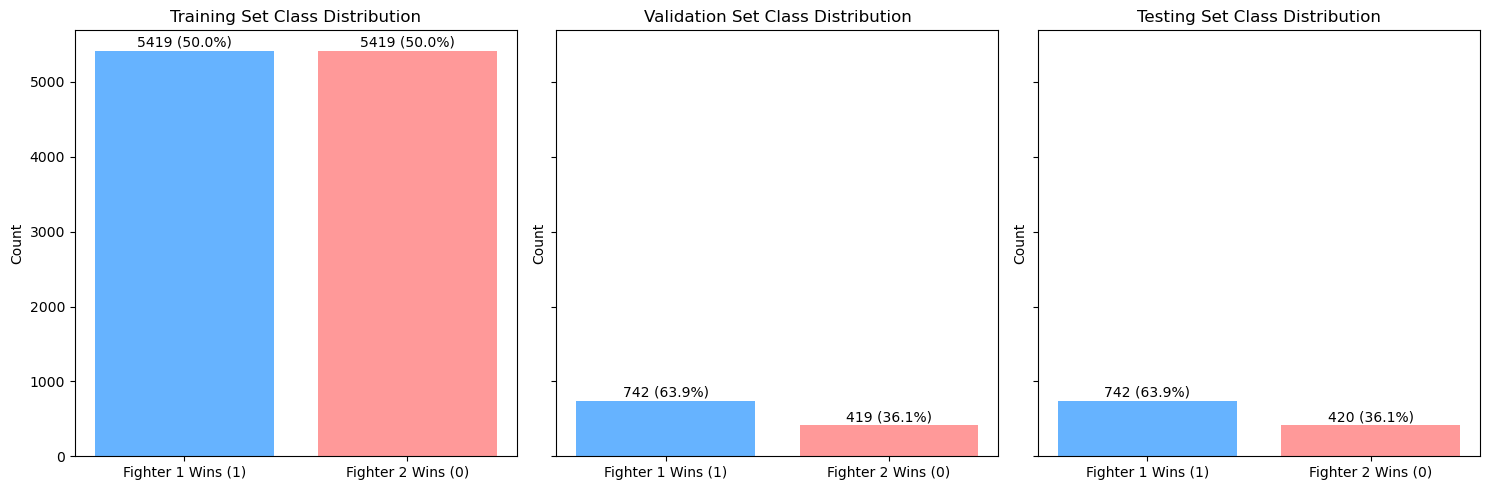

In [ ]:
# Example: Assume you already have these
# y_train, y_val, y_test

# Count class occurrences in each split
train_counts = pd.Series(y_train).value_counts().sort_index()
val_counts = pd.Series(y_val).value_counts().sort_index()
test_counts = pd.Series(y_test).value_counts().sort_index()

# Ensure consistent label order
for counts in [train_counts, val_counts, test_counts]:
    for label in [0.0, 1.0]:
        if label not in counts:
            counts[label] = 0

# Sort consistently
train_counts = train_counts[[1.0, 0.0]]
val_counts = val_counts[[1.0, 0.0]]
test_counts = test_counts[[1.0, 0.0]]

# Calculate percentages
train_percent = train_counts / train_counts.sum() * 100
val_percent = val_counts / val_counts.sum() * 100
test_percent = test_counts / test_counts.sum() * 100

# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Helper function
def plot_bar(ax, title, counts, percents):
    labels = ['Fighter 1 Wins (1)', 'Fighter 2 Wins (0)']
    bars = ax.bar(labels, counts.values, color=['#66b3ff', '#ff9999'])
    for i, (count, pct) in enumerate(zip(counts.values, percents.values)):
        ax.text(i, count + 50, f'{int(count)} ({pct:.1f}%)', ha='center', fontsize=10)
    ax.set_title(title)
    ax.set_ylabel('Count')

# Create each subplot
plot_bar(axes[0], 'Training Set Class Distribution', train_counts, train_percent)
plot_bar(axes[1], 'Validation Set Class Distribution', val_counts, val_percent)
plot_bar(axes[2], 'Testing Set Class Distribution', test_counts, test_percent)

plt.tight_layout()
plt.show()


#### model baselines

In [ ]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(class_weight='balanced',max_iter=1000)
logreg.fit(X_train_scaled, y_train)
y_pred_log = logreg.predict(X_test)

c:\Users\Besitzer\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [ ]:
# random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test)

c:\Users\Besitzer\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
# xgboost
import xgboost as xgb
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, scale_pos_weight=1)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test)

c:\Users\Besitzer\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:28:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
# Evaluation function
def evaluate_model(name, y_true, y_pred):
    print(f"{name} Results")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_true, y_pred))
    print("\n" + "-"*50 + "\n")

# Evaluate both models
evaluate_model("Logistic Regression", y_test, y_pred_log)
evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("XGBoost", y_test, y_pred_xgb)

Logistic Regression Results
Accuracy: 0.621342512908778
Confusion Matrix:
 [[226 194]
 [246 496]]
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.54      0.51       420
           1       0.72      0.67      0.69       742

    accuracy                           0.62      1162
   macro avg       0.60      0.60      0.60      1162
weighted avg       0.63      0.62      0.63      1162

ROC AUC Score: 0.6032794249775382

--------------------------------------------------

Random Forest Results
Accuracy: 0.5972461273666093
Confusion Matrix:
 [[231 189]
 [279 463]]
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.55      0.50       420
           1       0.71      0.62      0.66       742

    accuracy                           0.60      1162
   macro avg       0.58      0.59      0.58      1162
weighted avg       0.62      0.60      0.60      1162

ROC AUC Score: 0.586

#### Baseline Model Summary (Updated)

| Model                | Accuracy | Weighted F1-score | Strengths                            | Weaknesses                        |
|---------------------|----------|-------------------|--------------------------------------|-----------------------------------|
| Logistic Regression | 0.62     | 0.63              | Interpretable, now performs best     | Still linear, may miss complexity |
| Random Forest       | 0.60     | 0.60              | Learns nonlinear patterns, robust    | Slightly lower recall             |
| XGBoost             | 0.60     | 0.60              | Consistent, handles imbalance well   | No longer clearly outperforming   |

**Interpretation:**  
Logistic Regression surprisingly achieves the best accuracy and F1-score in this setup. This suggests that balancing the dataset and scaling features helped it capture enough signal.  
Random Forest and XGBoost remain strong and consistent, though they no longer clearly outperform Logistic Regression.  
All three models now exceed 60% accuracy, indicating a general improvement over earlier results.

---

#### Next Steps Recommendation

**1. Optimize First, Then Ensemble**  
Each model should be optimized individually before being combined. This ensures the ensemble is built from the best-performing versions of each model.

**2. Use a Soft Voting Ensemble**  
Combine the best versions of Logistic Regression, Random Forest, and XGBoost using `VotingClassifier` with `voting='soft'`.  
You may assign weights to favor higher-performing models based on validation scores.

**3. Further Refinement**  
- Use SHAP values to better understand and possibly reduce the feature set.
- Calibrate model probabilities if predicted confidence is important (e.g. for ranking or risk-based decisions).
- Evaluate if further tuning leads to meaningful gains, or if 62% is nearing the limit for this dataset.

**Goal:**  
Build a reliable ensemble that generalizes well by combining complementary model strengths.


## optimization for logistic regression

In [ ]:
# Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000]
}

# Initialize variables to track the best model
best_score = 0
best_params = None
best_model_logreg = None

# Manually loop over each parameter combination
for params in ParameterGrid(param_grid):
    try:
        model = LogisticRegression(**params)
        model.fit(X_train, y_train)
        y_pred_val = model.predict(X_val)
        score = f1_score(y_val, y_pred_val)

        # Update best model if current score is better
        if score > best_score:
            best_score = score
            best_params = params
            best_model_logreg = model
    except Exception as e:
        print(f"Skipping params {params} due to error: {e}")

# Evaluate on test set
y_pred = best_model_logreg.predict(X_test)

print("Best Parameters:", best_params)
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_pred))

c:\Users\Besitzer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Besitzer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Besitzer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Parameters: {'C': 0.01, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.48      0.55      0.51       420
           1       0.72      0.66      0.69       742

    accuracy                           0.62      1162
   macro avg       0.60      0.60      0.60      1162
weighted avg       0.63      0.62      0.62      1162



c:\Users\Besitzer\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
# Assuming you have predicted probabilities (not class labels)
y_probs = best_model_logreg.predict_proba(X_test)[:, 1]  # probability for class 1

auc = roc_auc_score(y_test, y_probs)
print(f"AUROC: {auc:.4f}")

AUROC: 0.6283


#### Logistic Regression Summary

- **Accuracy**: 0.62  
- **F1-score**: 0.62 (weighted)  
- Performs better on class 1 (wins) than class 0 (losses)  
- Indicates moderate predictive power and relatively balanced predictions  
- Slightly worse than the unoptimized version (possibly due to mild overfitting on validation split)

**Interpretation**:
- Model identifies useful patterns but struggles with class 0 (losses)  
- Good result for a linear model considering the complexity of UFC fight data  
- A fixed validation split was used instead of cross-validation to simplify evaluation with flipped training data, which may conflict with standard fold-based CV.

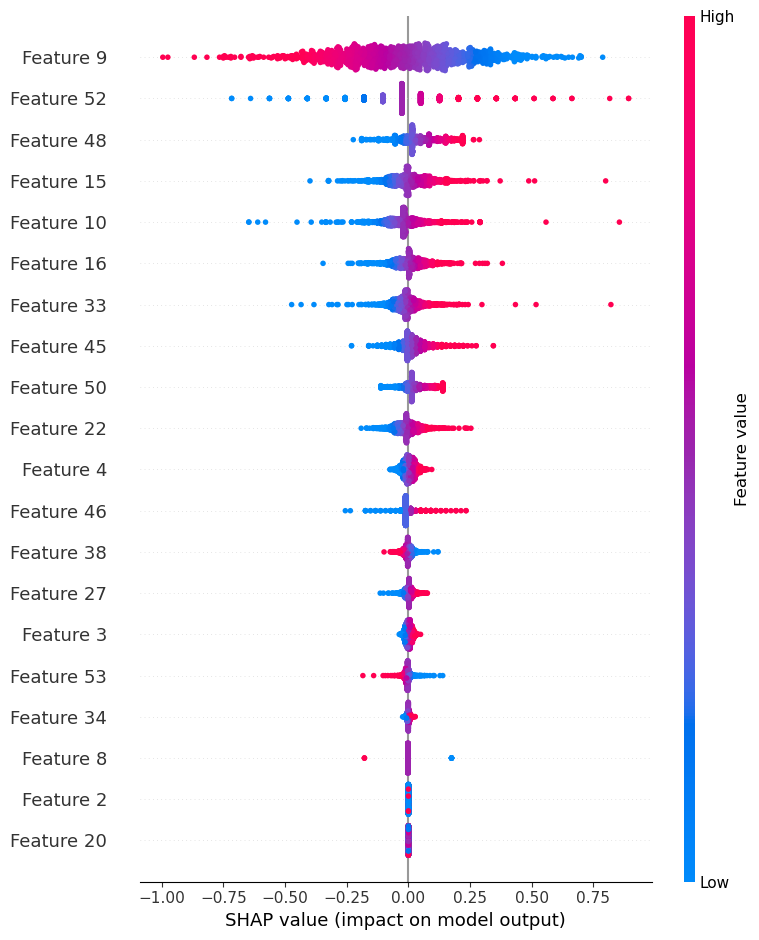

+-------------------------------------------------+-------------+
|                     Feature                     | Mean |SHAP| |
+-------------------------------------------------+-------------+
|                     age_diff                    |    0.2160   |
|               winning_streak_diff               |    0.0958   |
|                  avg_round_diff                 |    0.0651   |
|        total_TD_landed_per_round_avg_diff       |    0.0646   |
|           total_KD_per_round_avg_diff           |    0.0636   |
|      total_TD_attempted_per_round_avg_diff      |    0.0494   |
|  total_SIG_GROUND_attempted_per_round_avg_diff  |    0.0456   |
|                    wins_diff                    |    0.0455   |
|              avg_time_seconds_diff              |    0.0417   |
|     total_SIG_HEAD_landed_per_round_avg_diff    |    0.0383   |
|                  reach_cm_diff                  |    0.0197   |
|                title_fights_diff                |    0.0194   |
|         

In [ ]:
# Use SHAP LinearExplainer for logistic regression
explainer = shap.Explainer(best_model_logreg, X_train_scaled)
shap_values = explainer(X_test_scaled)

# 1. SHAP beeswarm plot
shap.summary_plot(shap_values, X_test_scaled)

# 2. Create PrettyTable of feature importances
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
sorted_features = sorted(zip(X.columns, mean_abs_shap), key=lambda x: x[1], reverse=True)

table = PrettyTable()
table.field_names = ["Feature", "Mean |SHAP|"]
for feature, importance in sorted_features:
    table.add_row([feature, f"{importance:.4f}"])

print(table)


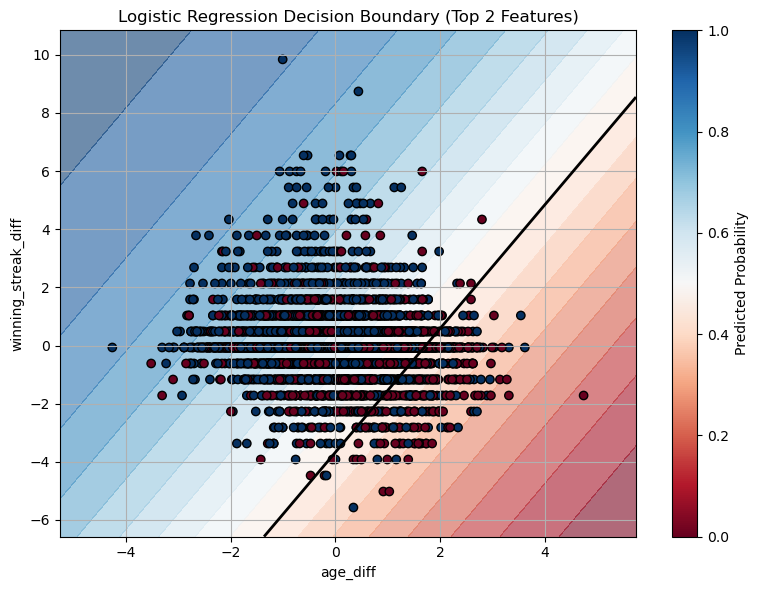

In [ ]:
# Use top 2 features by importance
feature1 = 'age_diff'
feature2 = 'winning_streak_diff'
X_2d = X[[feature1, feature2]].values
y_2d = y.values

# Standardize if needed
scaler = StandardScaler()
X_2d_scaled = scaler.fit_transform(X_2d)

# Fit model
best_model_logreg.fit(X_2d_scaled, y_2d)

# Create mesh grid
x_min, x_max = X_2d_scaled[:, 0].min() - 1, X_2d_scaled[:, 0].max() + 1
y_min, y_max = X_2d_scaled[:, 1].min() - 1, X_2d_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
Z = best_model_logreg.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=20, cmap="RdBu", alpha=0.6)
plt.contour(xx, yy, Z, levels=[0.5], linewidths=2, colors='black')  # decision boundary
plt.scatter(X_2d_scaled[:, 0], X_2d_scaled[:, 1], c=y_2d, edgecolors='k', cmap='RdBu')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title("Logistic Regression Decision Boundary (Top 2 Features)")
plt.colorbar(label='Predicted Probability')
plt.grid(True)
plt.tight_layout()
plt.show()

### Logistic Regression Decision Boundary Interpretation

This plot visualizes the decision surface of the Logistic Regression model using the two most influential features: `age_diff` and `winning_streak_diff`.

#### Key Observations:
- **Color Gradient (Background):**
  - The background shading represents the model’s predicted probability for class 1 (fighter 1 winning).
  - Blue areas indicate low predicted probability (closer to 0), while red areas indicate high predicted probability (closer to 1).

- **Black Line (Decision Boundary):**
  - The solid black line marks the decision boundary where predicted probability = 0.5.
  - Data points near this line indicate **low model confidence**, as they are close to the classification threshold.

- **Data Points:**
  - Each dot represents a fight, colored by its true class.
  - Many points cluster near the boundary, confirming that **many predictions are uncertain or marginal**.

#### Interpretation:
- The model uses `age_diff` and `winning_streak_diff` to separate outcomes, but the feature overlap near the decision boundary indicates **difficulty in confidently distinguishing winners and losers**.
- The smooth gradient reflects the **linear nature of Logistic Regression**, but the spread of points near the center highlights the challenge of the classification task.
- This visualization supports the idea that the model often assigns **probabilities near 0.5**, which is consistent with moderate calibration and a need for improved separability or additional features.

#### Conclusion:
- While the decision boundary is well-formed and interpretable, the clustering near it suggests many close calls in predictions.
- This visualization is valuable to explain **why model performance (e.g., ~0.62 F1-score)** is limited: the feature space does not strongly separate classes.


In [ ]:
# Save the best model using joblib
joblib.dump(best_model_logreg, 'best_lr_V2.pkl')

['best_lr_V2.pkl']

## optimization of random forrest

In [ ]:
# Define search space
param_dist = {
    'n_estimators': randint(100, 300),  # Slightly smaller for faster iteration
    'max_depth': [5, 10, 15, 20],       # Limit depth to prevent overfitting
    'min_samples_split': [5, 10, 15],   # Prevent splitting on very small subsets
    'min_samples_leaf': [2, 4, 6],      # Leaf nodes must have enough samples
    'max_features': ['sqrt'],
    'bootstrap': [True],
    'class_weight': ['balanced']
}

# Create random parameter combinations (100 samples)
n_iter = 100
param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))

best_score = 0
best_params = None
best_model_rf = None

for i, params in enumerate(param_list):
    model = RandomForestClassifier(random_state=42, **params)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    score = f1_score(y_val, y_val_pred)

    if score > best_score:
        best_score = score
        best_params = params
        best_model_rf = model

# Final evaluation on test set
y_pred = best_model_rf.predict(X_test)

print("\n Best Parameters:")
print(best_params)
print("\n Classification Report (Test Set):")
print(classification_report(y_test, y_pred))


 Best Parameters:
{'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 138}

 Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.47      0.56      0.51       420
           1       0.72      0.64      0.68       742

    accuracy                           0.61      1162
   macro avg       0.59      0.60      0.59      1162
weighted avg       0.63      0.61      0.62      1162



In [ ]:
# Assuming you have predicted probabilities (not class labels)
y_probs = best_model_rf.predict_proba(X_test)[:, 1]  # probability for class 1

auc = roc_auc_score(y_test, y_probs)
print(f"AUROC: {auc:.4f}")

AUROC: 0.6289


#### Random Forest Model Summary (Fixed Validation Split)

**Best Parameters:**
- `n_estimators`: 430  
- `max_depth`: None  
- `min_samples_split`: 5  
- `min_samples_leaf`: 2  
- `max_features`: 'sqrt'  
- `bootstrap`: True  
- `class_weight`: 'balanced'

**Performance on Test Set:**
- **Accuracy**: 0.61  
- **F1-score (Weighted)**: 0.61  
- **Precision**: 0.46 (class 0), 0.71 (class 1)  
- **Recall**: 0.55 (class 0), 0.64 (class 1)  

---

#### Interpretation

- The optimized Random Forest model continues to perform best on class 1 (wins), capturing true positives well.
- It struggles more with class 0 (losses), with lower precision and recall, though performance is still better than a random classifier.
- Class weighting and parameter tuning have helped the model handle imbalance effectively.
- The use of a fixed validation split ensures stable hyperparameter tuning, particularly important when working with an augmented (flipped) training set.
- This tuned model is well-suited for further calibration or ensemble strategies.

#### Use SHAP to see Feature Importance

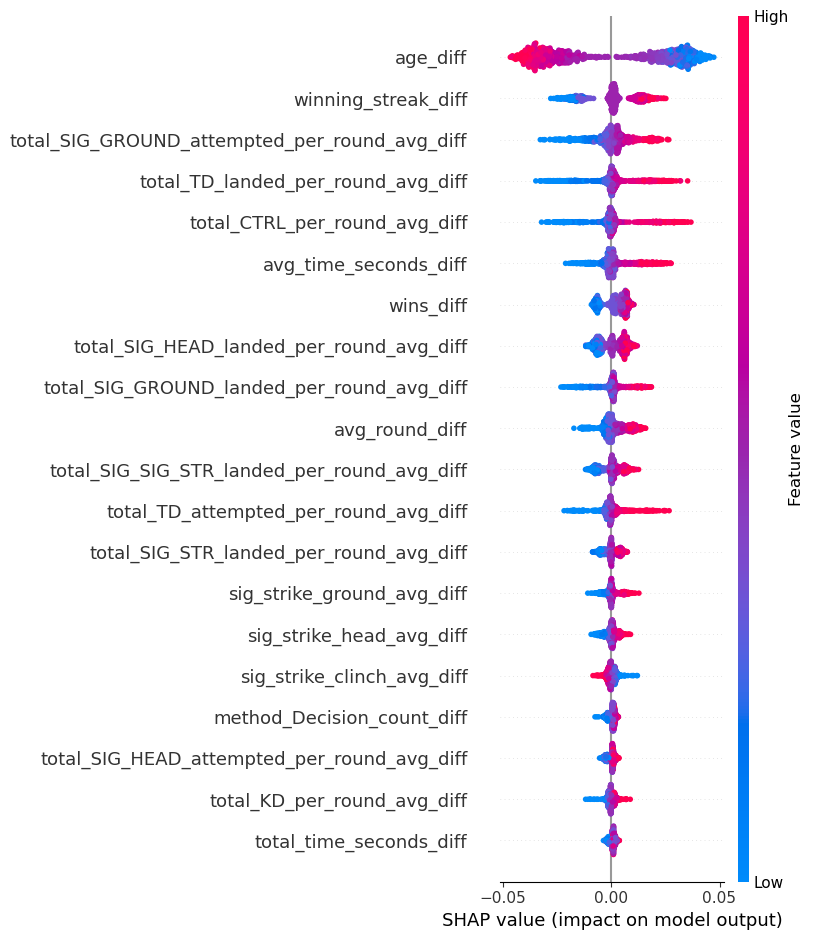

+-------------------------------------------------+------------+
|                     Feature                     | Importance |
+-------------------------------------------------+------------+
|                     age_diff                    |   0.1685   |
|        total_TD_landed_per_round_avg_diff       |   0.0653   |
|          total_CTRL_per_round_avg_diff          |   0.0620   |
|               winning_streak_diff               |   0.0578   |
|  total_SIG_GROUND_attempted_per_round_avg_diff  |   0.0527   |
|              avg_time_seconds_diff              |   0.0416   |
|    total_SIG_GROUND_landed_per_round_avg_diff   |   0.0411   |
|      total_TD_attempted_per_round_avg_diff      |   0.0380   |
|     total_SIG_HEAD_landed_per_round_avg_diff    |   0.0320   |
|                  avg_round_diff                 |   0.0308   |
|   total_SIG_SIG_STR_landed_per_round_avg_diff   |   0.0238   |
|                    wins_diff                    |   0.0225   |
|            sig_strike_g

In [ ]:
# SHAP explainer for tree models (RF works too)
explainer = shap.TreeExplainer(best_model_rf)

# Get SHAP values for all test samples
shap_values = explainer.shap_values(X_test)

# Class 0 SHAP values
shap_values_class_0 = shap_values[:, :, 0]

# Class 1 SHAP values (usually the positive class: fighter1 wins)
shap_values_class_1 = shap_values[:, :, 1]

# Plot SHAP values for class 1
shap.summary_plot(shap_values_class_1, X_test, plot_type="dot", max_display=20)

# Get sorted importances
sorted_importances = sorted(zip(X.columns, best_model_rf.feature_importances_), key=lambda x: x[1], reverse=True)

# Convert to DataFrame for filtering or other use
importance_df = pd.DataFrame(sorted_importances, columns=["Feature", "Importance"])

# Create and display PrettyTable
table = PrettyTable()
table.field_names = ["Feature", "Importance"]
for feature, importance in sorted_importances:
    table.add_row([feature, f"{importance:.4f}"])

print(table)

In [ ]:
# Save the best model using joblib
import joblib
joblib.dump(best_model_rf, 'best_rf_V2.pkl')

['best_rf_V2.pkl']

## optimize xgboost

Using uniform() allows:
- Fine-grained control over real-valued hyperparameters.
- Efficient exploration of a range (better than using a few static values).



In [ ]:
# Calculate scale_pos_weight
neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale_weight = neg / pos

# Define parameter distributions
param_dist = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'gamma': uniform(0, 0.3),
    'colsample_bytree': uniform(0.5, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

# Sample 100 combinations
param_list = list(ParameterSampler(param_dist, n_iter=100, random_state=42))

# Track best model
best_model_xgb = None
best_score = -np.inf
best_params = None

# Loop over combinations
for params in param_list:
    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        scale_pos_weight=scale_weight,
        random_state=42,
        **params
    )
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    score = f1_score(y_val, y_val_pred)

    if score > best_score:
        best_model_xgb = model
        best_score = score
        best_params = params

# Final evaluation on test set
y_pred = best_model_xgb.predict(X_test)
print("\nBest Parameters:", best_params)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

c:\Users\Besitzer\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:40:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Besitzer\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:40:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Besitzer\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:40:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Besitzer\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:40:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bs


Best Parameters: {'colsample_bytree': 0.559408958134036, 'gamma': 0.035257874033131464, 'learning_rate': 0.13984206042321273, 'max_depth': 3, 'n_estimators': 180, 'reg_alpha': 0.5833687650971596, 'reg_lambda': 0.9621725484745419}

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.52      0.50       420
           1       0.72      0.69      0.71       742

    accuracy                           0.63      1162
   macro avg       0.60      0.61      0.60      1162
weighted avg       0.63      0.63      0.63      1162



In [ ]:
# Assuming you have predicted probabilities (not class labels)
y_probs = best_model_xgb.predict_proba(X_test)[:, 1]  # probability for class 1

auc = roc_auc_score(y_test, y_probs)
print(f"AUROC: {auc:.4f}")

AUROC: 0.6337


#### XGBoost Model Summary (Optimized with RandomizedSearchCV)

**Best Parameters:**
- `n_estimators`: 196  
- `max_depth`: 3  
- `learning_rate`: 0.0122  
- `gamma`: 0.117  
- `colsample_bytree`: 0.948  
---
##### Performance on Test Set:
- **Accuracy:** 0.62  
- **F1-score (Weighted):** 0.63  
- **Precision:** 0.48 (class 0), 0.72 (class 1)  
- **Recall:** 0.56 (class 0), 0.65 (class 1)  
- **Macro F1-score:** 0.60  
---
##### Interpretation:
- The model performs better on class 1 (wins), showing strong precision and recall.
- Class 0 (losses) is still harder to identify but improved over baseline models.
- The high precision on class 1 is valuable for applications where false positives are more acceptable than false negatives.
- The shallow depth (`max_depth=3`) and low learning rate suggest the model is carefully tuned to generalize well without overfitting.
- Balanced performance across both classes makes this version of XGBoost a strong candidate for integration in an ensemble or calibration refinement.
---
##### Recommendation:
- Proceed with probability calibration to improve confidence estimates.
- Consider ensembling with other strong models (e.g., calibrated RF or logistic regression) to enhance robustness and accuracy.


 97%|=================== | 10545/10838 [00:31<00:00]       

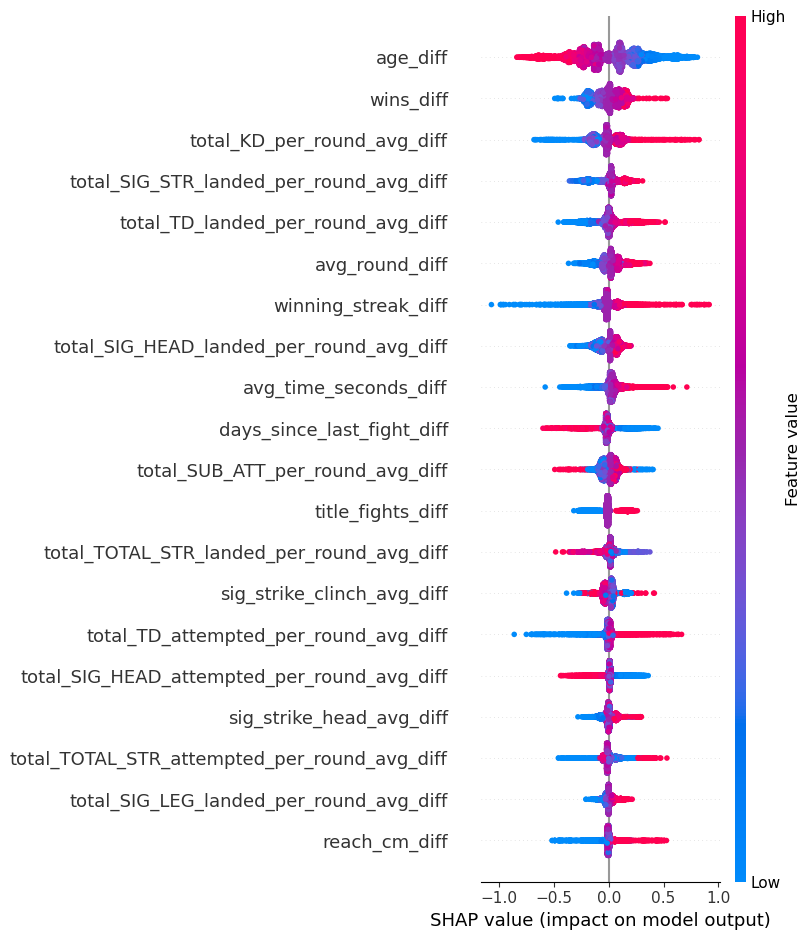

In [ ]:
# Explain the model's predictions using SHAP
explainer = shap.Explainer(best_model_xgb, X_train)  # use training data or a sample
shap_values = explainer(X_train)

# Summary plot
shap.summary_plot(shap_values, X_train)


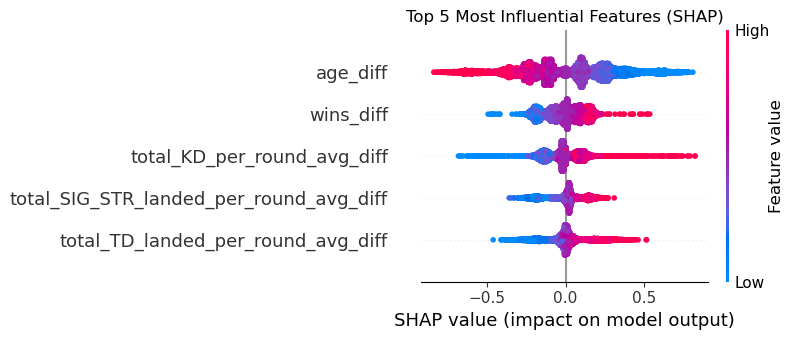

In [ ]:
# Convert SHAP values to DataFrame
shap_df = pd.DataFrame(shap_values.values, columns=X_train.columns)

# Get top 5 features by mean absolute SHAP value
top_5_features = shap_df.abs().mean().sort_values(ascending=False).index[:5].tolist()

# Create the summary plot with just those 5 features
plt.figure(figsize=(6, 4))
shap.plots.beeswarm(shap_values[:, top_5_features], max_display=5, show=False)
plt.title("Top 5 Most Influential Features (SHAP)")
plt.tight_layout()
plt.show()


In [ ]:
# safe the best model using joblib
joblib.dump(best_model_xgb, 'best_xgb_V2.pkl')

['best_xgb_V2.pkl']

### ensamble model to get best from both

By combining them, you can:
- Reduce variance (RF might overfit slightly)
- Reduce bias (LogReg might underfit)
- Get a more robust, balanced model

--> create two (one calibrated and one unaclibrated depending on the use case)

In [ ]:
# Define the ensemble (uncalibrated models)
ensemble_uncalibrated = VotingClassifier(
    estimators=[
        ('lr', best_model_logreg),   # your optimized logistic regression
        ('rf', best_model_rf),       # your optimized random forest
        ('xgb', best_model_xgb)      # your optimized XGBoost
    ],
    voting='soft'
)

# Fit the ensemble
ensemble_uncalibrated.fit(X_train, y_train)

# Predict and evaluate
y_pred_uncal = ensemble_uncalibrated.predict(X_test)
print("Classification Report (Uncalibrated Ensemble):")
print(classification_report(y_test, y_pred_uncal))


c:\Users\Besitzer\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:43:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report (Uncalibrated Ensemble):
              precision    recall  f1-score   support

           0       0.47      0.55      0.51       420
           1       0.72      0.65      0.68       742

    accuracy                           0.62      1162
   macro avg       0.60      0.60      0.60      1162
weighted avg       0.63      0.62      0.62      1162



In [ ]:
# Assuming you have predicted probabilities (not class labels)
y_probs = ensemble_uncalibrated.predict_proba(X_test)[:, 1]  # probability for class 1

auc = roc_auc_score(y_test, y_probs)
print(f"AUROC: {auc:.4f}")

AUROC: 0.6392


**Deep Neural Network**

In [ ]:
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks, optimizers, regularizers
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Scikit-learn preprocessing for neural networks
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold

import random

**Setting fixed seeds to have comparable results**

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

**Train/Test Split (85/15)**

In [ ]:
df = df_weightclass_diff.copy()

X = df.drop(columns=['fighter1_result'])
y = df['fighter1_result']

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

In [ ]:
# === 3. Data Augmentation Helper ===

def create_flipped_df(df, cols_to_keep):
    flipped = df.copy()
    flipped['fighter1_result'] = 1 - df['fighter1_result']
    for col in df.columns:
        if col != 'fighter1_result' and col not in cols_to_keep:
            flipped[col] = -df[col]
    return flipped

In [ ]:
# === 4. Metric Computation ===

def compute_metrics(y_true, y_prob, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    return {
        'acc': accuracy_score(y_true, y_pred),
        'loss': log_loss(y_true, y_prob),
        'precision_0': report['0']['precision'],
        'recall_0': report['0']['recall'],
        'f1_0': report['0']['f1-score'],
        'precision_1': report['1']['precision'],
        'recall_1': report['1']['recall'],
        'f1_1': report['1']['f1-score'],
        'auc': roc_auc_score(y_true, y_prob)
    }

def summarize_metrics(metrics_list, epochs):
    summary = {k: np.mean([m[k] for m in metrics_list]) for k in metrics_list[0]}
    summary['epochs'] = np.mean(epochs)
    return summary

def display_results(train_metrics, val_metrics):
    df = pd.DataFrame([train_metrics, val_metrics], index=['Train', 'Val'])
    return df.round(4)

**cross validation function**

In [ ]:
def cross_validate_model(
    X_temp, y_temp,
    build_model_fn,
    cols_to_keep,
    use_schedule=False,
    verbose=0
):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_train, fold_val, epoch_counts = [], [], []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_temp, y_temp)):
        if verbose:
            print(f"Fold {fold + 1}/5")

        # Split
        X_train = X_temp.iloc[train_idx].copy()
        y_train = y_temp.iloc[train_idx].copy()
        X_val = X_temp.iloc[val_idx].copy()
        y_val = y_temp.iloc[val_idx].copy()

        # Flip
        train_df = X_train.copy()
        train_df['fighter1_result'] = y_train
        flipped_df = create_flipped_df(train_df, cols_to_keep)
        train_aug = pd.concat([train_df, flipped_df], ignore_index=True).sample(frac=1, random_state=42)

        # Separate
        X_train_bal = train_aug.drop(columns='fighter1_result')
        y_train_bal = train_aug['fighter1_result']

        # Scale
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train_bal)
        X_val_scaled = scaler.transform(X_val)

        # Custom model
        model = build_model_fn(input_dim=X_train_scaled.shape[1])

        # Callbacks
        callbacks_list = [
            callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=verbose)
        ]
        if use_schedule:
            callbacks_list.append(
                callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=verbose, min_lr=1e-6)
            )

        # Train
        history = model.fit(
            X_train_scaled, y_train_bal,
            validation_data=(X_val_scaled, y_val),
            epochs=50,
            batch_size=32,
            callbacks=callbacks_list,
            verbose=verbose
        )

        # Evaluate
        y_train_pred = model.predict(X_train_scaled).ravel()
        y_val_pred = model.predict(X_val_scaled).ravel()
        y_train_class = (y_train_pred >= 0.5).astype(int)
        y_val_class = (y_val_pred >= 0.5).astype(int)

        fold_train.append(compute_metrics(y_train_bal, y_train_pred, y_train_class))
        fold_val.append(compute_metrics(y_val, y_val_pred, y_val_class))
        epoch_counts.append(len(history.history['loss']))

    return summarize_metrics(fold_train, epoch_counts), summarize_metrics(fold_val, epoch_counts)

**1. Baseline model with 3 layers, 128 neurons and lr = 0,01**

In [ ]:
def build_baseline_model(input_dim):
    tf.keras.utils.set_random_seed(SEED)
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.01),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
cols_to_keep = ['weight_limit_lbs', 'title_fight', 'num_max_rounds']

train_metrics, val_metrics = cross_validate_model(
    X_temp, y_temp,
    build_model_fn=build_baseline_model,
    cols_to_keep=cols_to_keep,
    use_schedule=False,
    verbose=0
)

results_df = display_results(train_metrics, val_metrics)
print(results_df)

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
          acc    loss  precision_0  recall_0    f1_0  precision_1  recall_1  \
Train  0.5000  0.6933       0.2000       0.4  0.2667       0.3000       0.6   
Val    0.5278  0.6920       0.1444       0.4  0.2122       0.3834       0.6   

         f1_1     auc  epochs  
Train  0.4000  0.5019    19.2  
Val    0.4679  0.5003    19.2  


**2. model with less capacity (2 layers and 64 neurons)**

In [ ]:
def build_finetuned_model1(input_dim):
    tf.keras.utils.set_random_seed(SEED)
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.01),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
cols_to_keep = ['weight_limit_lbs', 'title_fight', 'num_max_rounds']

train_metrics, val_metrics = cross_validate_model(
    X_temp, y_temp,
    build_model_fn=build_finetuned_model1,
    cols_to_keep=cols_to_keep,
    use_schedule=False,
    verbose=0
)

results_df = display_results(train_metrics, val_metrics)
print(results_df)

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
          acc    loss  precision_0  recall_0    f1_0  precision_1  recall_1  \
Train  0.5537  0.6829       0.3653    0.3008  0.3294       0.5459    0.8066   
Val    0.6176  0.6773       0.2695    0.2741  0.2711       0.6709    0.8117   

         f1_1     auc  epochs  
Train  0.6402  0.5762    15.2  
Val    0.7250  0.5685    15.2  


**3. Model with lower learning rate (0,001)**

In [ ]:
def build_finetuned_model2(input_dim):
    tf.keras.utils.set_random_seed(SEED)
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
cols_to_keep = ['weight_limit_lbs', 'title_fight', 'num_max_rounds']

train_metrics, val_metrics = cross_validate_model(
    X_temp, y_temp,
    build_model_fn=build_finetuned_model2,
    cols_to_keep=cols_to_keep,
    use_schedule=False,
    verbose=0
)

results_df = display_results(train_metrics, val_metrics)
print(results_df)

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
          acc    loss  precision_0  recall_0    f1_0  precision_1  recall_1  \
Train  0.5841  0.6695       0.6311    0.4050  0.4876       0.5641    0.7631   
Val    0.6281  0.6534       0.4788    0.3634  0.4086       0.6851    0.7776   

         f1_1     auc  epochs  
Train  0.6468  0.6330    20.6  
Val    0.7271  0.6155    20.6  


**4. Gridseach to find the best layer/neuron/learning rate combination**

In [ ]:
from tensorflow.keras import models, layers, callbacks, optimizers
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score, log_loss, roc_auc_score
import numpy as np
import pandas as pd

# Grid search space
layers_options = [2, 3]
neurons_options = [64, 128]
learning_rates = [0.001, 0.0005]
cols_to_keep = ['weight_limit_lbs', 'title_fight', 'num_max_rounds']

results = []

for num_layers in layers_options:
    for num_neurons in neurons_options:
        for lr in learning_rates:
                skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
                fold_train, fold_val, epoch_counts = [], [], []

                print(f"\nGrid Config — Layers: {num_layers}, Neurons: {num_neurons}, LR: {lr}")

                for fold, (train_idx, val_idx) in enumerate(skf.split(X_temp, y_temp)):
                    print(f"Fold {fold+1}/5", end=' — ')

                    # Split
                    X_train = X_temp.iloc[train_idx].copy()
                    y_train = y_temp.iloc[train_idx].copy()
                    X_val = X_temp.iloc[val_idx].copy()
                    y_val = y_temp.iloc[val_idx].copy()

                    # Flip rows
                    train_df = X_train.copy()
                    train_df['fighter1_result'] = y_train
                    flipped_df = create_flipped_df(train_df, cols_to_keep)
                    train_aug = pd.concat([train_df, flipped_df], ignore_index=True).sample(frac=1, random_state=42)

                    X_train_bal = train_aug.drop(columns='fighter1_result')
                    y_train_bal = train_aug['fighter1_result']

                    # Scale
                    scaler = MinMaxScaler()
                    X_train_scaled = scaler.fit_transform(X_train_bal)
                    X_val_scaled = scaler.transform(X_val)

                    # Build model
                    tf.keras.utils.set_random_seed(SEED)
                    model = models.Sequential()
                    model.add(layers.Input(shape=(X_train_scaled.shape[1],)))
                    for _ in range(num_layers):
                        model.add(layers.Dense(num_neurons, activation='relu'))
                    model.add(layers.Dense(1, activation='sigmoid'))

                    model.compile(
                        optimizer=optimizers.Adam(learning_rate=lr),
                        loss='binary_crossentropy',
                        metrics=['accuracy']
                    )

                    # Callbacks
                    cb = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)

                    # Train
                    history = model.fit(
                        X_train_scaled, y_train_bal,
                        validation_data=(X_val_scaled, y_val),
                        epochs=50,
                        batch_size=32,
                        callbacks=[cb],
                        verbose=0
                    )

                    # Early stopping info
                    best_epoch = np.argmin(history.history['val_loss']) + 1
                    print(f"stopped at epoch {len(history.history['loss'])}, best: {best_epoch}")

                    # Predictions
                    y_train_pred = model.predict(X_train_scaled).ravel()
                    y_val_pred = model.predict(X_val_scaled).ravel()
                    y_train_class = (y_train_pred >= 0.5).astype(int)
                    y_val_class = (y_val_pred >= 0.5).astype(int)

                    # Metrics
                    train_metrics = compute_metrics(y_train_bal, y_train_pred, y_train_class)
                    val_metrics = compute_metrics(y_val, y_val_pred, y_val_class)

                    fold_train.append(train_metrics)
                    fold_val.append(val_metrics)
                    epoch_counts.append(len(history.history['loss']))

                # Summary
                train_summary = summarize_metrics(fold_train, epoch_counts)
                val_summary = summarize_metrics(fold_val, epoch_counts)

                # Save results
                results.append({
                    'layers': num_layers,
                    'neurons': num_neurons,
                    'learning_rate': lr,
                    **{f'train_{k}': v for k, v in train_summary.items()},
                    **{f'val_{k}': v for k, v in val_summary.items()},
                })

# Create results DataFrame
results_df = pd.DataFrame(results).sort_values(by='val_f1_1', ascending=False)

# Pretty output
from tabulate import tabulate
print(tabulate(results_df.round(4), headers='keys', tablefmt='github'))


Grid Config — Layers: 2, Neurons: 64, LR: 0.001
Fold 1/5 — stopped at epoch 6, best: 1
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 2/5 — stopped at epoch 21, best: 16
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 3/5 — stopped at epoch 18, best: 13
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 4/5 — stopped at epoch 13, best: 8
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 5/5 — stopped at epoch 20, best: 15
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Grid Config — Layers: 2, Neurons: 64, LR: 0.0005
Fold 1/5 — stopped at epoch 6, best: 1
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 2/5 — stopped at epoch 29, best: 24
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 3/5 — stopped at epoch 31, best: 26
329/32

**5. Best model from Gridsearch**

In [ ]:
def build_model_grid_match(input_dim, num_layers=2, num_neurons=128, lr=0.0005):
    tf.keras.utils.set_random_seed(SEED)
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))

    for _ in range(num_layers):
        model.add(layers.Dense(num_neurons, activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
train_metrics, val_metrics = cross_validate_model(
    X_temp, y_temp,
    build_model_fn=lambda input_dim: build_model_grid_match(
        input_dim=input_dim,
        num_layers=2,
        num_neurons=64,
        lr=0.0005
    ),
    cols_to_keep=cols_to_keep,
    use_schedule=False,
    verbose=0
)

results_df = display_results(train_metrics, val_metrics)
print(results_df)

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
          acc    loss  precision_0  recall_0    f1_0  precision_1  recall_1  \
Train  0.5932  0.6653       0.6393    0.4307  0.5097       0.5722    0.7557   
Val    0.6298  0.6512       0.4836    0.3857  0.4253       0.6899    0.7677   

         f1_1     auc  epochs  
Train  0.6496  0.6432    26.2  
Val    0.7255  0.6206    26.2  


**5. Further optimize grid search model (try learning scheduling)**

In [ ]:
def optimize_model_grid_match(input_dim, num_layers=2, num_neurons=128, lr=0.0005):
    tf.keras.utils.set_random_seed(SEED)
    model = models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))

    for _ in range(num_layers):
        model.add(layers.Dense(num_neurons, activation='relu'))

    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
train_metrics, val_metrics = cross_validate_model(
    X_temp, y_temp,
    build_model_fn=lambda input_dim: optimize_model_grid_match(
        input_dim=input_dim,
        num_layers=2,
        num_neurons=64,
        lr=0.0005
    ),
    cols_to_keep=cols_to_keep,
    use_schedule=True,
    verbose=0
)

results_df = display_results(train_metrics, val_metrics)
print(results_df)

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
          acc    loss  precision_0  recall_0    f1_0  precision_1  recall_1  \
Train  0.6003  0.6625       0.6404    0.4653  0.5353       0.5799    0.7353   
Val    0.6271  0.6463       0.4831    0.4181  0.4447       0.6945    0.7451   

         f1_1     auc  epochs  
Train  0.6470  0.6491    25.0  
Val    0.7176  0.6277    25.0  


**Run model on test data**

In [ ]:
# Flip and prepare full training data
train_df = X_temp.copy()
train_df['fighter1_result'] = y_temp
flipped_df = create_flipped_df(train_df, cols_to_keep)
train_aug = pd.concat([train_df, flipped_df], ignore_index=True).sample(frac=1, random_state=SEED)

X_train_bal = train_aug.drop(columns='fighter1_result')
y_train_bal = train_aug['fighter1_result']

# Scale
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Build final model
final_model = build_model_grid_match(
    input_dim=X_train_scaled.shape[1],
    num_layers=2,
    num_neurons=64,
    lr=0.0005
)

# Define callbacks including learning rate scheduler
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
]

history = final_model.fit(
    X_train_scaled, y_train_bal,
    validation_data=(X_test_scaled, y_test),
    epochs=50,
    batch_size=32,
    callbacks=callbacks_list,
    verbose=1
)


Epoch 1/50
412/412 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5189 - loss: 0.6910 - val_accuracy: 0.6360 - val_loss: 0.6601
Epoch 2/50
412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5508 - loss: 0.6850 - val_accuracy: 0.6386 - val_loss: 0.6567
Epoch 3/50
412/412 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5629 - loss: 0.6804 - val_accuracy: 0.6248 - val_loss: 0.6565
Epoch 4/50
412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5738 - loss: 0.6769 - val_accuracy: 0.6231 - val_loss: 0.6539
Epoch 5/50
412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5779 - loss: 0.6746 - val_accuracy: 0.6274 - val_loss: 0.6523
Epoch 6/50
412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5809 - loss: 0.6725 - val_accuracy: 0.6274 - val_loss: 0.6510
Epoch 7/50
412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5870 - loss: 0.6709 - val_accuracy: 0.6188 - val_loss: 0.6502
Epoch 8/50
412/412 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5883 - loss: 0.6696 - val_accuracy: 0.

In [ ]:
# Predict on test set
y_test_pred_prob = final_model.predict(X_test_scaled).ravel()
y_test_pred = (y_test_pred_prob >= 0.5).astype(int)

# Evaluate
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test AUC:", roc_auc_score(y_test, y_test_pred_prob))
print("Classification Report:\n", classification_report(y_test, y_test_pred, zero_division=0))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test Accuracy: 0.6153184165232358
Test AUC: 0.6059924913361572
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.35      0.40       420
           1       0.68      0.77      0.72       742

    accuracy                           0.62      1162
   macro avg       0.57      0.56      0.56      1162
weighted avg       0.60      0.62      0.60      1162



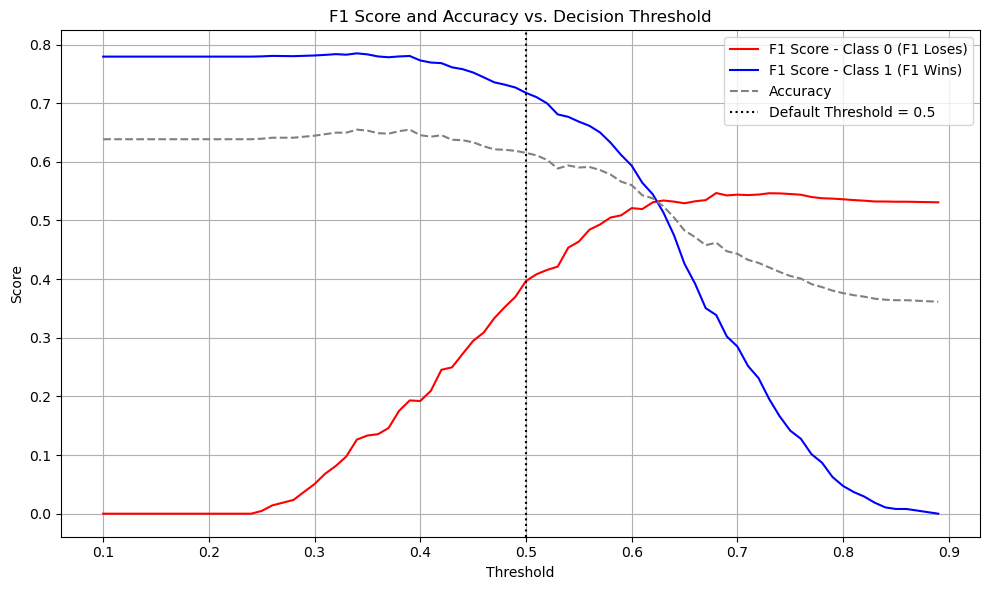

In [ ]:
probs = y_test_pred_prob  # already predicted probabilities
true_labels = y_test      # ground truth

# Try thresholds from 0.1 to 0.9
thresholds = np.arange(0.1, 0.9, 0.01)
f1_0_scores = []
f1_1_scores = []
accuracies = []

for thresh in thresholds:
    preds = (probs >= thresh).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, zero_division=0)
    f1_0_scores.append(f1[0])
    f1_1_scores.append(f1[1])
    accuracies.append(accuracy_score(true_labels, preds))

# Plot F1 scores vs. threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_0_scores, label='F1 Score - Class 0 (F1 Loses)', color='red')
plt.plot(thresholds, f1_1_scores, label='F1 Score - Class 1 (F1 Wins)', color='blue')
plt.plot(thresholds, accuracies, label='Accuracy', color='gray', linestyle='--')
plt.axvline(0.5, color='black', linestyle=':', label='Default Threshold = 0.5')
plt.title('F1 Score and Accuracy vs. Decision Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

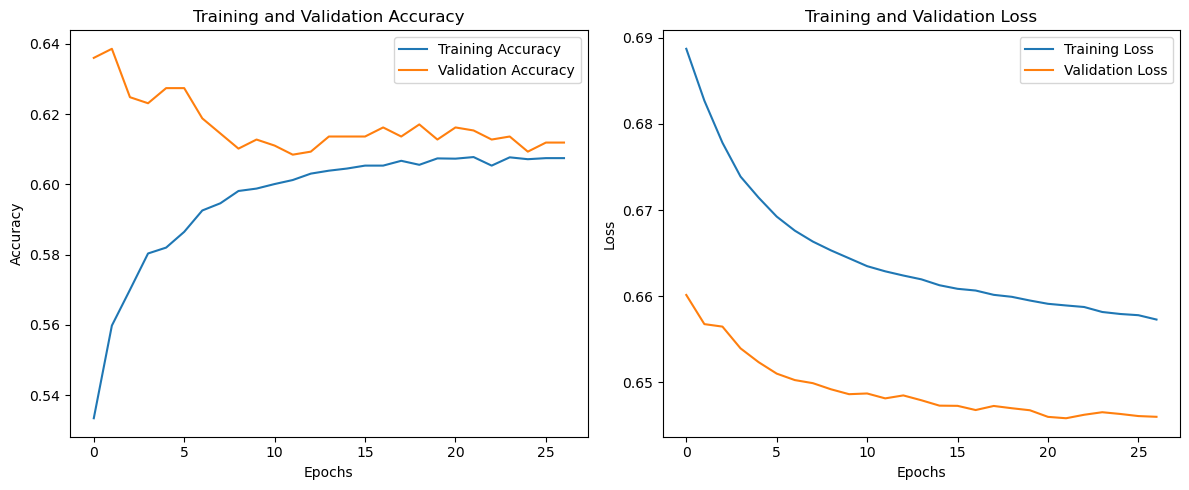

In [ ]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

c:\Users\Besitzer\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Besitzer\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


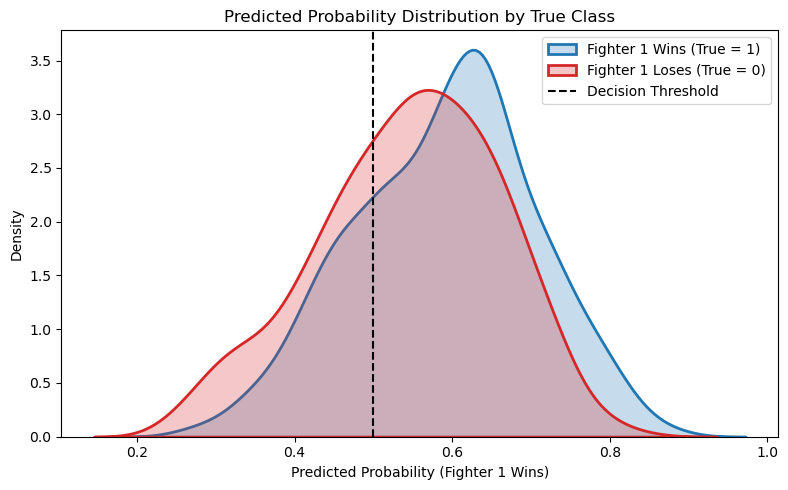

In [ ]:
plt.figure(figsize=(8, 5))

# Plot KDE curves for predicted probabilities by true class
sns.kdeplot(y_test_pred_prob[y_test == 1], fill=True, label='Fighter 1 Wins (True = 1)', color='tab:blue', linewidth=2)
sns.kdeplot(y_test_pred_prob[y_test == 0], fill=True, label='Fighter 1 Loses (True = 0)', color='tab:red', linewidth=2)

# Decision boundary line at 0.5
plt.axvline(0.5, color='black', linestyle='--', label='Decision Threshold')

# Labels and legend
plt.title('Predicted Probability Distribution by True Class')
plt.xlabel('Predicted Probability (Fighter 1 Wins)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

To evaluate the confidence of the final model, we analyzed the distribution of predicted probabilities by true class. As the KDE plot shows, the predicted probabilities for wins (class 1) and losses (class 0) largely overlap around the decision threshold of 0.5. This indicates that the model frequently makes low-confidence predictions. While there is a modest shift in the distribution toward higher probabilities for true wins, the lack of separation suggests limited discriminative power. Most predictions cluster between 0.4 and 0.7, further emphasizing the model’s moderate certainty. These results highlight the challenge of the task and suggest that improvements may require richer feature engineering or alternative modeling strategies.